<a href="https://colab.research.google.com/github/samirp92/Final-Year-Project-Time-Series-Forecasting-/blob/LSTM/LSTM_Electric_Power_Consumption_Forecasting_Student_ID_21072112.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the required libraries

In [52]:
# Disable warnings in the notebook for maintaining clean output
import warnings
warnings.filterwarnings('ignore')

# Import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [30]:
# Mount the google drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# Set the root path directory
root_path = "/content/drive/MyDrive/Final Year Project"

Mounted at /content/drive


# Data Loading

In [31]:
# Load the data from google drive
df = pd.read_csv("/content/drive/MyDrive/Final Year Project/household_power_consumption.txt", sep=';')
df

Date      Time Global_active_power Global_reactive_power  \
0        16/12/2006  17:24:00               4.216                 0.418   
1        16/12/2006  17:25:00               5.360                 0.436   
2        16/12/2006  17:26:00               5.374                 0.498   
3        16/12/2006  17:27:00               5.388                 0.502   
4        16/12/2006  17:28:00               3.666                 0.528   
...             ...       ...                 ...                   ...   
2075254  26/11/2010  20:58:00               0.946                   0.0   
2075255  26/11/2010  20:59:00               0.944                   0.0   
2075256  26/11/2010  21:00:00               0.938                   0.0   
2075257  26/11/2010  21:01:00               0.934                   0.0   
2075258  26/11/2010  21:02:00               0.932                   0.0   

         Voltage Global_intensity Sub_metering_1 Sub_metering_2  \
0        234.840           18.400          0.000          1.000   
1        233.630           23.000          0.000          1.000   
2        233.290           23.000          0.000          2.000   
3        233.740           23.000          0.000          1.000   
4        235.680           15.800          0.000          1.000   
...          ...              ...            ...            ...   
2075254   240.43              4.0            0.0            0.0   
2075255    240.0              4.0            0.0            0.0   
2075256   239.82              3.8            0.0            0.0   
2075257    239.7              3.8            0.0            0.0   
2075258   239.55              3.8            0.0            0.0   

         Sub_metering_3  
0                  17.0  
1                  16.0  
2                  17.0  
3                  17.0  
4                  17.0  
...                 ...  
2075254             0.0  
2075255             0.0  
2075256             0.0  
2075257             0.0  
2075258             0.0  

[2075259 rows x 9 columns]

In [32]:
# Display DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


# Data Preprocessing

In [33]:
# Replace '?' with NaN values
df.replace('?', np.nan, inplace=True)

In [34]:
# Convert numeric columns to appropriate data types
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df['Global_reactive_power'] = pd.to_numeric(df['Global_reactive_power'], errors='coerce')
df['Voltage'] = pd.to_numeric(df['Voltage'], errors='coerce')
df['Global_intensity'] = pd.to_numeric(df['Global_intensity'], errors='coerce')
df['Sub_metering_1'] = pd.to_numeric(df['Sub_metering_1'], errors='coerce')
df['Sub_metering_2'] = pd.to_numeric(df['Sub_metering_2'], errors='coerce')

# Confirm the updated data types
print(df.dtypes)

Date                      object
Time                      object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object


In [35]:
# Check Missing Values
df.isnull().sum()

Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [36]:
# Convert the 'Date' and 'Time' columns to a single 'date_time' column
df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Convert the 'date_time' column to datetime format
df['date_time'] = pd.to_datetime(df['date_time'])

# Set the 'date_time' column as the index
df.set_index('date_time', inplace=True)

# Drop the original 'Date' and 'Time' columns
df.drop(columns=['Date', 'Time'], inplace=True)

# Copy the original DataFrame into a new DataFrame
df_copy = df.copy()
df_copy

Global_active_power  Global_reactive_power  Voltage  \
date_time                                                                  
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   
...                                  ...                    ...      ...   
2010-11-26 20:58:00                0.946                  0.000   240.43   
2010-11-26 20:59:00                0.944                  0.000   240.00   
2010-11-26 21:00:00                0.938                  0.000   239.82   
2010-11-26 21:01:00                0.934                  0.000   239.70   
2010-11-26 21:02:00                0.932                  0.000   239.55   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
date_time                                                               
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00              15.8             0.0             1.0   
...                               ...             ...             ...   
2010-11-26 20:58:00               4.0             0.0             0.0   
2010-11-26 20:59:00               4.0             0.0             0.0   
2010-11-26 21:00:00               3.8             0.0             0.0   
2010-11-26 21:01:00               3.8             0.0             0.0   
2010-11-26 21:02:00               3.8             0.0             0.0   

                     Sub_metering_3  
date_time                            
2006-12-16 17:24:00            17.0  
2006-12-16 17:25:00            16.0  
2006-12-16 17:26:00            17.0  
2006-12-16 17:27:00            17.0  
2006-12-16 17:28:00            17.0  
...                             ...  
2010-11-26 20:58:00             0.0  
2010-11-26 20:59:00             0.0  
2010-11-26 21:00:00             0.0  
2010-11-26 21:01:00             0.0  
2010-11-26 21:02:00             0.0  

[2075259 rows x 7 columns]

# Data Imputation

In [37]:
# Check Missing Values
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [38]:
# Apply MICE imputer
imputer = IterativeImputer(random_state=0)
df_imputed = imputer.fit_transform(df)

# Convert back to DataFrame
df_imputed = pd.DataFrame(df_imputed, index=df.index, columns=df.columns)

# Fill NaN values using the mean for each column
#df_imputed = df.copy()
#df_imputed.fillna(df.mean(), inplace=True)

# Save the DataFrame to an Excel file
df_imputed.to_csv('df_imputed.csv')

In [39]:
# Check Missing Values after imputation
df_imputed.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

Note:-

(Global_active_power*1000/60 - Sub_metering_1 - Sub_metering_2 - Sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3

In [40]:
# Creating new variable for remaining power consumption in watt hour
equation1 = (df_imputed['Global_active_power']*1000/60)
equation2 = df_imputed['Sub_metering_1'] + df_imputed['Sub_metering_2'] + df_imputed['Sub_metering_3']
df_imputed['Sub_metering_4'] = equation1 - equation2
df_imputed

Global_active_power  Global_reactive_power  Voltage  \
date_time                                                                  
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   
...                                  ...                    ...      ...   
2010-11-26 20:58:00                0.946                  0.000   240.43   
2010-11-26 20:59:00                0.944                  0.000   240.00   
2010-11-26 21:00:00                0.938                  0.000   239.82   
2010-11-26 21:01:00                0.934                  0.000   239.70   
2010-11-26 21:02:00                0.932                  0.000   239.55   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
date_time                                                               
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00              15.8             0.0             1.0   
...                               ...             ...             ...   
2010-11-26 20:58:00               4.0             0.0             0.0   
2010-11-26 20:59:00               4.0             0.0             0.0   
2010-11-26 21:00:00               3.8             0.0             0.0   
2010-11-26 21:01:00               3.8             0.0             0.0   
2010-11-26 21:02:00               3.8             0.0             0.0   

                     Sub_metering_3  Sub_metering_4  
date_time                                            
2006-12-16 17:24:00            17.0       52.266667  
2006-12-16 17:25:00            16.0       72.333333  
2006-12-16 17:26:00            17.0       70.566667  
2006-12-16 17:27:00            17.0       71.800000  
2006-12-16 17:28:00            17.0       43.100000  
...                             ...             ...  
2010-11-26 20:58:00             0.0       15.766667  
2010-11-26 20:59:00             0.0       15.733333  
2010-11-26 21:00:00             0.0       15.633333  
2010-11-26 21:01:00             0.0       15.566667  
2010-11-26 21:02:00             0.0       15.533333  

[2075259 rows x 8 columns]

In [41]:
# Resampled the data
hourly_resampled = df_imputed.resample('H').mean()

# Save DataFrame to a CSV file
hourly_resampled.to_csv('hourly_resampled.csv')

# EDA

In [42]:
# Define a function to plot the visualization, distribution and correlation of resampled data
def df_visu_dist_corr(df, resample_type, title):

  # Resample the data
  df_resampled = df.resample(resample_type).mean()

  print('Shape after %s resampling of data : %s ' %(title, df_resampled.shape))
  print('\n')

  # Plot Resampled Data set
  df_resampled.plot(subplots=True, figsize=(25,20))
  plt.suptitle("Visualization of %s Resampled Data" %title, fontsize=30, color='blue')
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.show()

  # Plot distribution
  print(' \n\n************************************************ Distribution Plot for %s Resampled Data **************************************************' %title, end="\n\n")
  df_resampled.hist(figsize=(15, 10), bins=50)
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.gcf().set_dpi(300)
  plt.show()

  # Plot correlation plot
  print(' \n\n************************************************ Correlation Plot for %s Resampled Data **************************************************' %title, end="\n\n")
  plt.figure(figsize=(10,6))
  sns.heatmap(df_imputed.corr(), annot=True, cmap='coolwarm', fmt='.2f')
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.gcf().set_dpi(200)
  plt.show()

Shape after Hourly resampling of data : (34589, 8) 




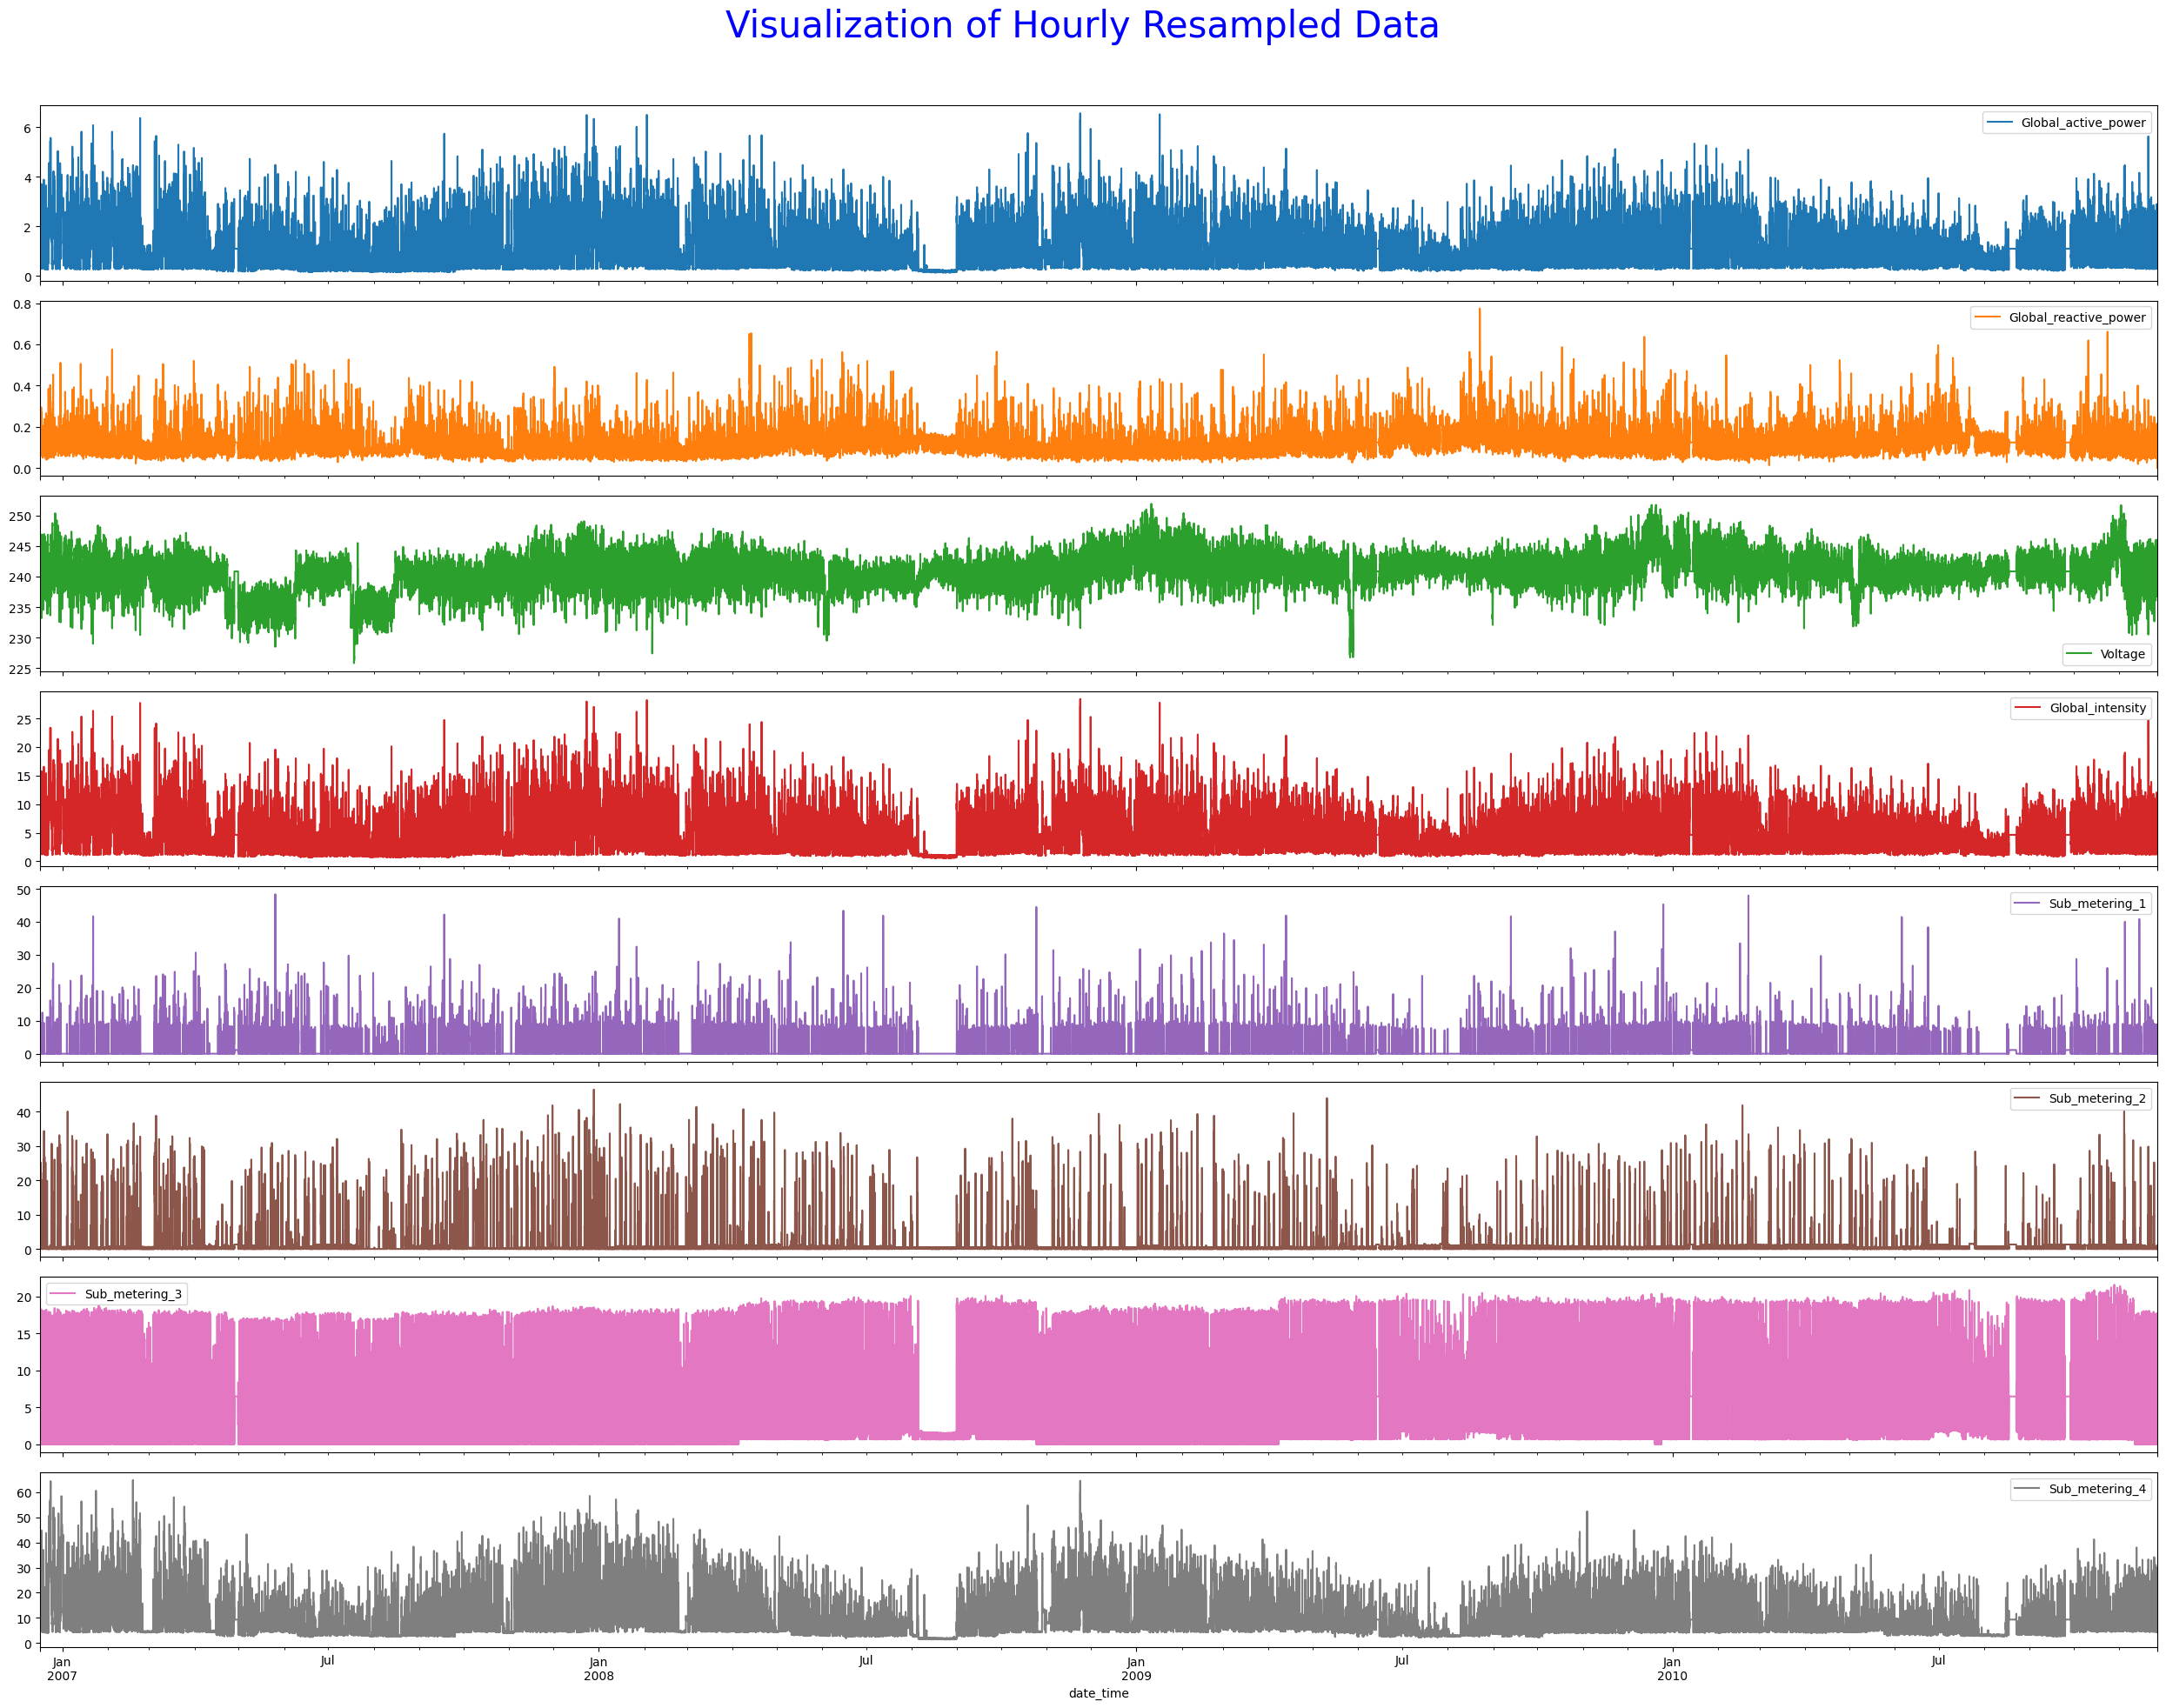

 

************************************************ Distribution Plot for Hourly Resampled Data **************************************************



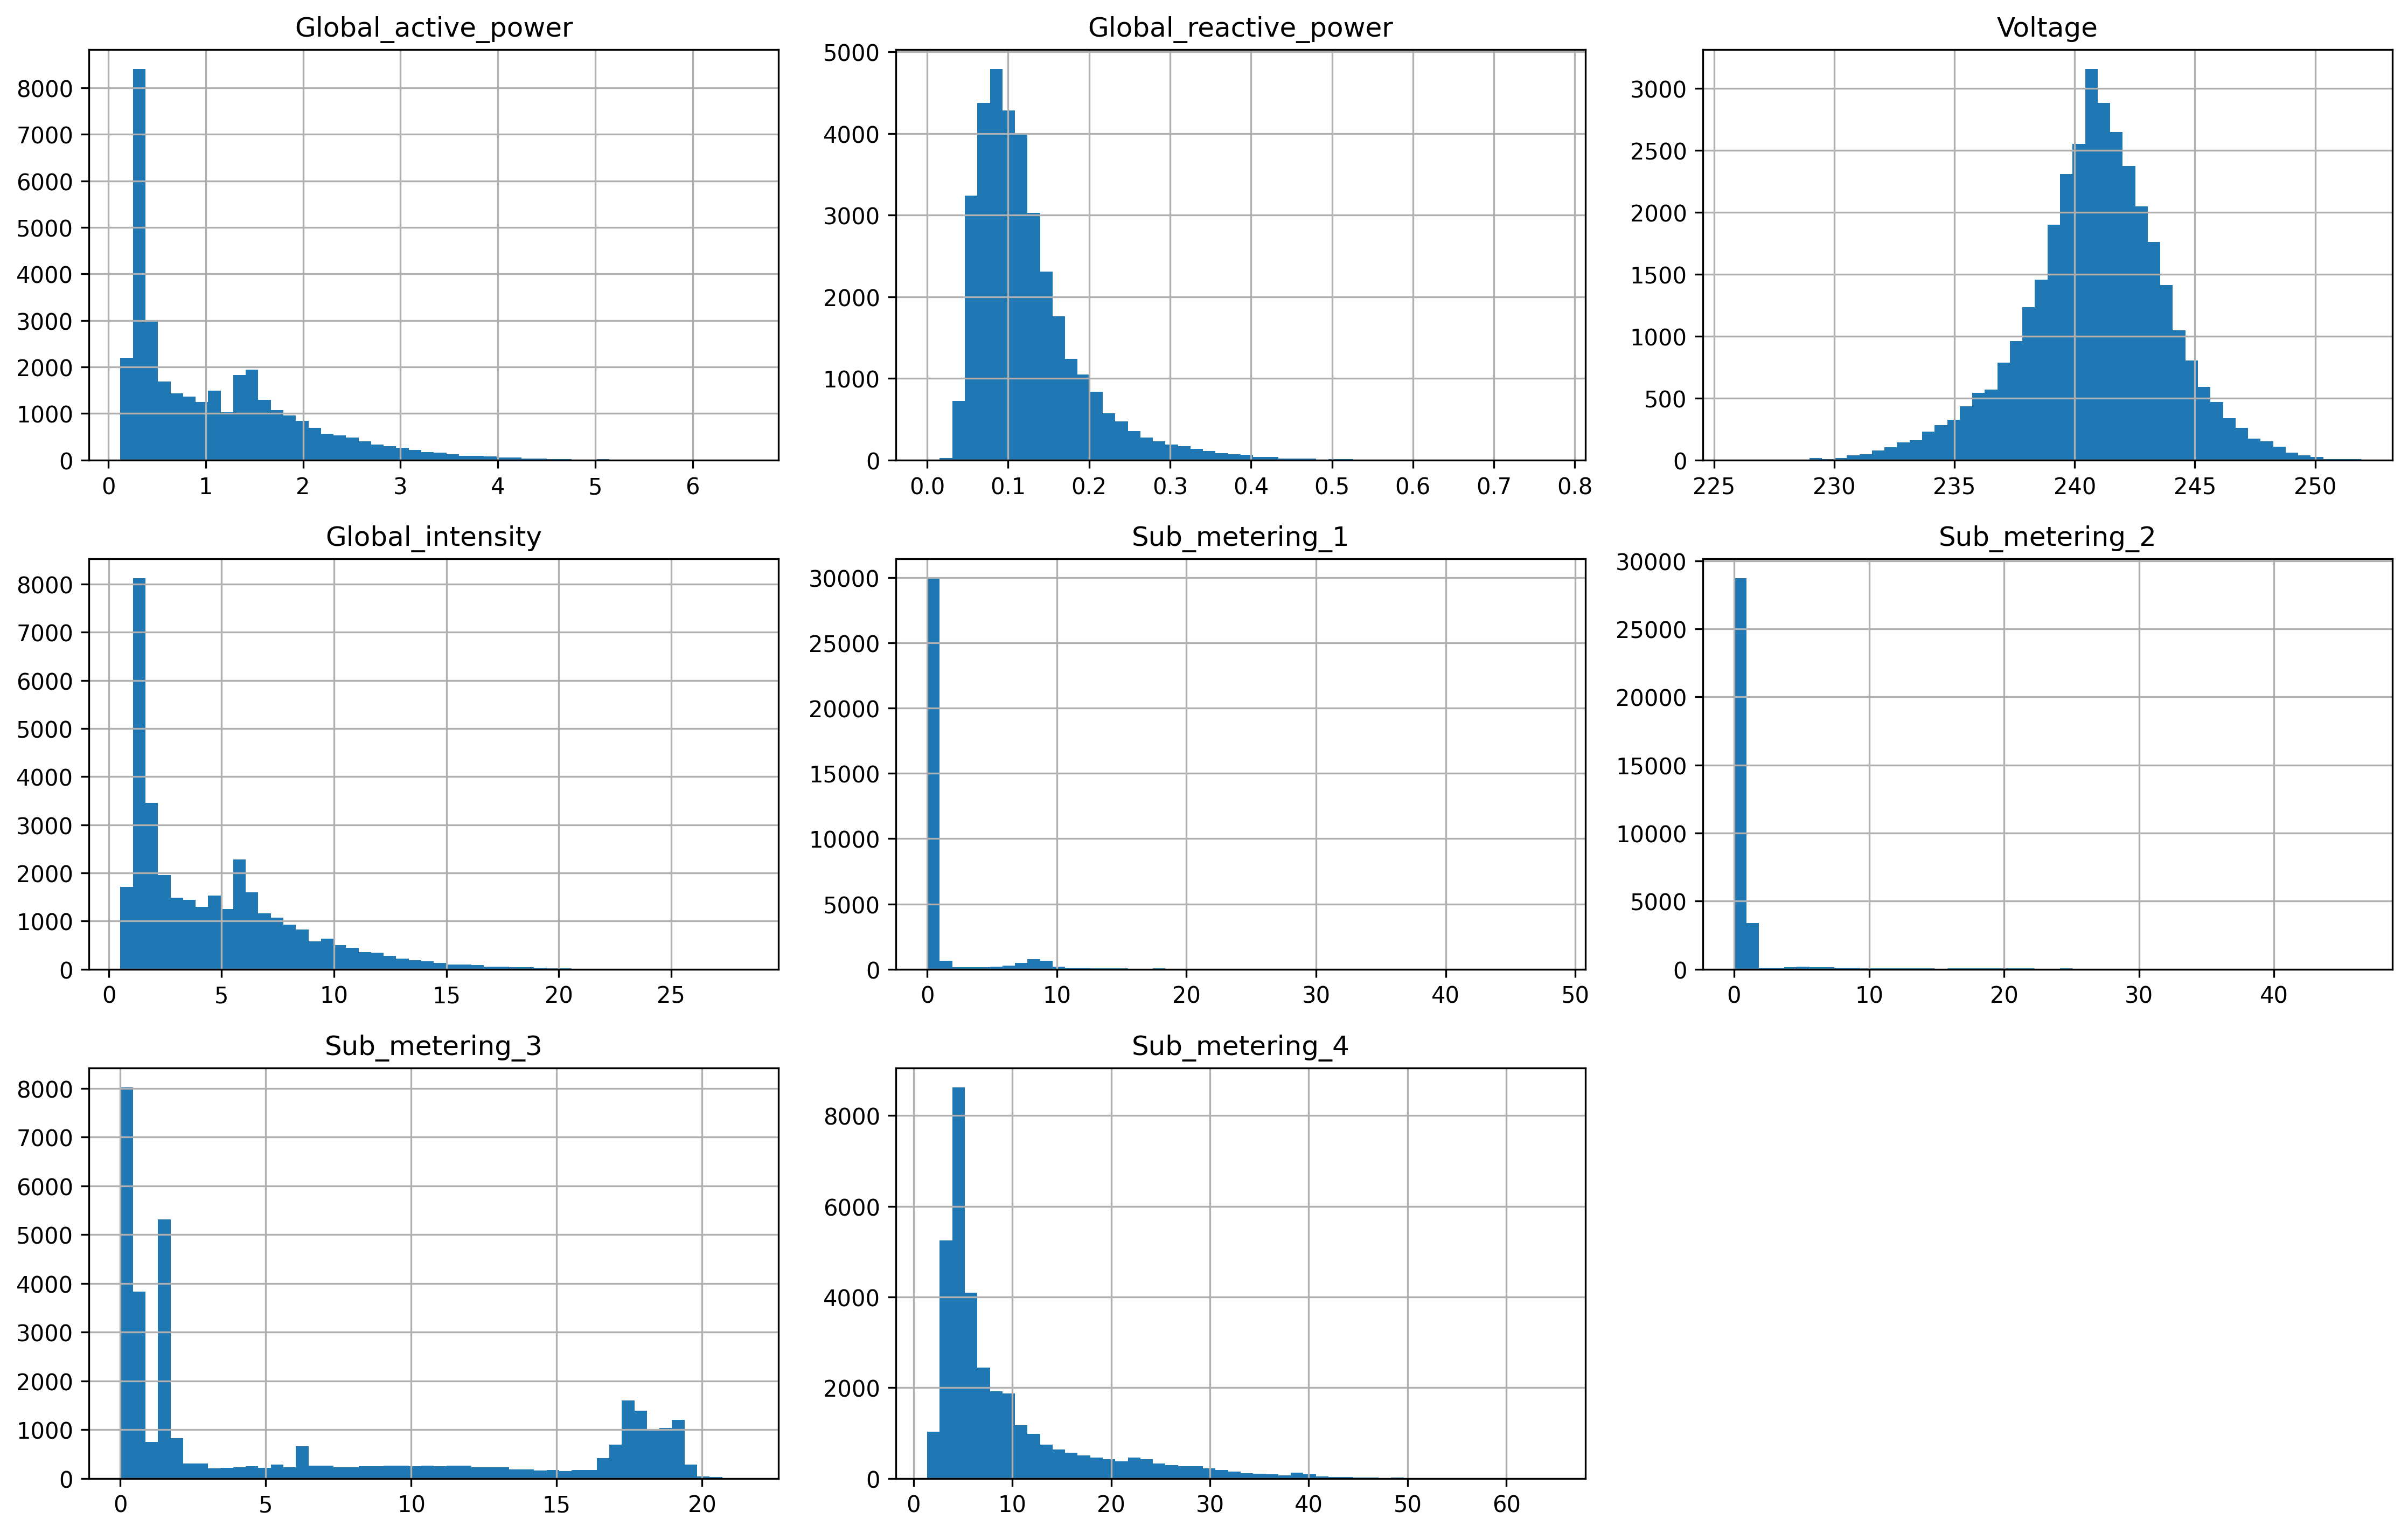

 

************************************************ Correlation Plot for Hourly Resampled Data **************************************************



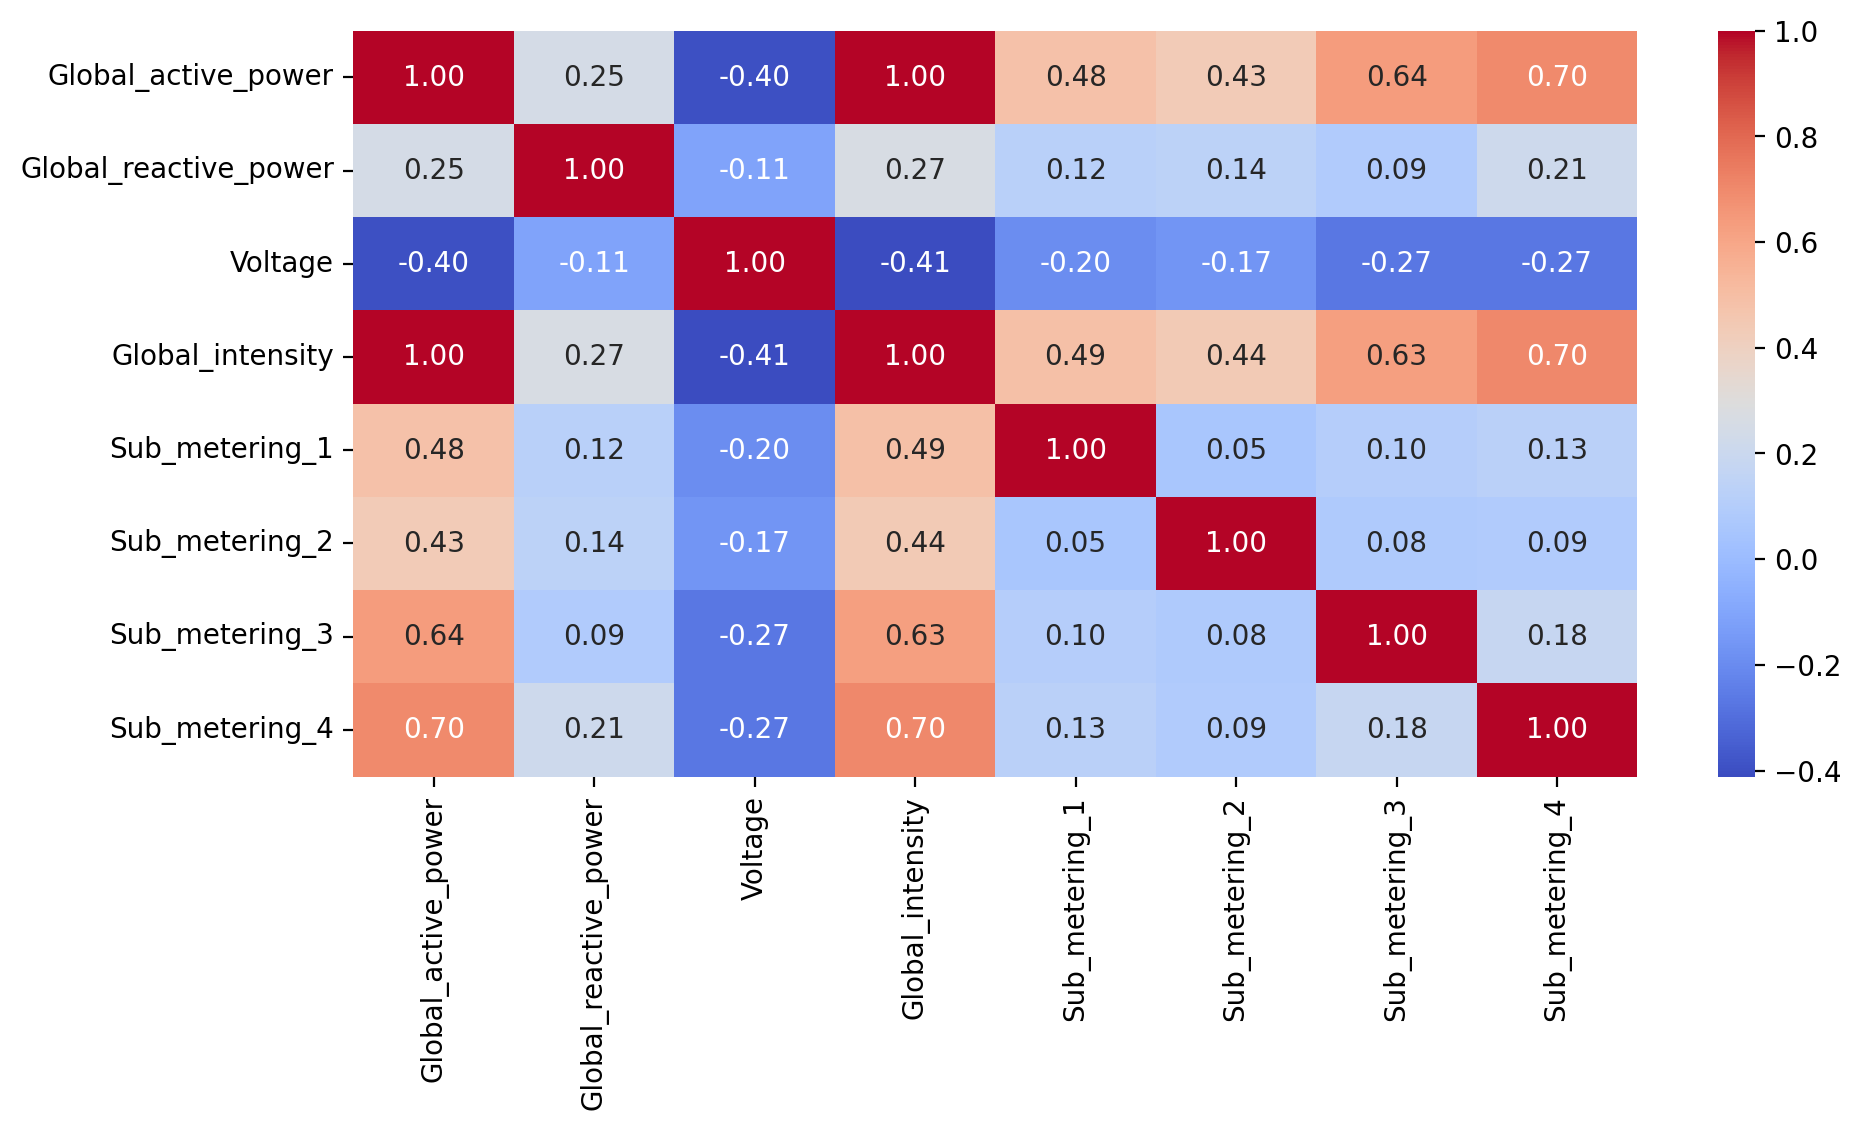

In [43]:
# Plot the visualization, distribution and correlation of Hourly resampled data
df_visu_dist_corr(df_imputed, "H", "Hourly")

Note:- As Global_intensity and Sub_metering_4 are highly correlated with Global_active_power so I am removing Global_intensity column

In [44]:
df1 = hourly_resampled.drop(['Global_intensity', 'Sub_metering_4'], axis=1)
df1 = df1.Global_active_power
df1 = pd.DataFrame(df1)
df1

Global_active_power
date_time                               
2006-12-16 17:00:00             4.222889
2006-12-16 18:00:00             3.632200
2006-12-16 19:00:00             3.400233
2006-12-16 20:00:00             3.268567
2006-12-16 21:00:00             3.056467
...                                  ...
2010-11-26 17:00:00             1.725900
2010-11-26 18:00:00             1.573467
2010-11-26 19:00:00             1.659333
2010-11-26 20:00:00             1.163700
2010-11-26 21:00:00             0.934667

[34589 rows x 1 columns]

# Feature Engineering

In [45]:
# Create new columns for hour, day, quarter, month, and year
#df1['hour'] = hourly_resampled.index.hour
#df1['month'] = hourly_resampled.index.month
#df1['quarter'] = hourly_resampled.index.quarter
#df1['year'] = hourly_resampled.index.year
#df1['week_of_year'] = hourly_resampled.index.isocalendar().week
#df1['day_of_week'] = hourly_resampled.index.dayofweek
#df1['day_of_month'] = hourly_resampled.index.day
#df1['day_of_year'] = hourly_resampled.index.dayofyear
#df1

## Data Normalization

In [46]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df = scaler.fit_transform(df1)

# See the scaled data
scaled_df

array([[0.63681623],
       [0.54504495],
       [0.50900588],
       ...,
       [0.2385342 ],
       [0.16153105],
       [0.12594772]])

# LSTM model-1 Adam(learning_rate=0.0001, epochs=20, batch_size=32)

(27661, 12, 1) (27661,) (6916, 12, 1) (6916,)
Epoch 1/20
865/865 - 8s - 9ms/step - loss: 0.0189 - val_loss: 0.0119
Epoch 2/20
865/865 - 3s - 4ms/step - loss: 0.0152 - val_loss: 0.0106
Epoch 3/20
865/865 - 3s - 4ms/step - loss: 0.0131 - val_loss: 0.0094
Epoch 4/20
865/865 - 4s - 5ms/step - loss: 0.0117 - val_loss: 0.0085
Epoch 5/20
865/865 - 4s - 5ms/step - loss: 0.0111 - val_loss: 0.0081
Epoch 6/20
865/865 - 4s - 5ms/step - loss: 0.0108 - val_loss: 0.0078
Epoch 7/20
865/865 - 4s - 4ms/step - loss: 0.0106 - val_loss: 0.0077
Epoch 8/20
865/865 - 5s - 6ms/step - loss: 0.0105 - val_loss: 0.0076
Epoch 9/20
865/865 - 3s - 4ms/step - loss: 0.0103 - val_loss: 0.0074
Epoch 10/20
865/865 - 5s - 6ms/step - loss: 0.0103 - val_loss: 0.0075
Epoch 11/20
865/865 - 5s - 6ms/step - loss: 0.0101 - val_loss: 0.0074
Epoch 12/20
865/865 - 3s - 4ms/step - loss: 0.0101 - val_loss: 0.0074
Epoch 13/20
865/865 - 6s - 7ms/step - loss: 0.0101 - val_loss: 0.0073
Epoch 14/20
865/865 - 5s - 6ms/step - loss: 0.0101 - 

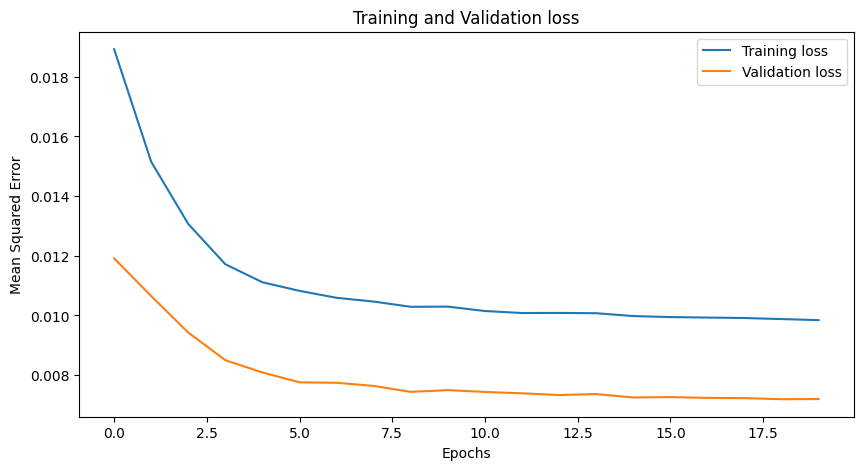

865/865 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Train MAE: 0.479
Train MSE: 0.408
Train RMSE: 0.639
Train R² score: 0.526

Test MAE: 0.419
Test MSE: 0.298
Test RMSE: 0.546
Test R² score: 0.431


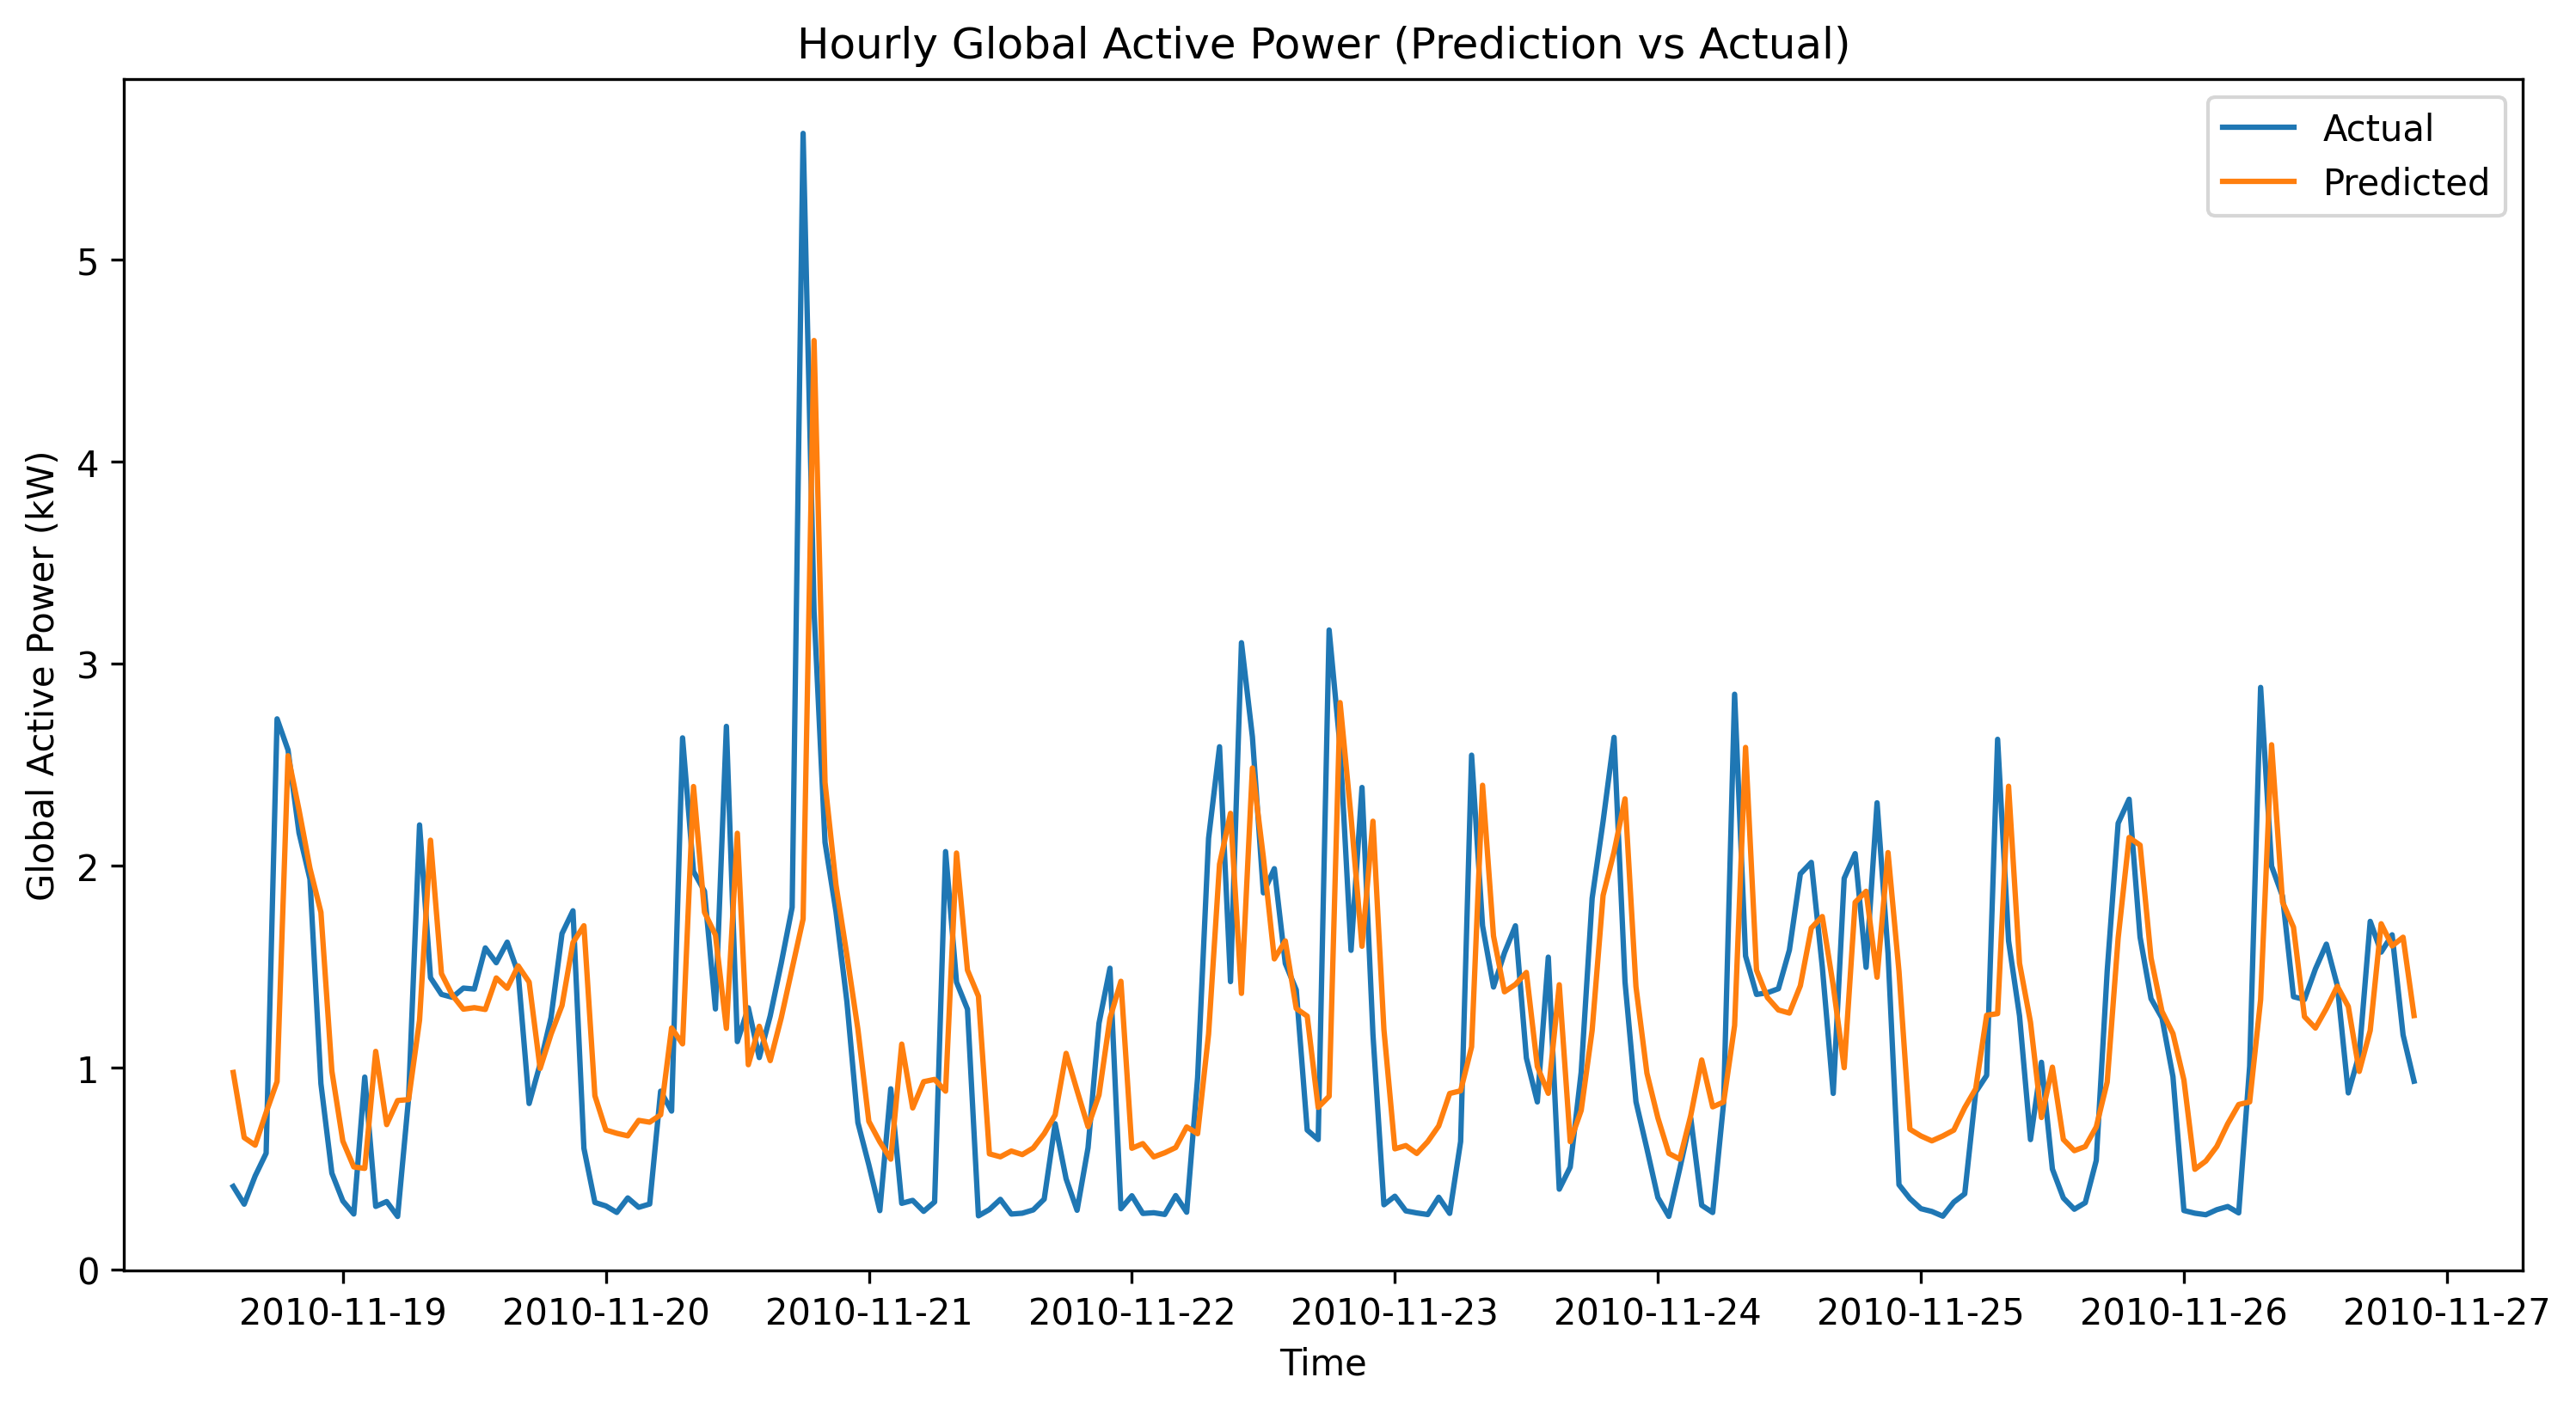

In [47]:
# Define sequence length and features
sequence_length = 12             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df) - sequence_length):
    seq = scaled_df[i:i+sequence_length]
    label = scaled_df[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Fit the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# Plot the training and validation loss (MSE)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
y_train_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_y_train = scaler.inverse_transform(y_train_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[1], axis=-1)
pred_y_train = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
y_test_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_y_test = scaler.inverse_transform(y_test_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[1], axis=-1)
pred_y_test = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_y_train, pred_y_train):.3f}')
print(f'Train MSE: {mean_squared_error(true_y_train, pred_y_train):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_y_train, pred_y_train)):.3f}')
print(f'Train R² score: {r2_score(true_y_train, pred_y_train):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_y_test, pred_y_test):.3f}')
print(f'Test MSE: {mean_squared_error(true_y_test, pred_y_test):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_y_test, pred_y_test)):.3f}')
print(f'Test R² score: {r2_score(true_y_test, pred_y_test):.3f}')

# Plotting Hourly Global Active Power (Prediction vs Actual)
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_y_test[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_y_test[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

# LSTM model-2 Adam(learning_rate=0.0001, epochs=30, batch_size=64)

Epoch 1/50
109/109 - 2s - 16ms/step - loss: 0.0280 - val_loss: 0.0121
Epoch 2/50
109/109 - 0s - 5ms/step - loss: 0.0197 - val_loss: 0.0117
Epoch 3/50
109/109 - 0s - 4ms/step - loss: 0.0190 - val_loss: 0.0114
Epoch 4/50
109/109 - 1s - 6ms/step - loss: 0.0185 - val_loss: 0.0111
Epoch 5/50
109/109 - 0s - 4ms/step - loss: 0.0179 - val_loss: 0.0108
Epoch 6/50
109/109 - 1s - 6ms/step - loss: 0.0173 - val_loss: 0.0105
Epoch 7/50
109/109 - 0s - 4ms/step - loss: 0.0167 - val_loss: 0.0102
Epoch 8/50
109/109 - 0s - 5ms/step - loss: 0.0163 - val_loss: 0.0100
Epoch 9/50
109/109 - 0s - 4ms/step - loss: 0.0158 - val_loss: 0.0097
Epoch 10/50
109/109 - 1s - 6ms/step - loss: 0.0153 - val_loss: 0.0094
Epoch 11/50
109/109 - 1s - 5ms/step - loss: 0.0149 - val_loss: 0.0092
Epoch 12/50
109/109 - 1s - 6ms/step - loss: 0.0145 - val_loss: 0.0090
Epoch 13/50
109/109 - 1s - 7ms/step - loss: 0.0140 - val_loss: 0.0087
Epoch 14/50
109/109 - 1s - 12ms/step - loss: 0.0136 - val_loss: 0.0085
Epoch 15/50
109/109 - 1s - 

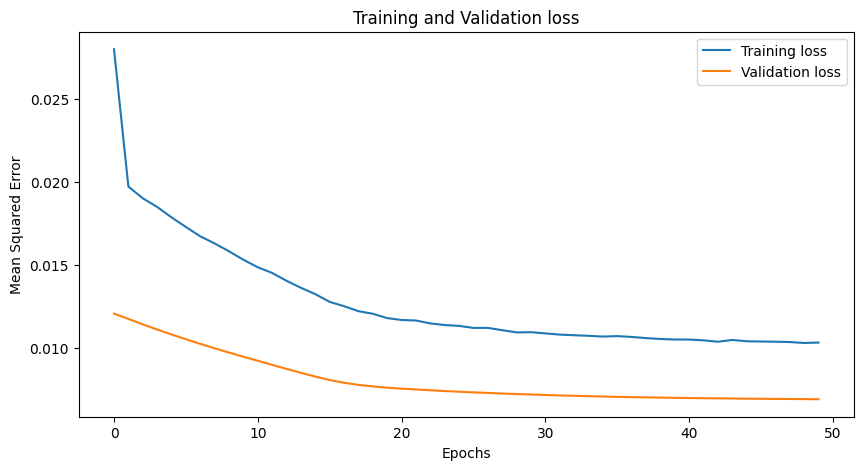

865/865 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Train MAE: 0.454
Train MSE: 0.406
Train RMSE: 0.637
Train R² score: 0.528

Test MAE: 0.386
Test MSE: 0.285
Test RMSE: 0.534
Test R² score: 0.455


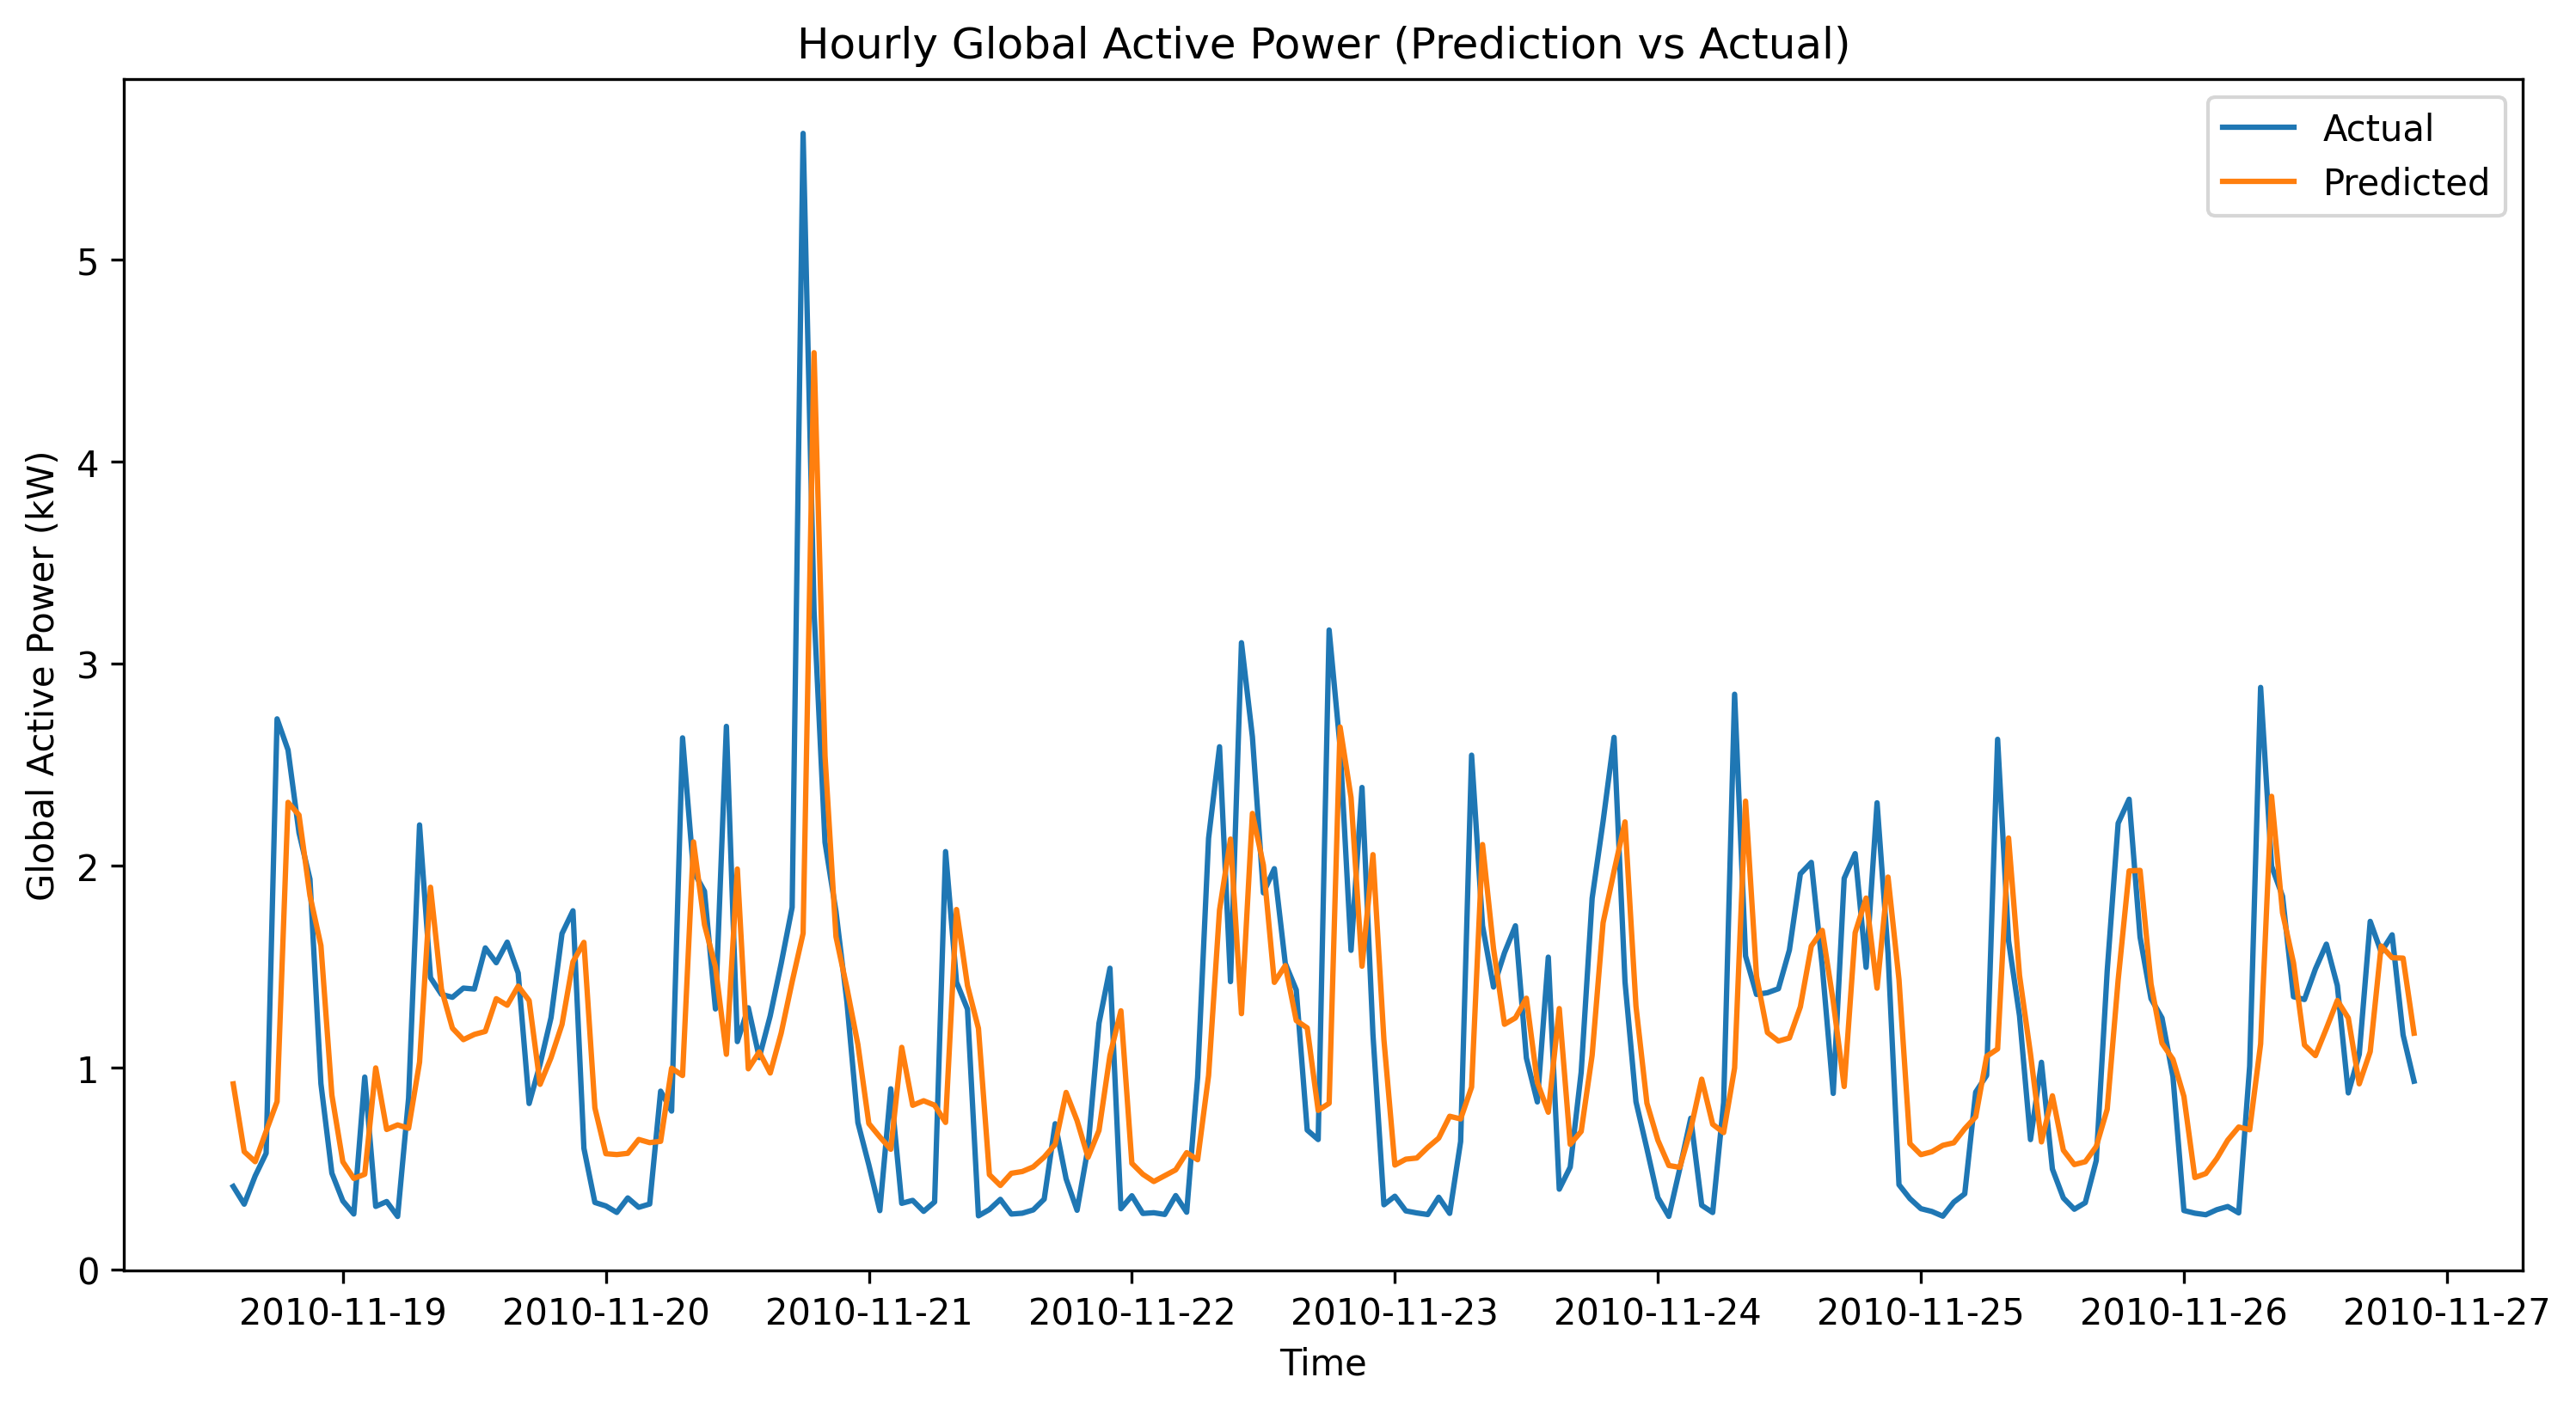

In [48]:
# Define sequence length and features
sequence_length = 12             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df) - sequence_length):
    seq = scaled_df[i:i+sequence_length]
    label = scaled_df[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Fit the model
history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# Plot the training and validation loss (MSE)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
y_train_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_y_train = scaler.inverse_transform(y_train_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[1], axis=-1)
pred_y_train = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
y_test_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_y_test = scaler.inverse_transform(y_test_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[1], axis=-1)
pred_y_test = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_y_train, pred_y_train):.3f}')
print(f'Train MSE: {mean_squared_error(true_y_train, pred_y_train):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_y_train, pred_y_train)):.3f}')
print(f'Train R² score: {r2_score(true_y_train, pred_y_train):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_y_test, pred_y_test):.3f}')
print(f'Test MSE: {mean_squared_error(true_y_test, pred_y_test):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_y_test, pred_y_test)):.3f}')
print(f'Test R² score: {r2_score(true_y_test, pred_y_test):.3f}')

# Plotting Hourly Global Active Power (Prediction vs Actual)
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_y_test[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_y_test[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

# LSTM model-3 Adam(learning_rate=0.0001, epochs=50, batch_size=256)

Epoch 1/50
109/109 - 5s - 44ms/step - loss: 0.0307 - val_loss: 0.0129
Epoch 2/50
109/109 - 1s - 9ms/step - loss: 0.0213 - val_loss: 0.0125
Epoch 3/50
109/109 - 1s - 12ms/step - loss: 0.0204 - val_loss: 0.0121
Epoch 4/50
109/109 - 1s - 8ms/step - loss: 0.0197 - val_loss: 0.0118
Epoch 5/50
109/109 - 1s - 8ms/step - loss: 0.0191 - val_loss: 0.0114
Epoch 6/50
109/109 - 1s - 7ms/step - loss: 0.0184 - val_loss: 0.0111
Epoch 7/50
109/109 - 1s - 10ms/step - loss: 0.0178 - val_loss: 0.0108
Epoch 8/50
109/109 - 1s - 5ms/step - loss: 0.0174 - val_loss: 0.0105
Epoch 9/50
109/109 - 0s - 4ms/step - loss: 0.0168 - val_loss: 0.0102
Epoch 10/50
109/109 - 0s - 4ms/step - loss: 0.0164 - val_loss: 0.0100
Epoch 11/50
109/109 - 1s - 6ms/step - loss: 0.0158 - val_loss: 0.0097
Epoch 12/50
109/109 - 1s - 6ms/step - loss: 0.0153 - val_loss: 0.0094
Epoch 13/50
109/109 - 1s - 8ms/step - loss: 0.0149 - val_loss: 0.0092
Epoch 14/50
109/109 - 1s - 7ms/step - loss: 0.0144 - val_loss: 0.0089
Epoch 15/50
109/109 - 1s -

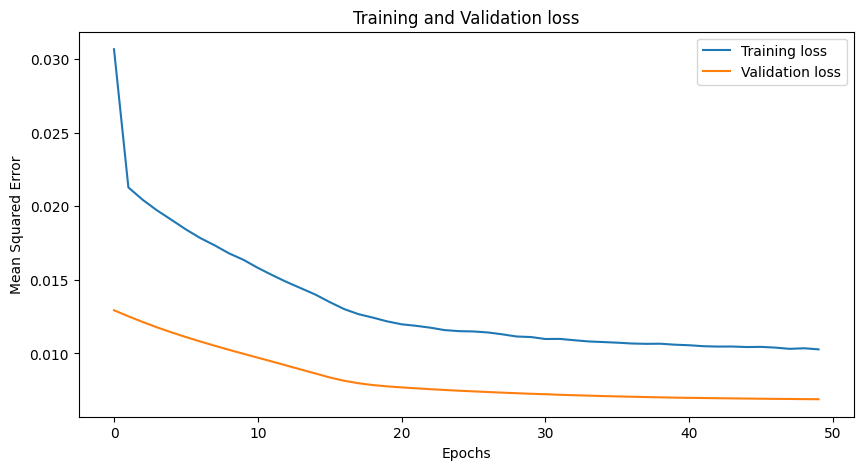

865/865 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Train MAE: 0.454
Train MSE: 0.406
Train RMSE: 0.637
Train R² score: 0.528

Test MAE: 0.386
Test MSE: 0.285
Test RMSE: 0.534
Test R² score: 0.455


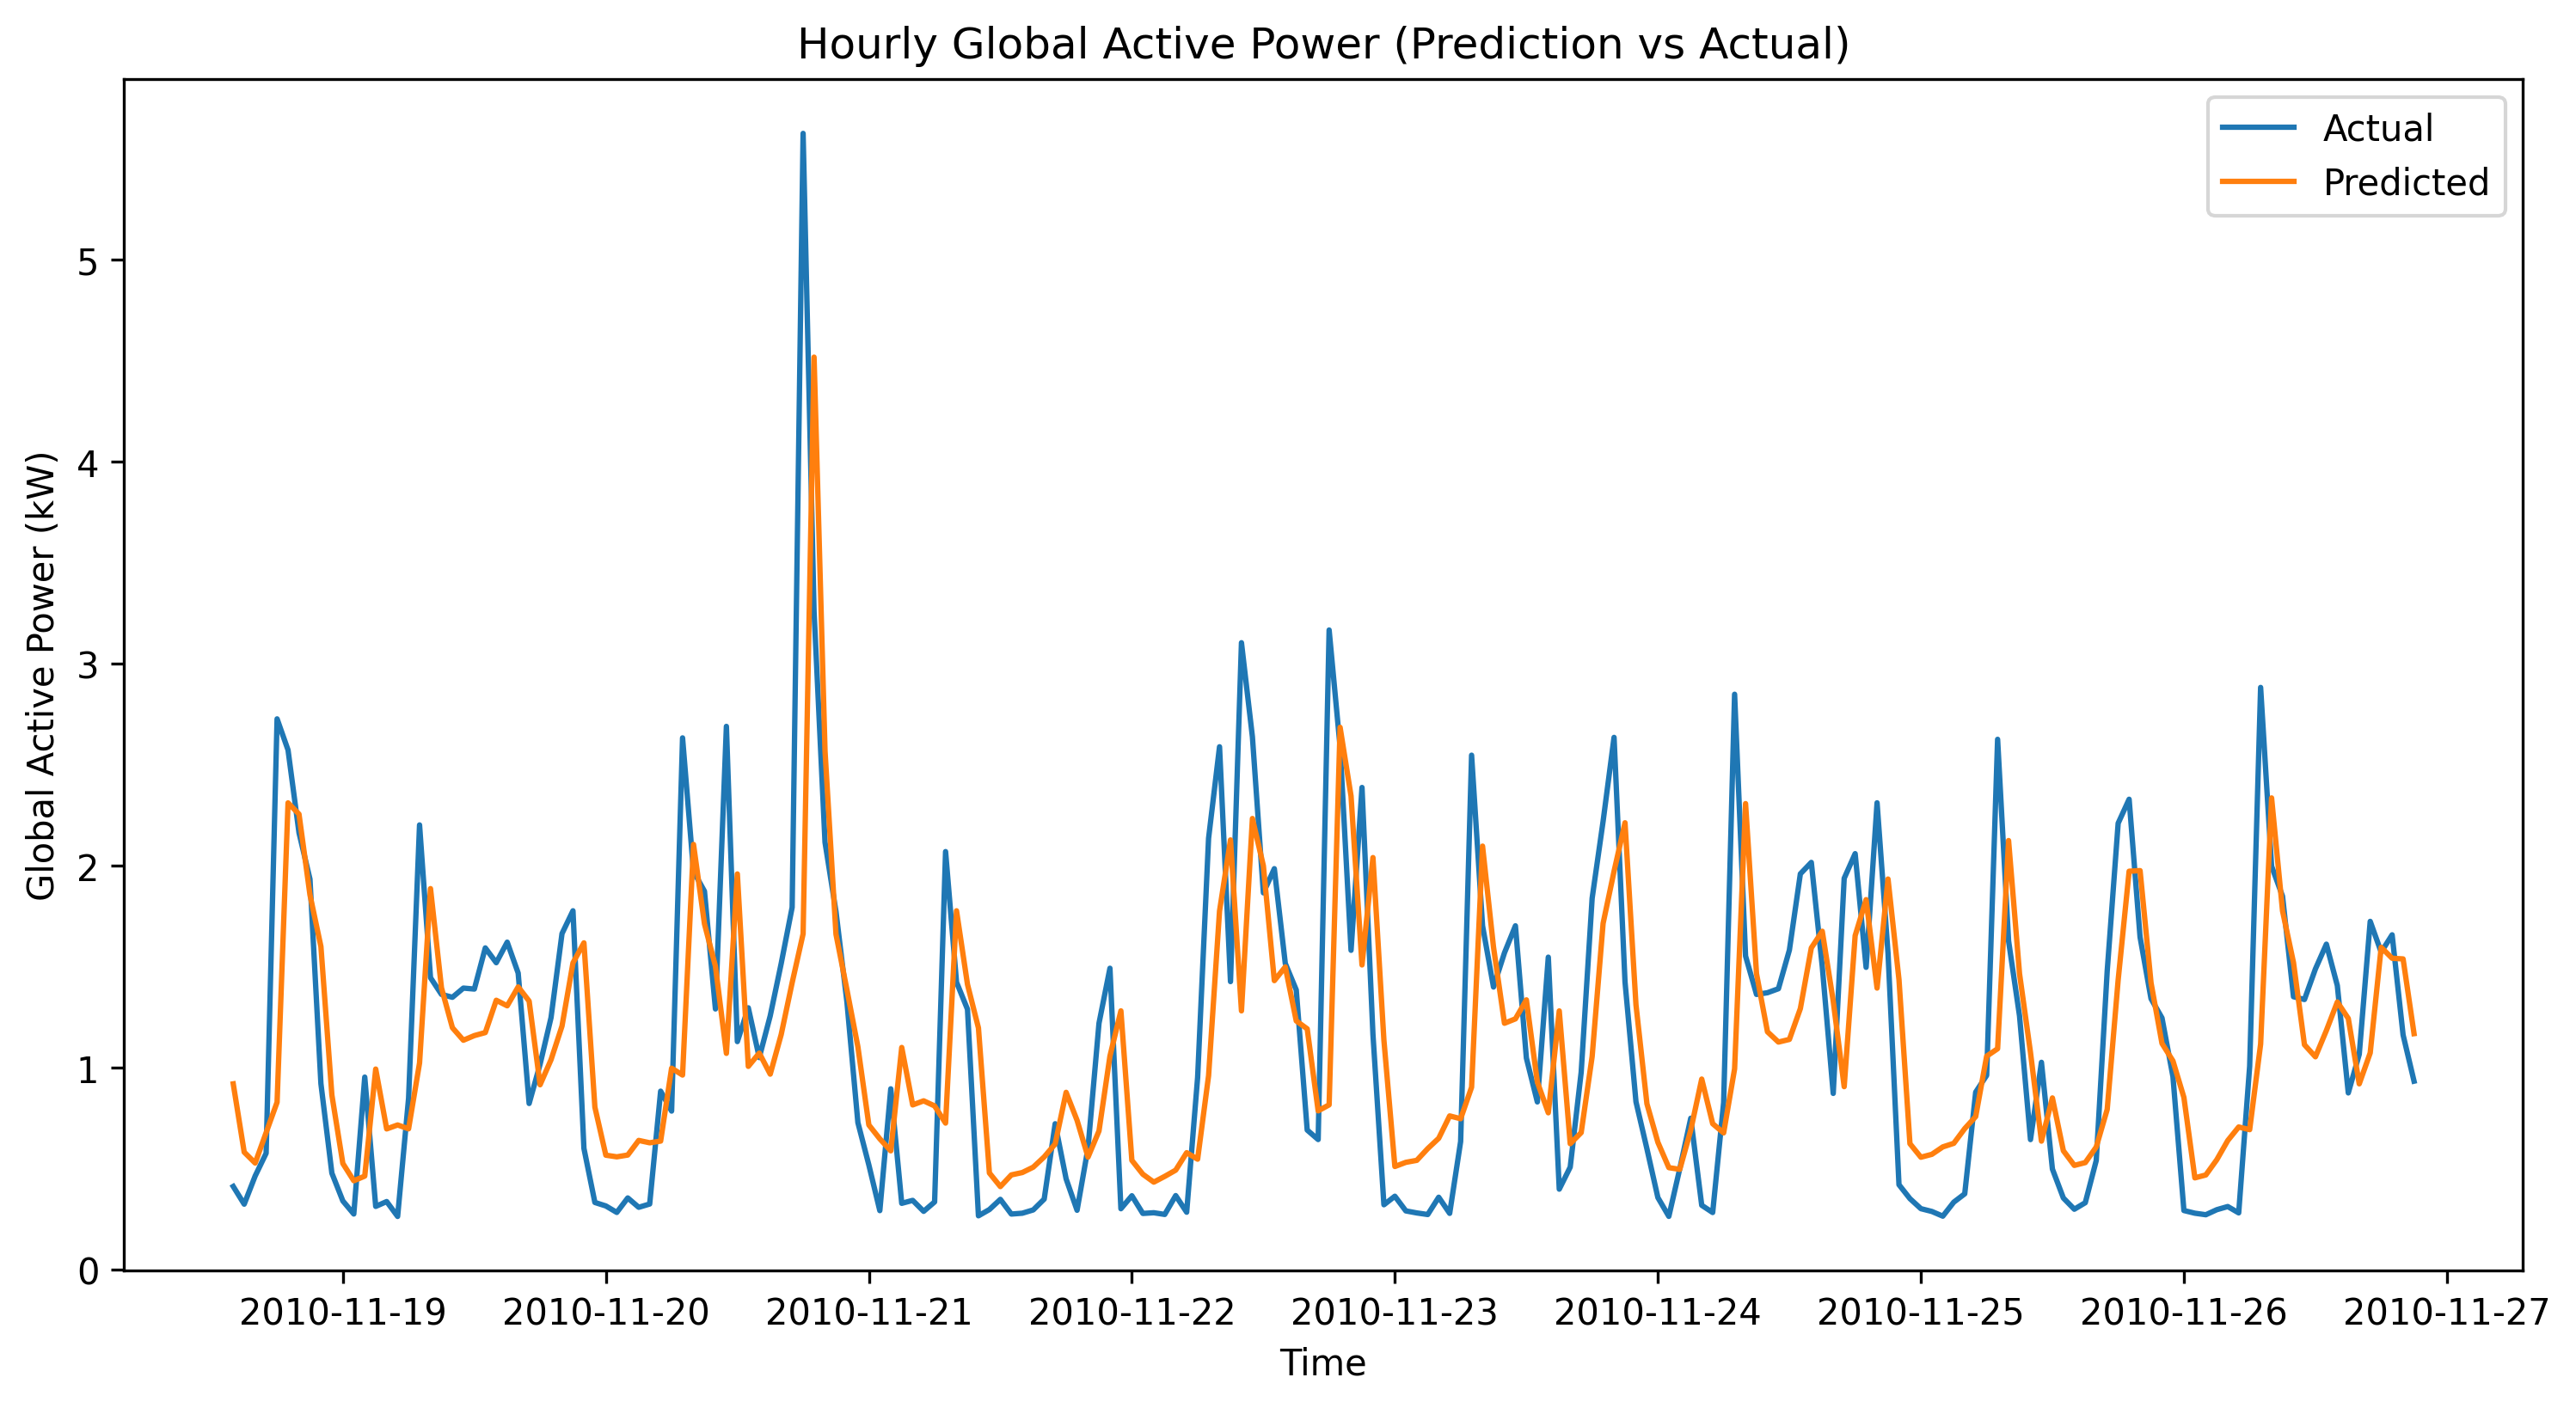

In [49]:
# Define sequence length and features
sequence_length = 12             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df) - sequence_length):
    seq = scaled_df[i:i+sequence_length]
    label = scaled_df[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Fit the model
history = model.fit(X_train, y_train, epochs=50, batch_size=256, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# Plot the training and validation loss (MSE)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
y_train_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_y_train = scaler.inverse_transform(y_train_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[1], axis=-1)
pred_y_train = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
y_test_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_y_test = scaler.inverse_transform(y_test_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[1], axis=-1)
pred_y_test = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_y_train, pred_y_train):.3f}')
print(f'Train MSE: {mean_squared_error(true_y_train, pred_y_train):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_y_train, pred_y_train)):.3f}')
print(f'Train R² score: {r2_score(true_y_train, pred_y_train):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_y_test, pred_y_test):.3f}')
print(f'Test MSE: {mean_squared_error(true_y_test, pred_y_test):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_y_test, pred_y_test)):.3f}')
print(f'Test R² score: {r2_score(true_y_test, pred_y_test):.3f}')

# Plotting Hourly Global Active Power (Prediction vs Actual)
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_y_test[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_y_test[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

# LSTM model-4 Adam(learning_rate=0.0001, epochs=100, batch_size=256)

(27661, 12, 1) (27661,) (6916, 12, 1) (6916,)
Epoch 1/100
109/109 - 2s - 15ms/step - loss: 0.0264 - val_loss: 0.0119
Epoch 2/100
109/109 - 1s - 10ms/step - loss: 0.0197 - val_loss: 0.0116
Epoch 3/100
109/109 - 1s - 6ms/step - loss: 0.0190 - val_loss: 0.0113
Epoch 4/100
109/109 - 0s - 4ms/step - loss: 0.0184 - val_loss: 0.0110
Epoch 5/100
109/109 - 0s - 4ms/step - loss: 0.0179 - val_loss: 0.0107
Epoch 6/100
109/109 - 0s - 4ms/step - loss: 0.0172 - val_loss: 0.0104
Epoch 7/100
109/109 - 1s - 6ms/step - loss: 0.0168 - val_loss: 0.0102
Epoch 8/100
109/109 - 0s - 4ms/step - loss: 0.0163 - val_loss: 0.0099
Epoch 9/100
109/109 - 0s - 4ms/step - loss: 0.0158 - val_loss: 0.0097
Epoch 10/100
109/109 - 1s - 6ms/step - loss: 0.0155 - val_loss: 0.0095
Epoch 11/100
109/109 - 1s - 6ms/step - loss: 0.0150 - val_loss: 0.0092
Epoch 12/100
109/109 - 0s - 4ms/step - loss: 0.0145 - val_loss: 0.0090
Epoch 13/100
109/109 - 1s - 7ms/step - loss: 0.0141 - val_loss: 0.0087
Epoch 14/100
109/109 - 1s - 7ms/step -

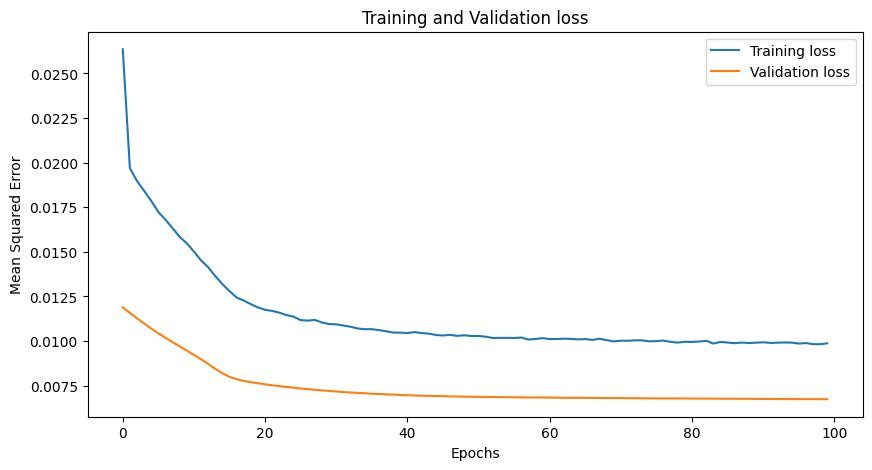

865/865 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Train MAE: 0.437
Train MSE: 0.394
Train RMSE: 0.628
Train R² score: 0.542

Test MAE: 0.376
Test MSE: 0.279
Test RMSE: 0.529
Test R² score: 0.466


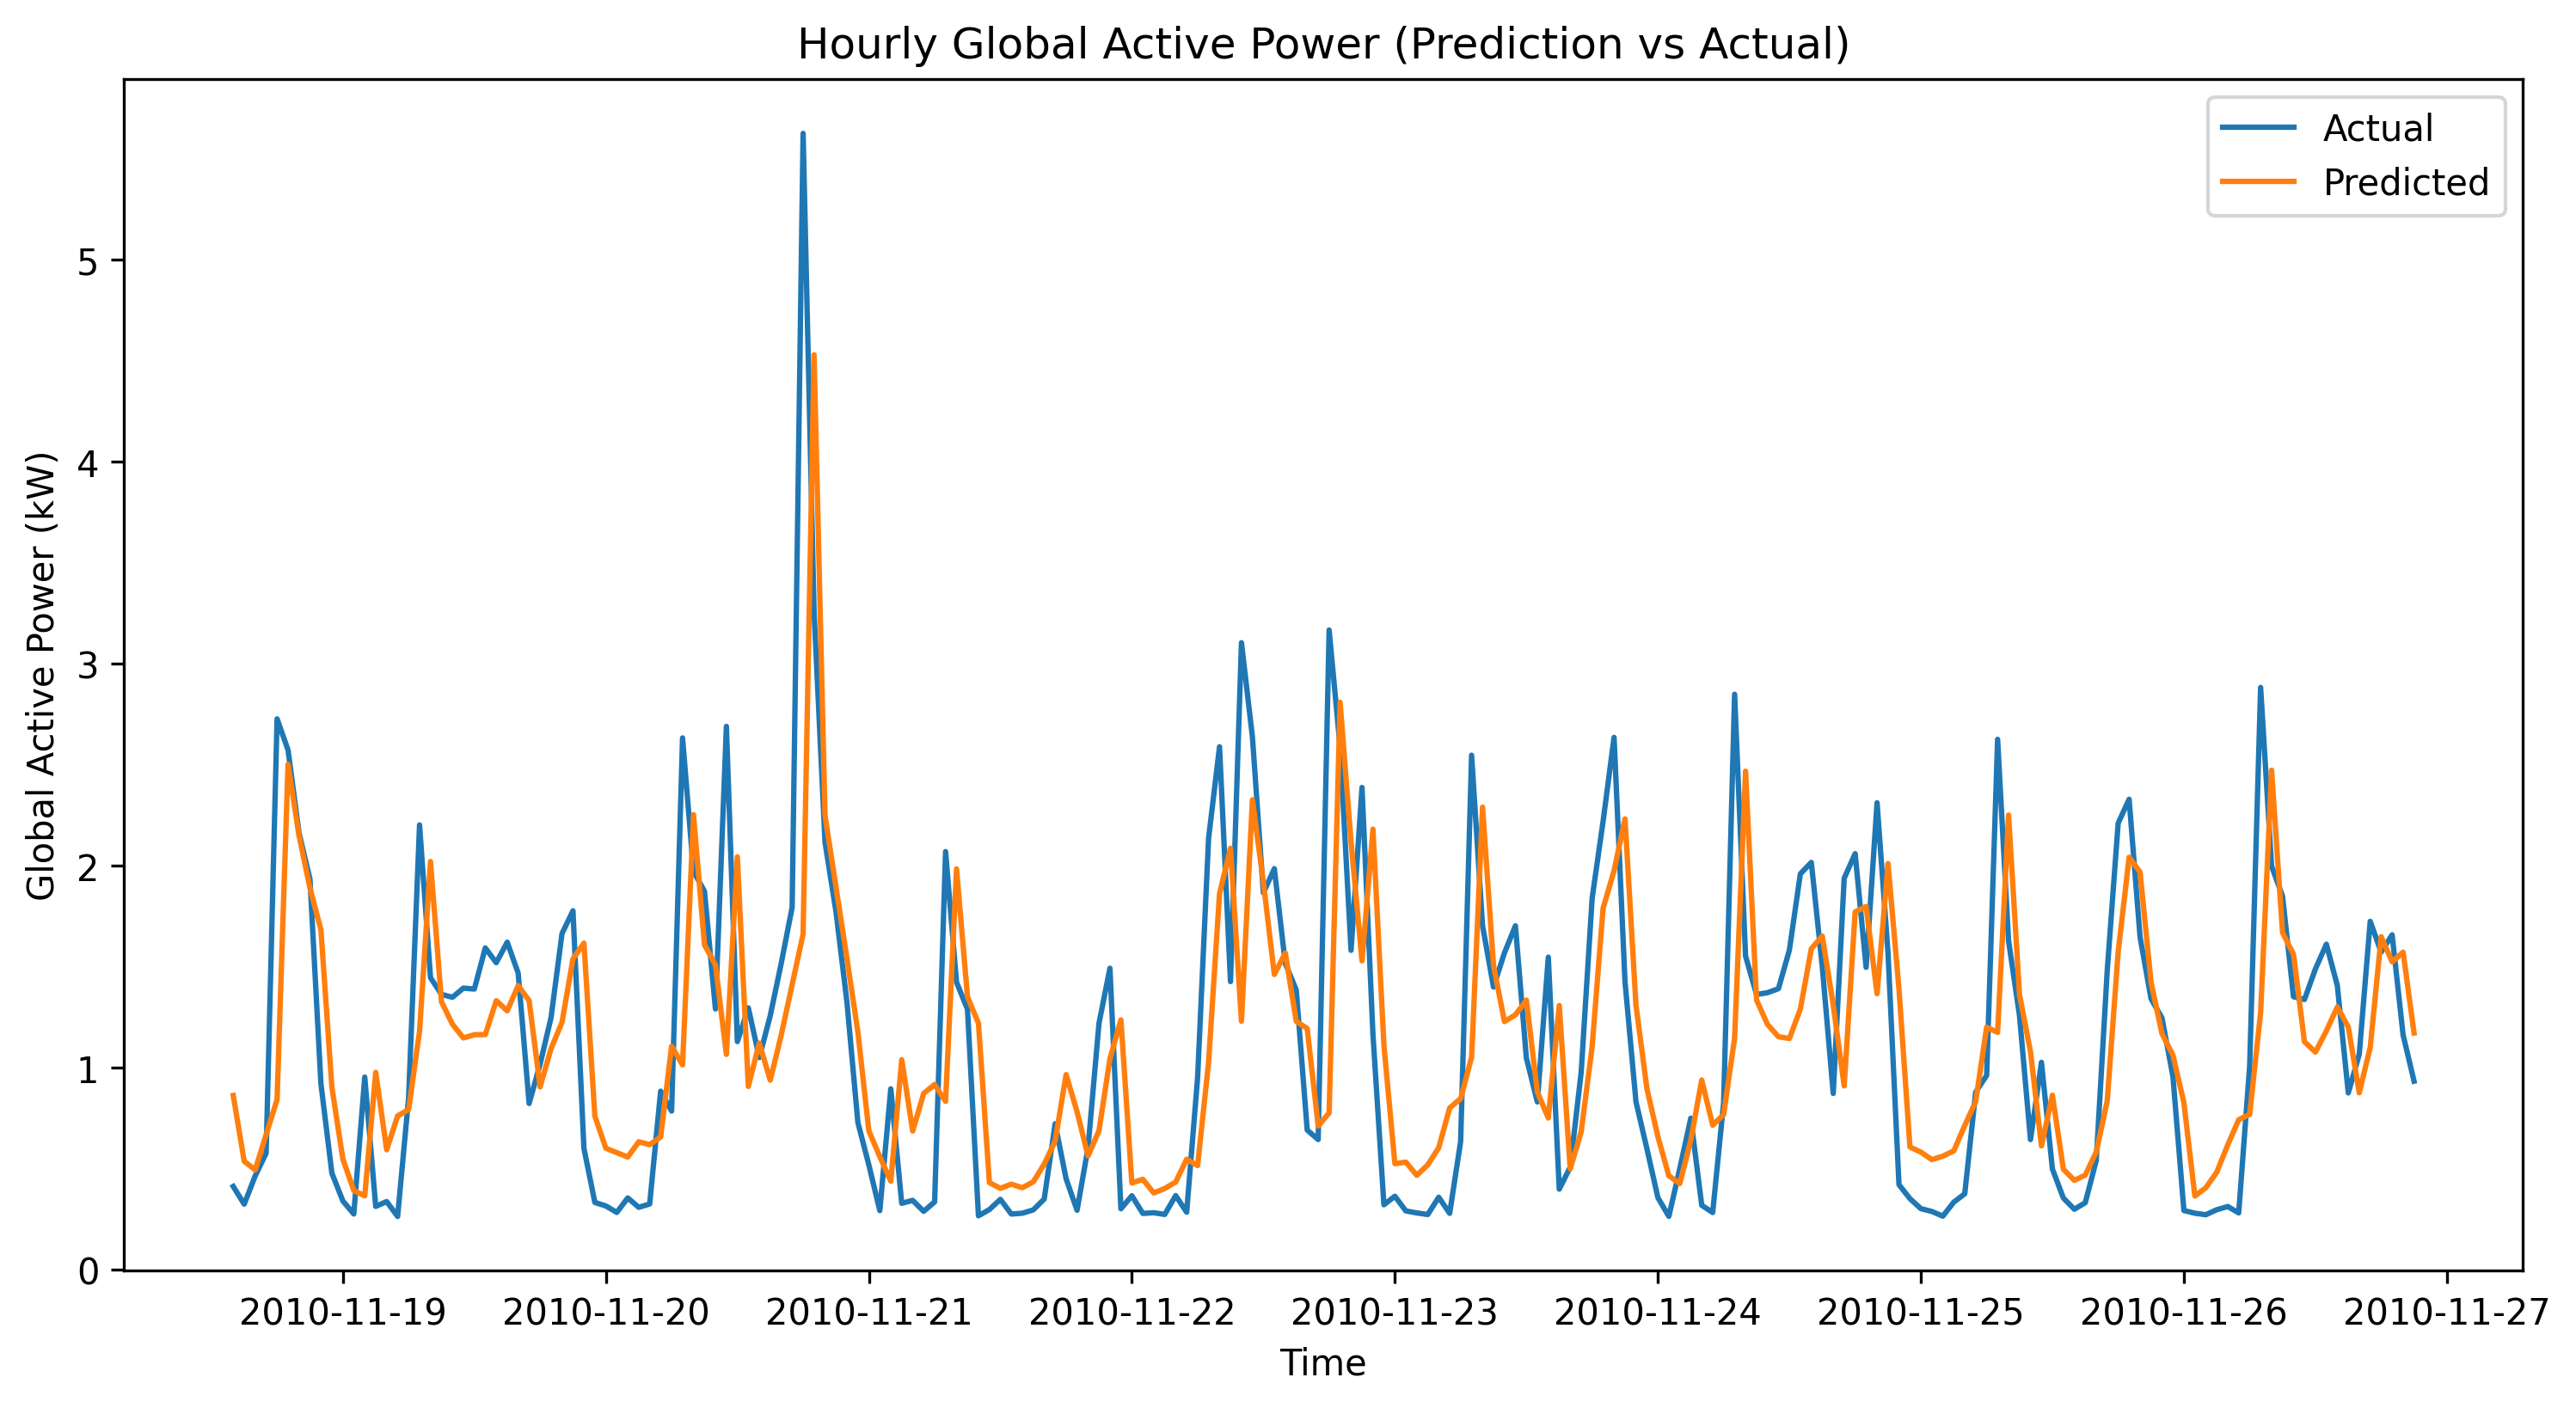

In [50]:
# Define sequence length and features
sequence_length = 12             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df) - sequence_length):
    seq = scaled_df[i:i+sequence_length]
    label = scaled_df[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Fit the model
history = model.fit(X_train, y_train, epochs=100, batch_size=256, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# Plot the training and validation loss (MSE)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
y_train_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_y_train = scaler.inverse_transform(y_train_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[1], axis=-1)
pred_y_train = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
y_test_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_y_test = scaler.inverse_transform(y_test_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[1], axis=-1)
pred_y_test = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_y_train, pred_y_train):.3f}')
print(f'Train MSE: {mean_squared_error(true_y_train, pred_y_train):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_y_train, pred_y_train)):.3f}')
print(f'Train R² score: {r2_score(true_y_train, pred_y_train):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_y_test, pred_y_test):.3f}')
print(f'Test MSE: {mean_squared_error(true_y_test, pred_y_test):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_y_test, pred_y_test)):.3f}')
print(f'Test R² score: {r2_score(true_y_test, pred_y_test):.3f}')

# Plotting Hourly Global Active Power (Prediction vs Actual)
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_y_test[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_y_test[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

# LSTM model-5 SGD(learning_rate=0.0001, epochs=20, batch_size=32)

(27661, 12, 1) (27661,) (6916, 12, 1) (6916,)
Epoch 1/20
865/865 - 6s - 7ms/step - loss: 0.0380 - val_loss: 0.0189
Epoch 2/20
865/865 - 5s - 6ms/step - loss: 0.0272 - val_loss: 0.0145
Epoch 3/20
865/865 - 6s - 7ms/step - loss: 0.0239 - val_loss: 0.0133
Epoch 4/20
865/865 - 9s - 10ms/step - loss: 0.0227 - val_loss: 0.0131
Epoch 5/20
865/865 - 6s - 7ms/step - loss: 0.0222 - val_loss: 0.0131
Epoch 6/20
865/865 - 8s - 10ms/step - loss: 0.0221 - val_loss: 0.0131
Epoch 7/20
865/865 - 3s - 4ms/step - loss: 0.0220 - val_loss: 0.0131
Epoch 8/20
865/865 - 4s - 4ms/step - loss: 0.0219 - val_loss: 0.0131
Epoch 9/20
865/865 - 4s - 5ms/step - loss: 0.0218 - val_loss: 0.0131
Epoch 10/20
865/865 - 4s - 4ms/step - loss: 0.0218 - val_loss: 0.0131
Epoch 11/20
865/865 - 7s - 8ms/step - loss: 0.0217 - val_loss: 0.0131
Epoch 12/20
865/865 - 7s - 9ms/step - loss: 0.0218 - val_loss: 0.0131
Epoch 13/20
865/865 - 8s - 9ms/step - loss: 0.0217 - val_loss: 0.0131
Epoch 14/20
865/865 - 3s - 4ms/step - loss: 0.0216 

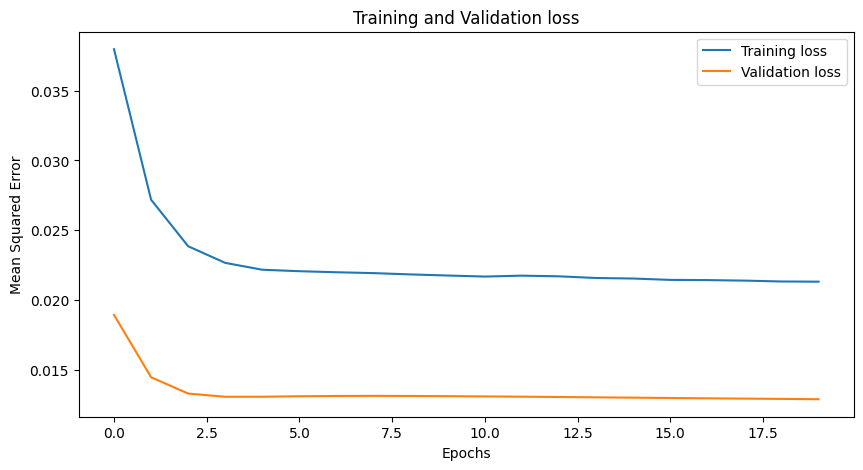

865/865 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Train MAE: 0.750
Train MSE: 0.861
Train RMSE: 0.928
Train R² score: -0.001

Test MAE: 0.610
Test MSE: 0.535
Test RMSE: 0.731
Test R² score: -0.021


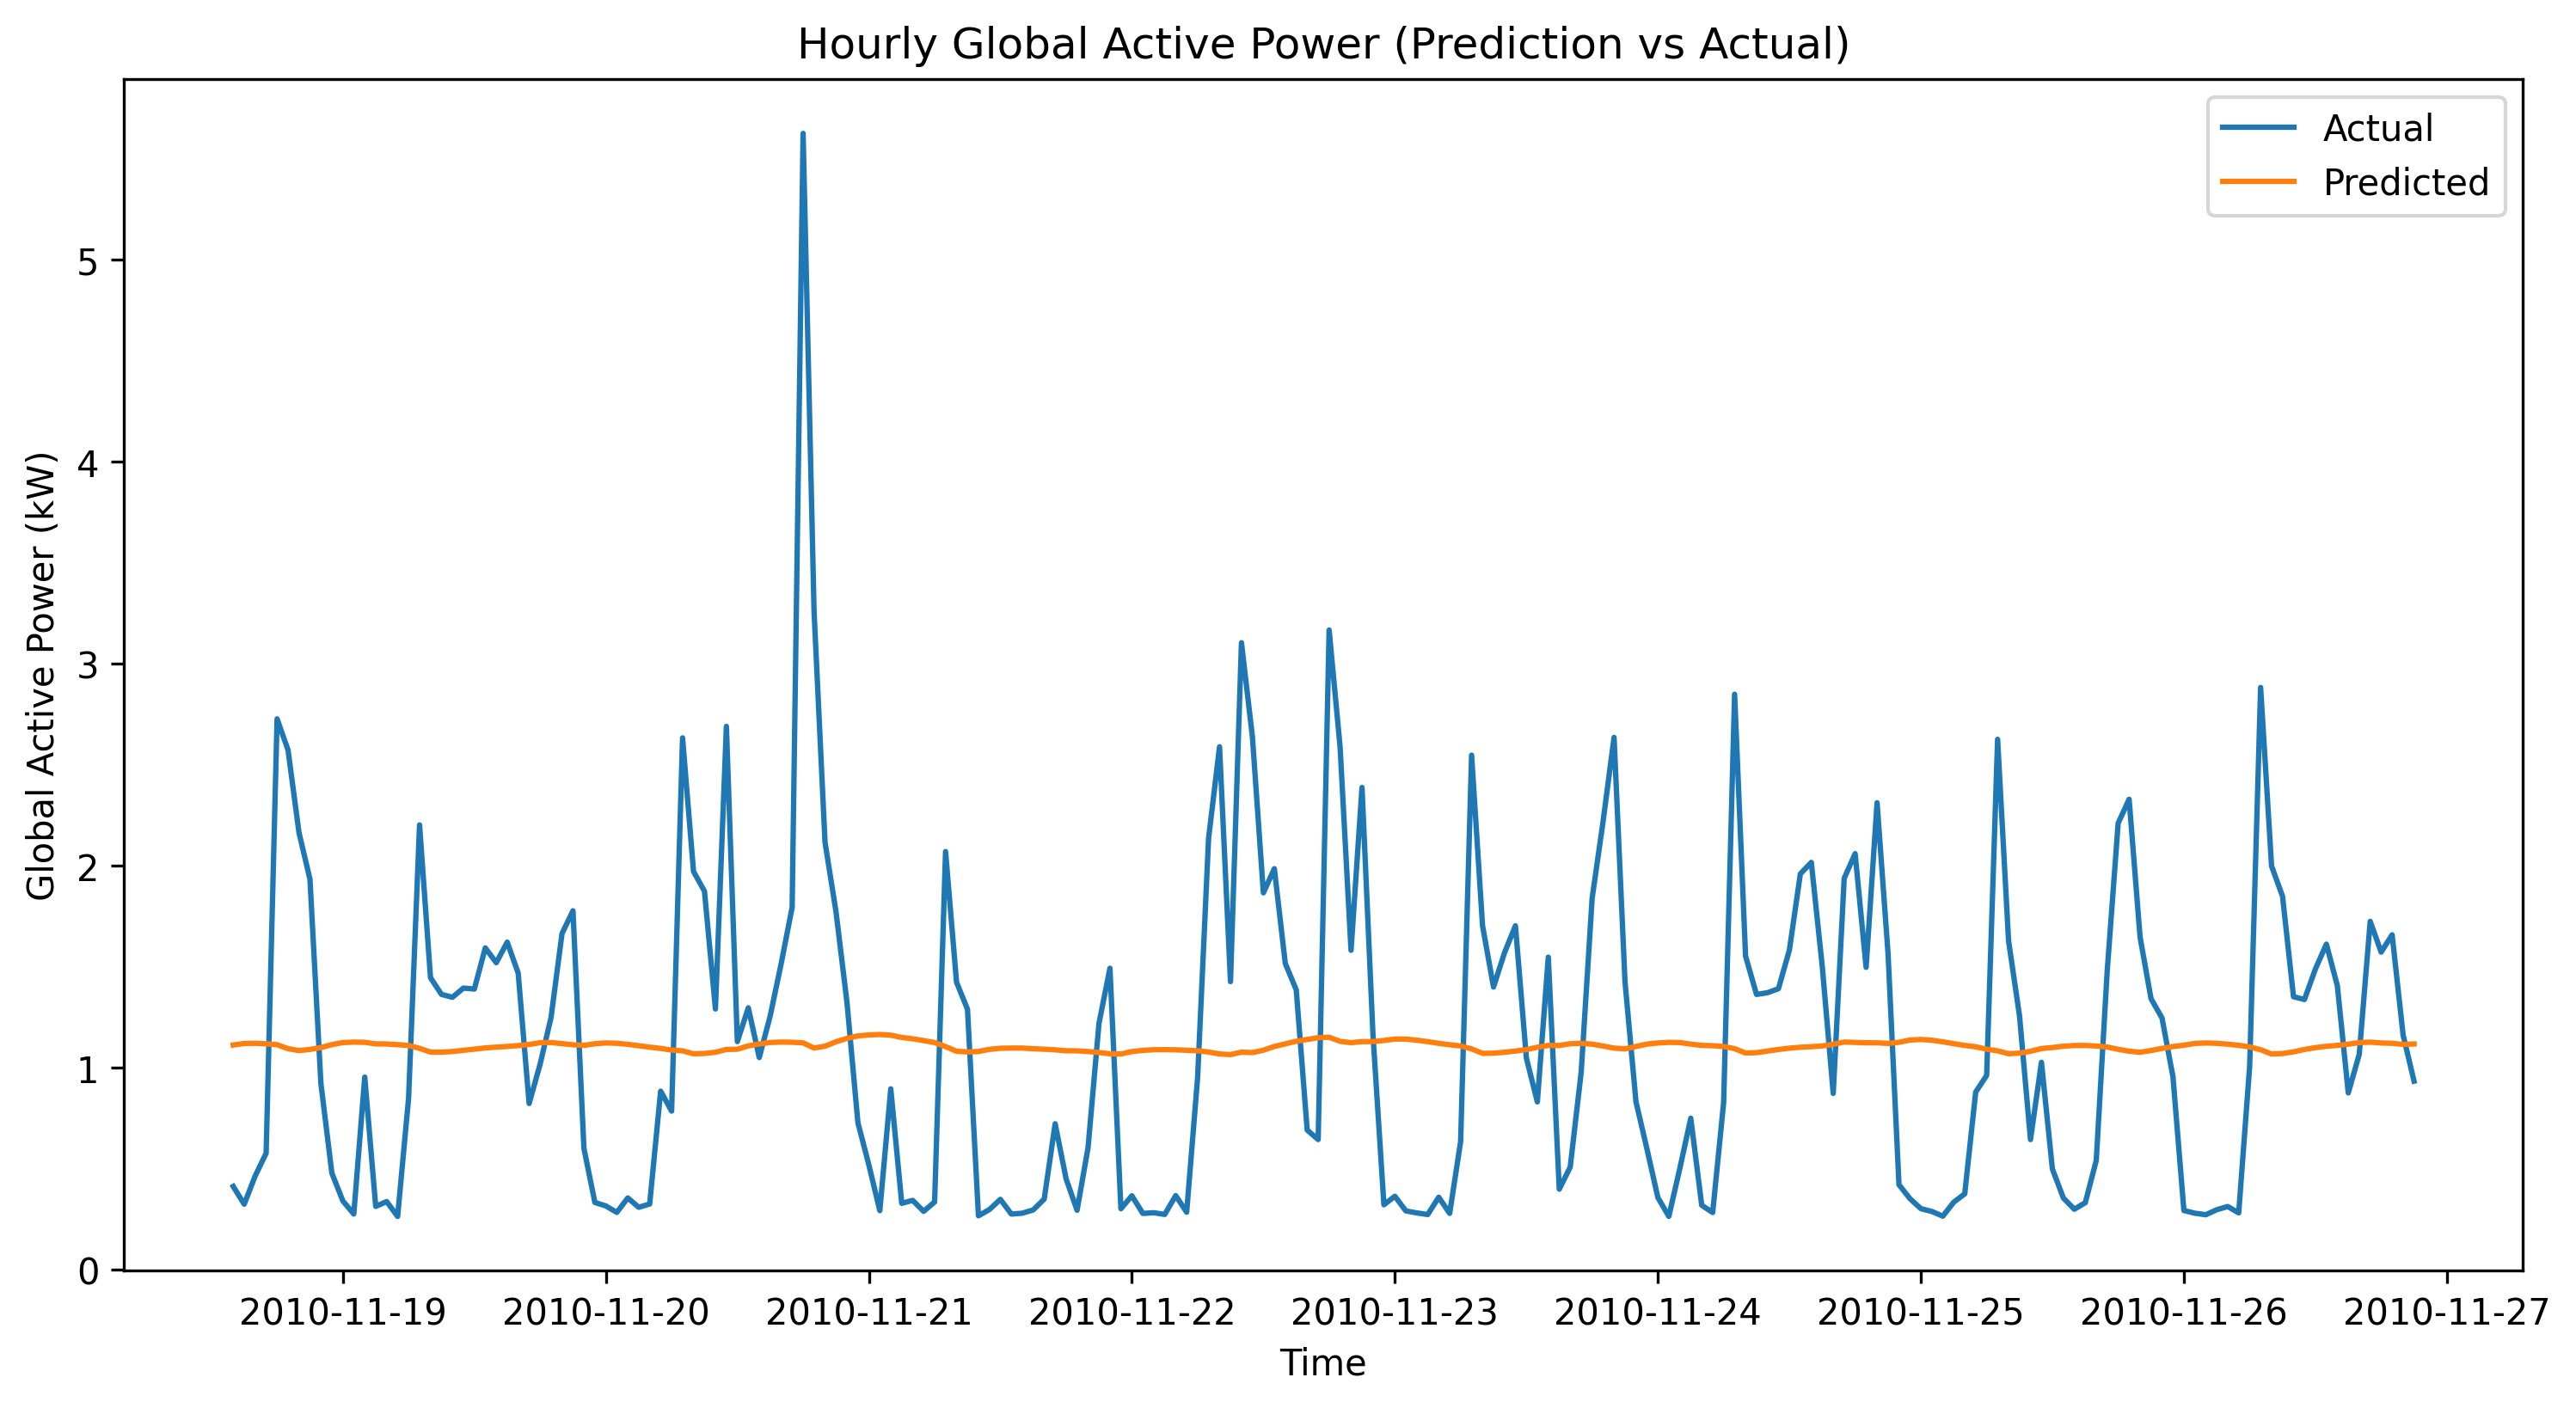

In [54]:
# Define sequence length and features
sequence_length = 12             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df) - sequence_length):
    seq = scaled_df[i:i+sequence_length]
    label = scaled_df[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=SGD(learning_rate=0.0001), loss='mean_squared_error')

# Fit the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# Plot the training and validation loss (MSE)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
y_train_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_y_train = scaler.inverse_transform(y_train_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[1], axis=-1)
pred_y_train = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
y_test_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_y_test = scaler.inverse_transform(y_test_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[1], axis=-1)
pred_y_test = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_y_train, pred_y_train):.3f}')
print(f'Train MSE: {mean_squared_error(true_y_train, pred_y_train):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_y_train, pred_y_train)):.3f}')
print(f'Train R² score: {r2_score(true_y_train, pred_y_train):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_y_test, pred_y_test):.3f}')
print(f'Test MSE: {mean_squared_error(true_y_test, pred_y_test):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_y_test, pred_y_test)):.3f}')
print(f'Test R² score: {r2_score(true_y_test, pred_y_test):.3f}')

# Plotting Hourly Global Active Power (Prediction vs Actual)
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_y_test[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_y_test[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

# LSTM model-6 SGD(learning_rate=0.0001, epochs=30, batch_size=64)

Epoch 1/30
433/433 - 3s - 7ms/step - loss: 0.0399 - val_loss: 0.0232
Epoch 2/30
433/433 - 4s - 9ms/step - loss: 0.0321 - val_loss: 0.0183
Epoch 3/30
433/433 - 1s - 3ms/step - loss: 0.0276 - val_loss: 0.0155
Epoch 4/30
433/433 - 2s - 5ms/step - loss: 0.0249 - val_loss: 0.0141
Epoch 5/30
433/433 - 2s - 5ms/step - loss: 0.0235 - val_loss: 0.0133
Epoch 6/30
433/433 - 2s - 4ms/step - loss: 0.0226 - val_loss: 0.0129
Epoch 7/30
433/433 - 3s - 7ms/step - loss: 0.0220 - val_loss: 0.0127
Epoch 8/30
433/433 - 3s - 6ms/step - loss: 0.0218 - val_loss: 0.0127
Epoch 9/30
433/433 - 4s - 10ms/step - loss: 0.0216 - val_loss: 0.0126
Epoch 10/30
433/433 - 2s - 5ms/step - loss: 0.0215 - val_loss: 0.0126
Epoch 11/30
433/433 - 2s - 5ms/step - loss: 0.0214 - val_loss: 0.0127
Epoch 12/30
433/433 - 2s - 5ms/step - loss: 0.0212 - val_loss: 0.0127
Epoch 13/30
433/433 - 1s - 3ms/step - loss: 0.0212 - val_loss: 0.0127
Epoch 14/30
433/433 - 3s - 6ms/step - loss: 0.0211 - val_loss: 0.0127
Epoch 15/30
433/433 - 2s - 6

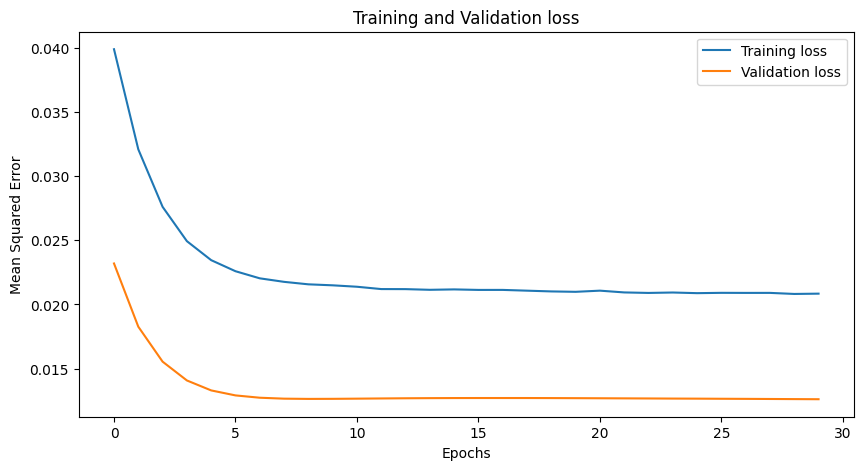

865/865 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Train MAE: 0.739
Train MSE: 0.840
Train RMSE: 0.916
Train R² score: 0.024

Test MAE: 0.602
Test MSE: 0.523
Test RMSE: 0.723
Test R² score: 0.002


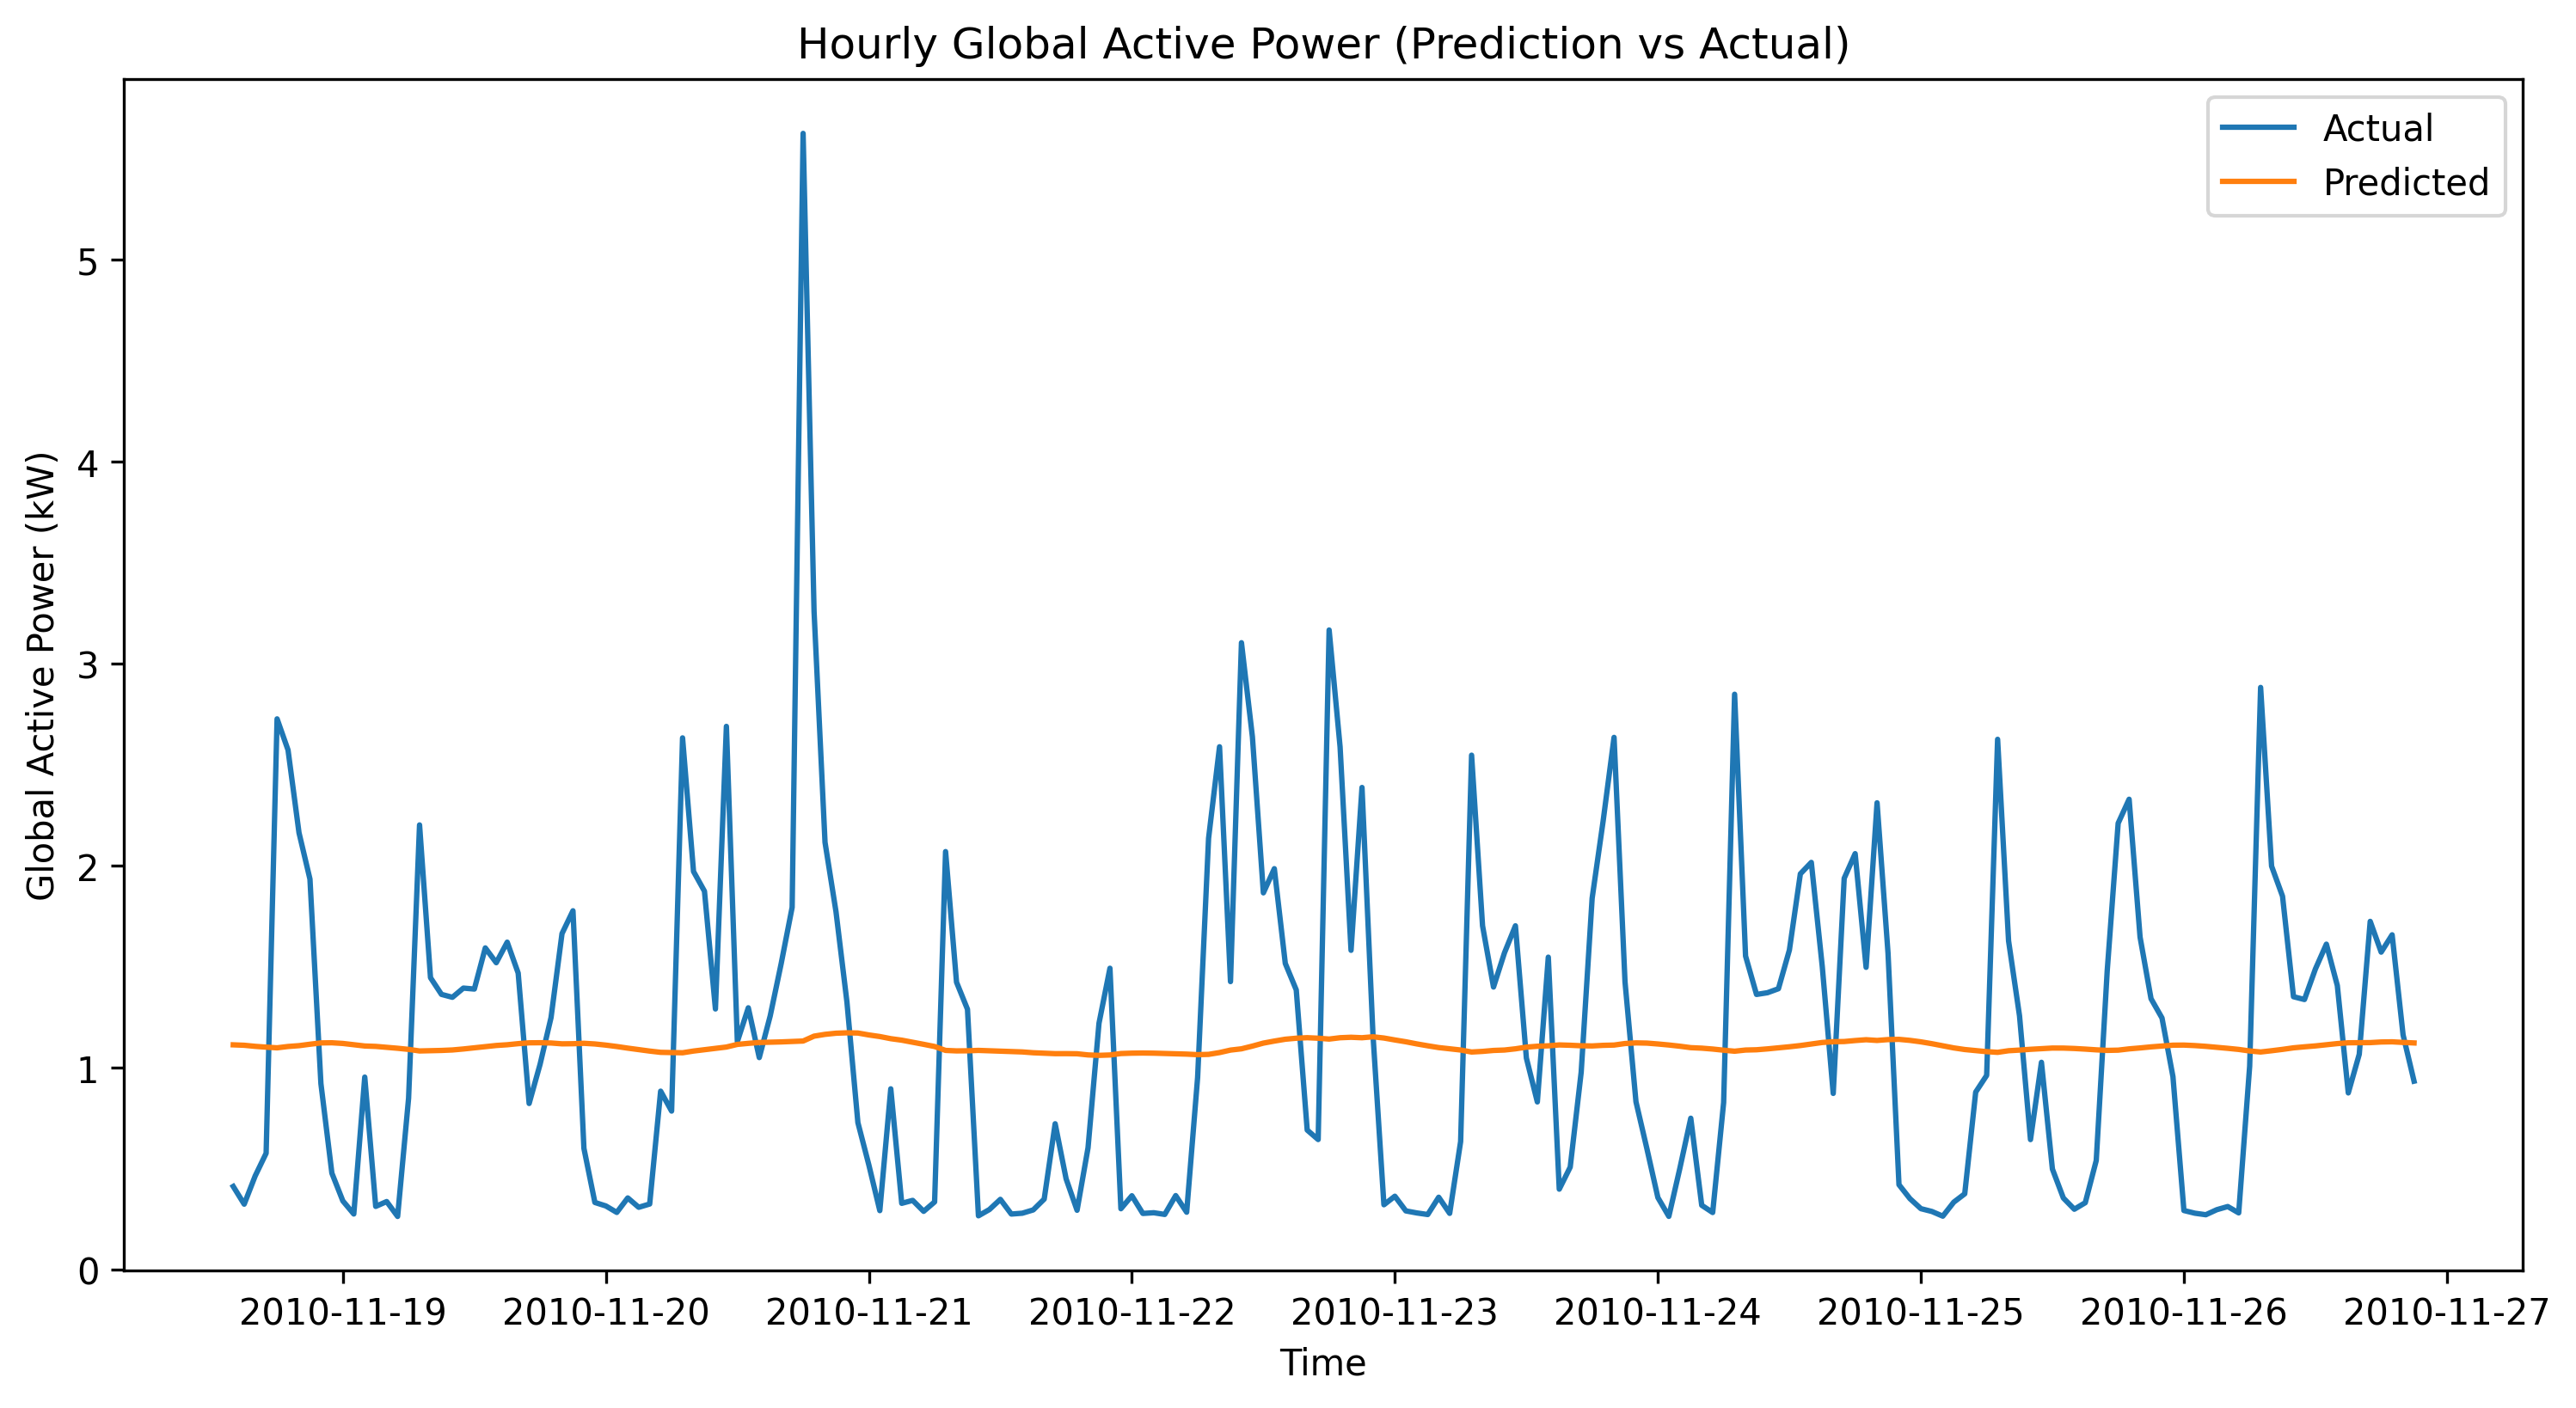

In [55]:
# Define sequence length and features
sequence_length = 12             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df) - sequence_length):
    seq = scaled_df[i:i+sequence_length]
    label = scaled_df[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=SGD(learning_rate=0.0001), loss='mean_squared_error')

# Fit the model
history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# Plot the training and validation loss (MSE)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
y_train_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_y_train = scaler.inverse_transform(y_train_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[1], axis=-1)
pred_y_train = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
y_test_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_y_test = scaler.inverse_transform(y_test_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[1], axis=-1)
pred_y_test = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_y_train, pred_y_train):.3f}')
print(f'Train MSE: {mean_squared_error(true_y_train, pred_y_train):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_y_train, pred_y_train)):.3f}')
print(f'Train R² score: {r2_score(true_y_train, pred_y_train):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_y_test, pred_y_test):.3f}')
print(f'Test MSE: {mean_squared_error(true_y_test, pred_y_test):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_y_test, pred_y_test)):.3f}')
print(f'Test R² score: {r2_score(true_y_test, pred_y_test):.3f}')

# Plotting Hourly Global Active Power (Prediction vs Actual)
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_y_test[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_y_test[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

# LSTM model-7 SGD(learning_rate=0.0001, epochs=50, batch_size=256)

Epoch 1/50
109/109 - 19s - 175ms/step - loss: 0.0275 - val_loss: 0.0120
Epoch 2/50
109/109 - 1s - 6ms/step - loss: 0.0197 - val_loss: 0.0117
Epoch 3/50
109/109 - 0s - 4ms/step - loss: 0.0191 - val_loss: 0.0114
Epoch 4/50
109/109 - 0s - 4ms/step - loss: 0.0186 - val_loss: 0.0112
Epoch 5/50
109/109 - 1s - 6ms/step - loss: 0.0180 - val_loss: 0.0109
Epoch 6/50
109/109 - 1s - 6ms/step - loss: 0.0175 - val_loss: 0.0107
Epoch 7/50
109/109 - 1s - 6ms/step - loss: 0.0171 - val_loss: 0.0104
Epoch 8/50
109/109 - 0s - 4ms/step - loss: 0.0166 - val_loss: 0.0102
Epoch 9/50
109/109 - 1s - 6ms/step - loss: 0.0162 - val_loss: 0.0099
Epoch 10/50
109/109 - 0s - 4ms/step - loss: 0.0158 - val_loss: 0.0097
Epoch 11/50
109/109 - 1s - 6ms/step - loss: 0.0154 - val_loss: 0.0095
Epoch 12/50
109/109 - 0s - 4ms/step - loss: 0.0149 - val_loss: 0.0092
Epoch 13/50
109/109 - 0s - 4ms/step - loss: 0.0145 - val_loss: 0.0090
Epoch 14/50
109/109 - 1s - 6ms/step - loss: 0.0141 - val_loss: 0.0087
Epoch 15/50
109/109 - 0s -

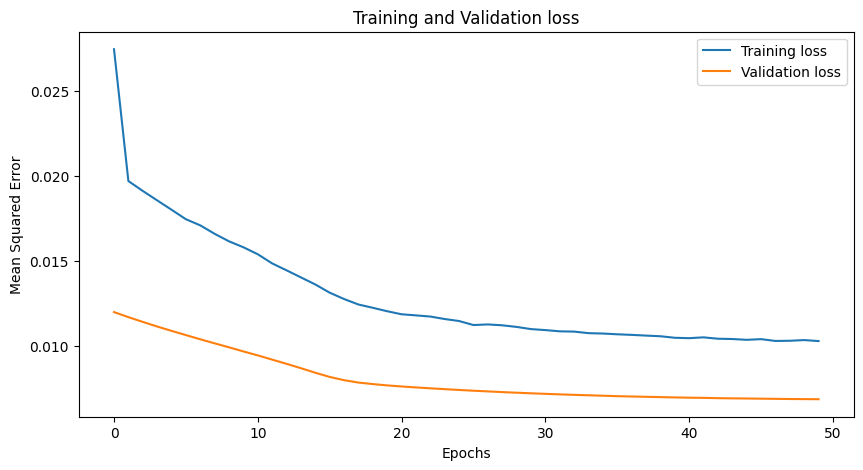

865/865 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Train MAE: 0.453
Train MSE: 0.406
Train RMSE: 0.637
Train R² score: 0.529

Test MAE: 0.386
Test MSE: 0.285
Test RMSE: 0.534
Test R² score: 0.455


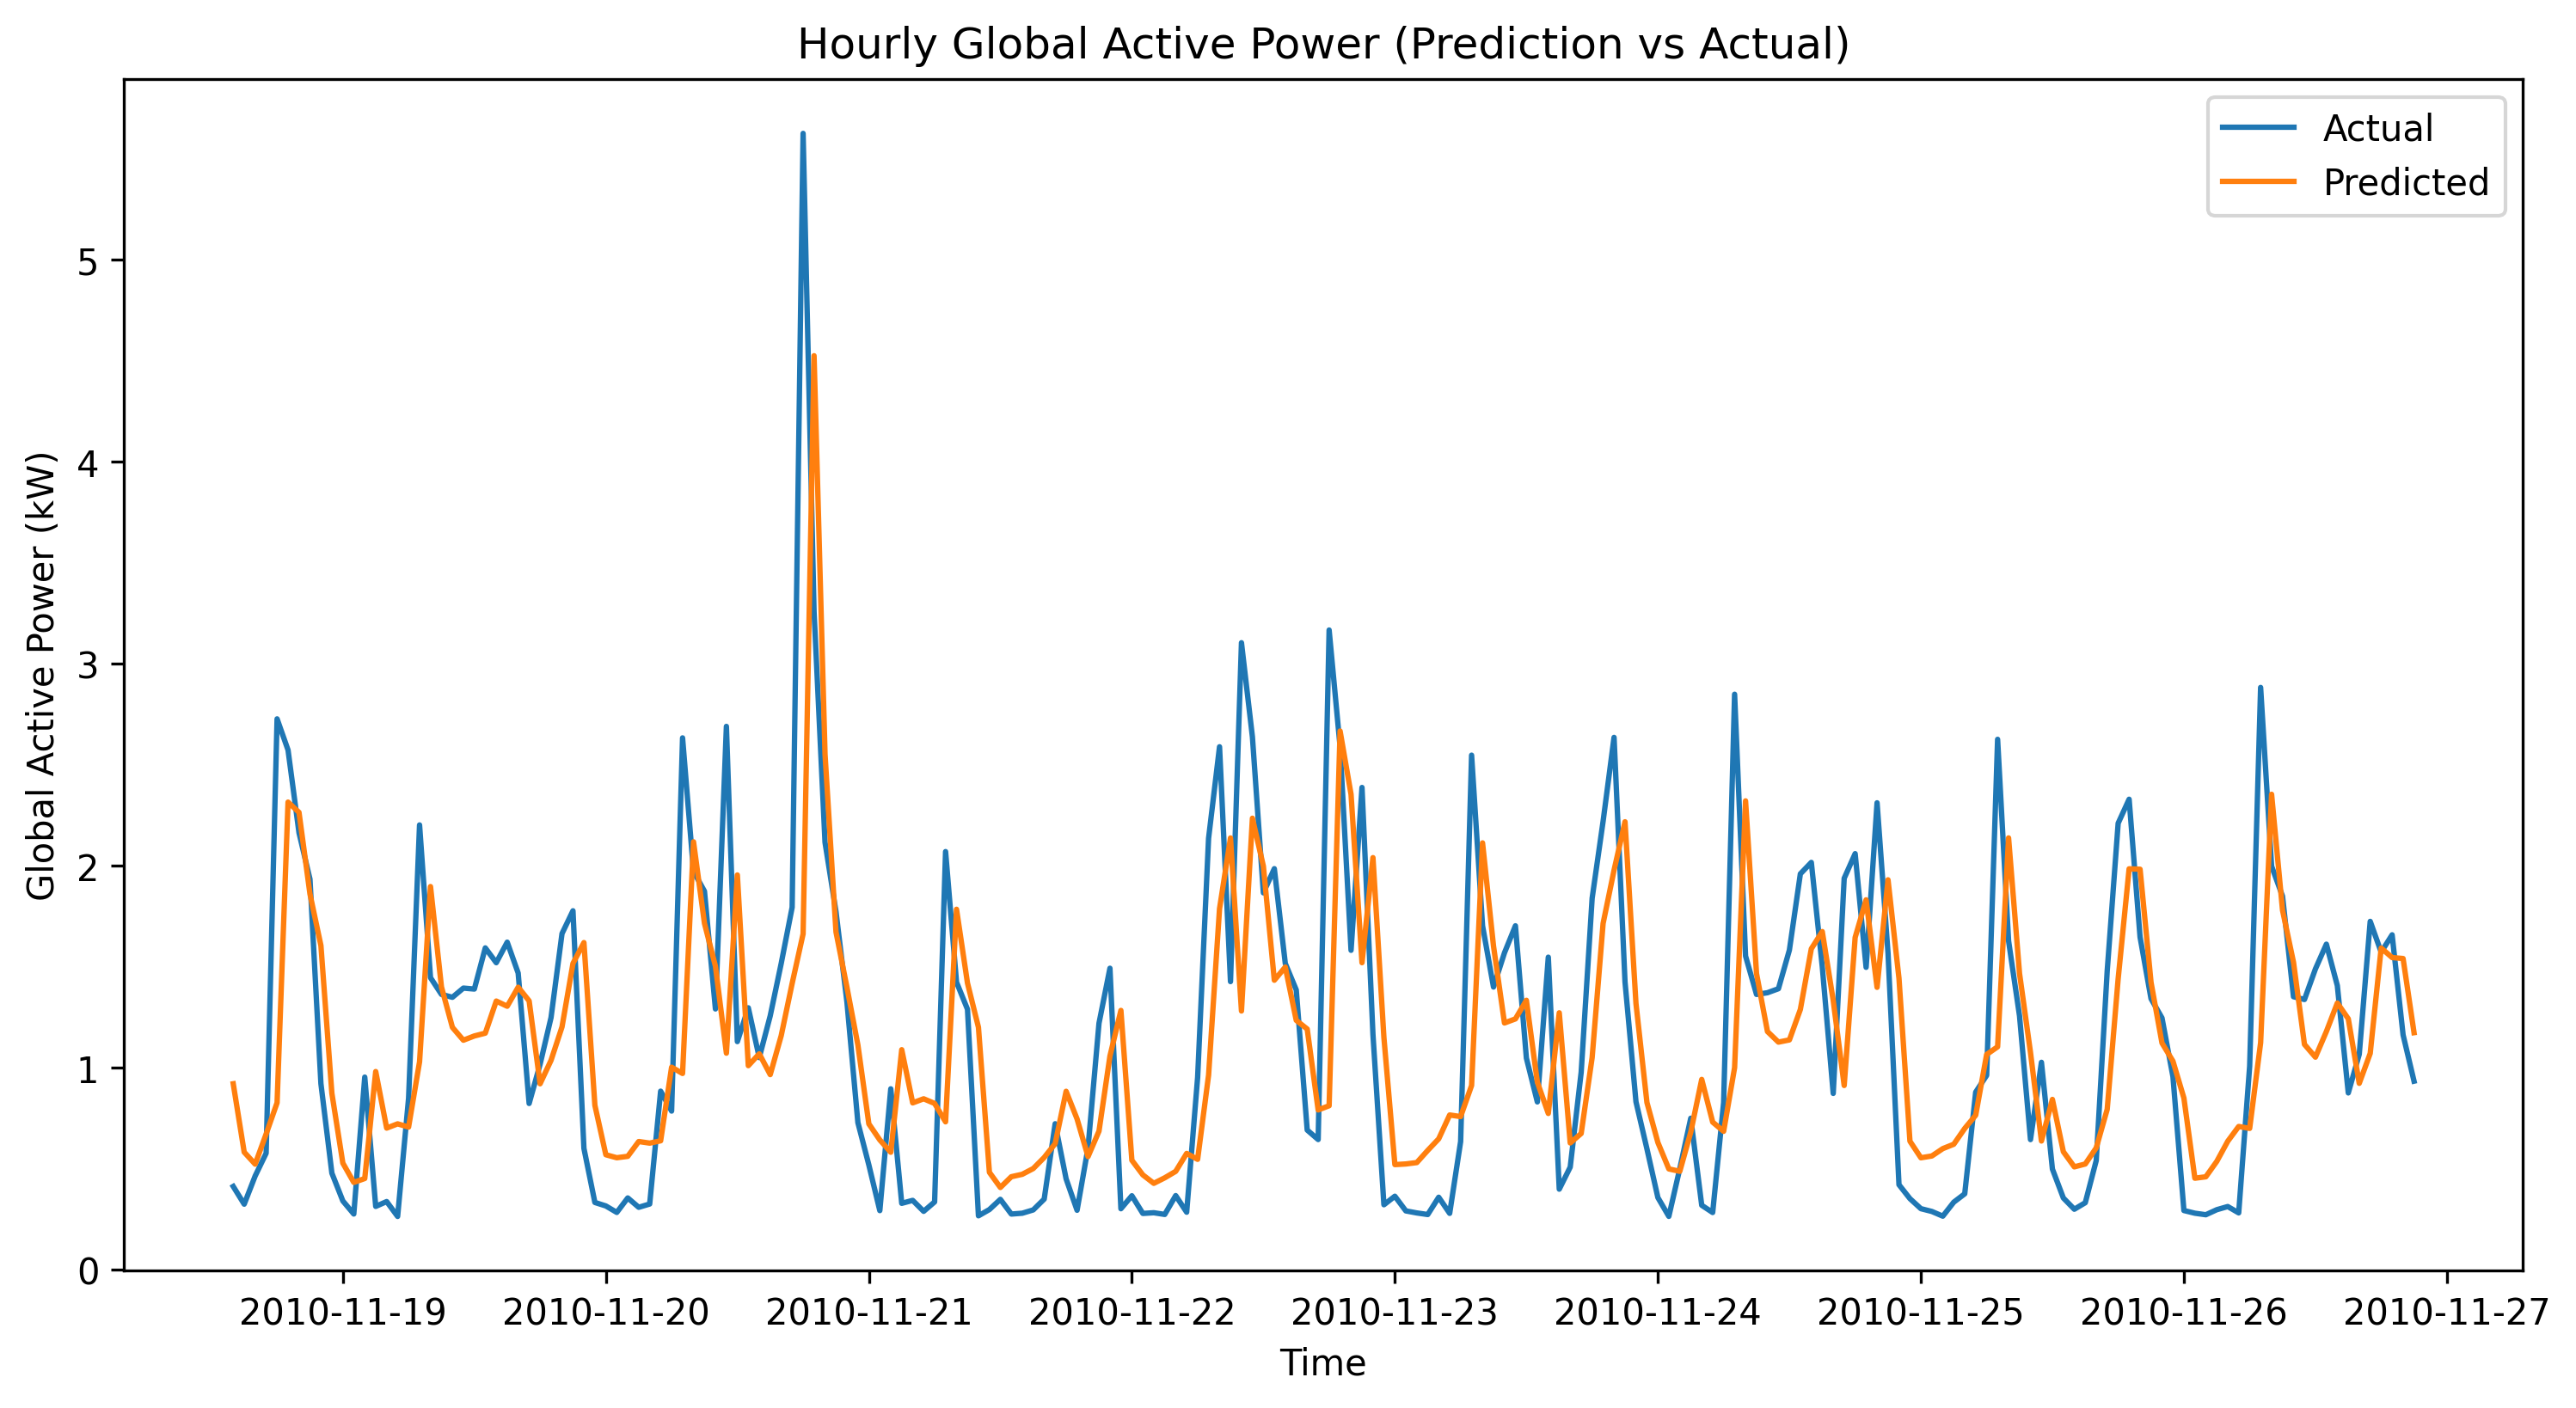

In [56]:
# Define sequence length and features
sequence_length = 12             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df) - sequence_length):
    seq = scaled_df[i:i+sequence_length]
    label = scaled_df[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Fit the model
history = model.fit(X_train, y_train, epochs=50, batch_size=256, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# Plot the training and validation loss (MSE)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
y_train_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_y_train = scaler.inverse_transform(y_train_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[1], axis=-1)
pred_y_train = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
y_test_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_y_test = scaler.inverse_transform(y_test_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[1], axis=-1)
pred_y_test = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_y_train, pred_y_train):.3f}')
print(f'Train MSE: {mean_squared_error(true_y_train, pred_y_train):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_y_train, pred_y_train)):.3f}')
print(f'Train R² score: {r2_score(true_y_train, pred_y_train):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_y_test, pred_y_test):.3f}')
print(f'Test MSE: {mean_squared_error(true_y_test, pred_y_test):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_y_test, pred_y_test)):.3f}')
print(f'Test R² score: {r2_score(true_y_test, pred_y_test):.3f}')

# Plotting Hourly Global Active Power (Prediction vs Actual)
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_y_test[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_y_test[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

# LSTM model-8 SGD(learning_rate=0.0001, epochs=100, batch_size=256)

(27661, 12, 1) (27661,) (6916, 12, 1) (6916,)
Epoch 1/100
109/109 - 2s - 14ms/step - loss: 0.0374 - val_loss: 0.0250
Epoch 2/100
109/109 - 1s - 10ms/step - loss: 0.0350 - val_loss: 0.0232
Epoch 3/100
109/109 - 1s - 9ms/step - loss: 0.0333 - val_loss: 0.0216
Epoch 4/100
109/109 - 0s - 4ms/step - loss: 0.0315 - val_loss: 0.0202
Epoch 5/100
109/109 - 1s - 6ms/step - loss: 0.0301 - val_loss: 0.0190
Epoch 6/100
109/109 - 1s - 6ms/step - loss: 0.0288 - val_loss: 0.0180
Epoch 7/100
109/109 - 0s - 4ms/step - loss: 0.0277 - val_loss: 0.0171
Epoch 8/100
109/109 - 1s - 6ms/step - loss: 0.0266 - val_loss: 0.0164
Epoch 9/100
109/109 - 1s - 8ms/step - loss: 0.0258 - val_loss: 0.0157
Epoch 10/100
109/109 - 1s - 7ms/step - loss: 0.0250 - val_loss: 0.0151
Epoch 11/100
109/109 - 1s - 10ms/step - loss: 0.0244 - val_loss: 0.0146
Epoch 12/100
109/109 - 1s - 10ms/step - loss: 0.0237 - val_loss: 0.0142
Epoch 13/100
109/109 - 1s - 12ms/step - loss: 0.0233 - val_loss: 0.0138
Epoch 14/100
109/109 - 2s - 14ms/st

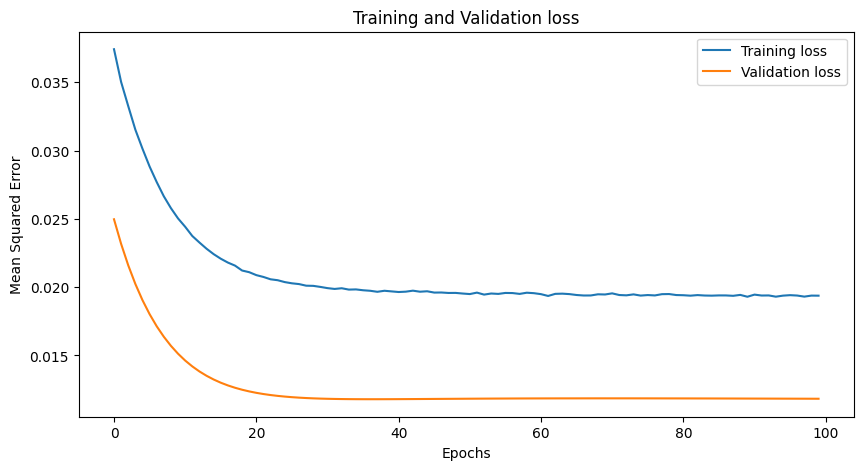

865/865 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Train MAE: 0.710
Train MSE: 0.781
Train RMSE: 0.884
Train R² score: 0.093

Test MAE: 0.579
Test MSE: 0.490
Test RMSE: 0.700
Test R² score: 0.064


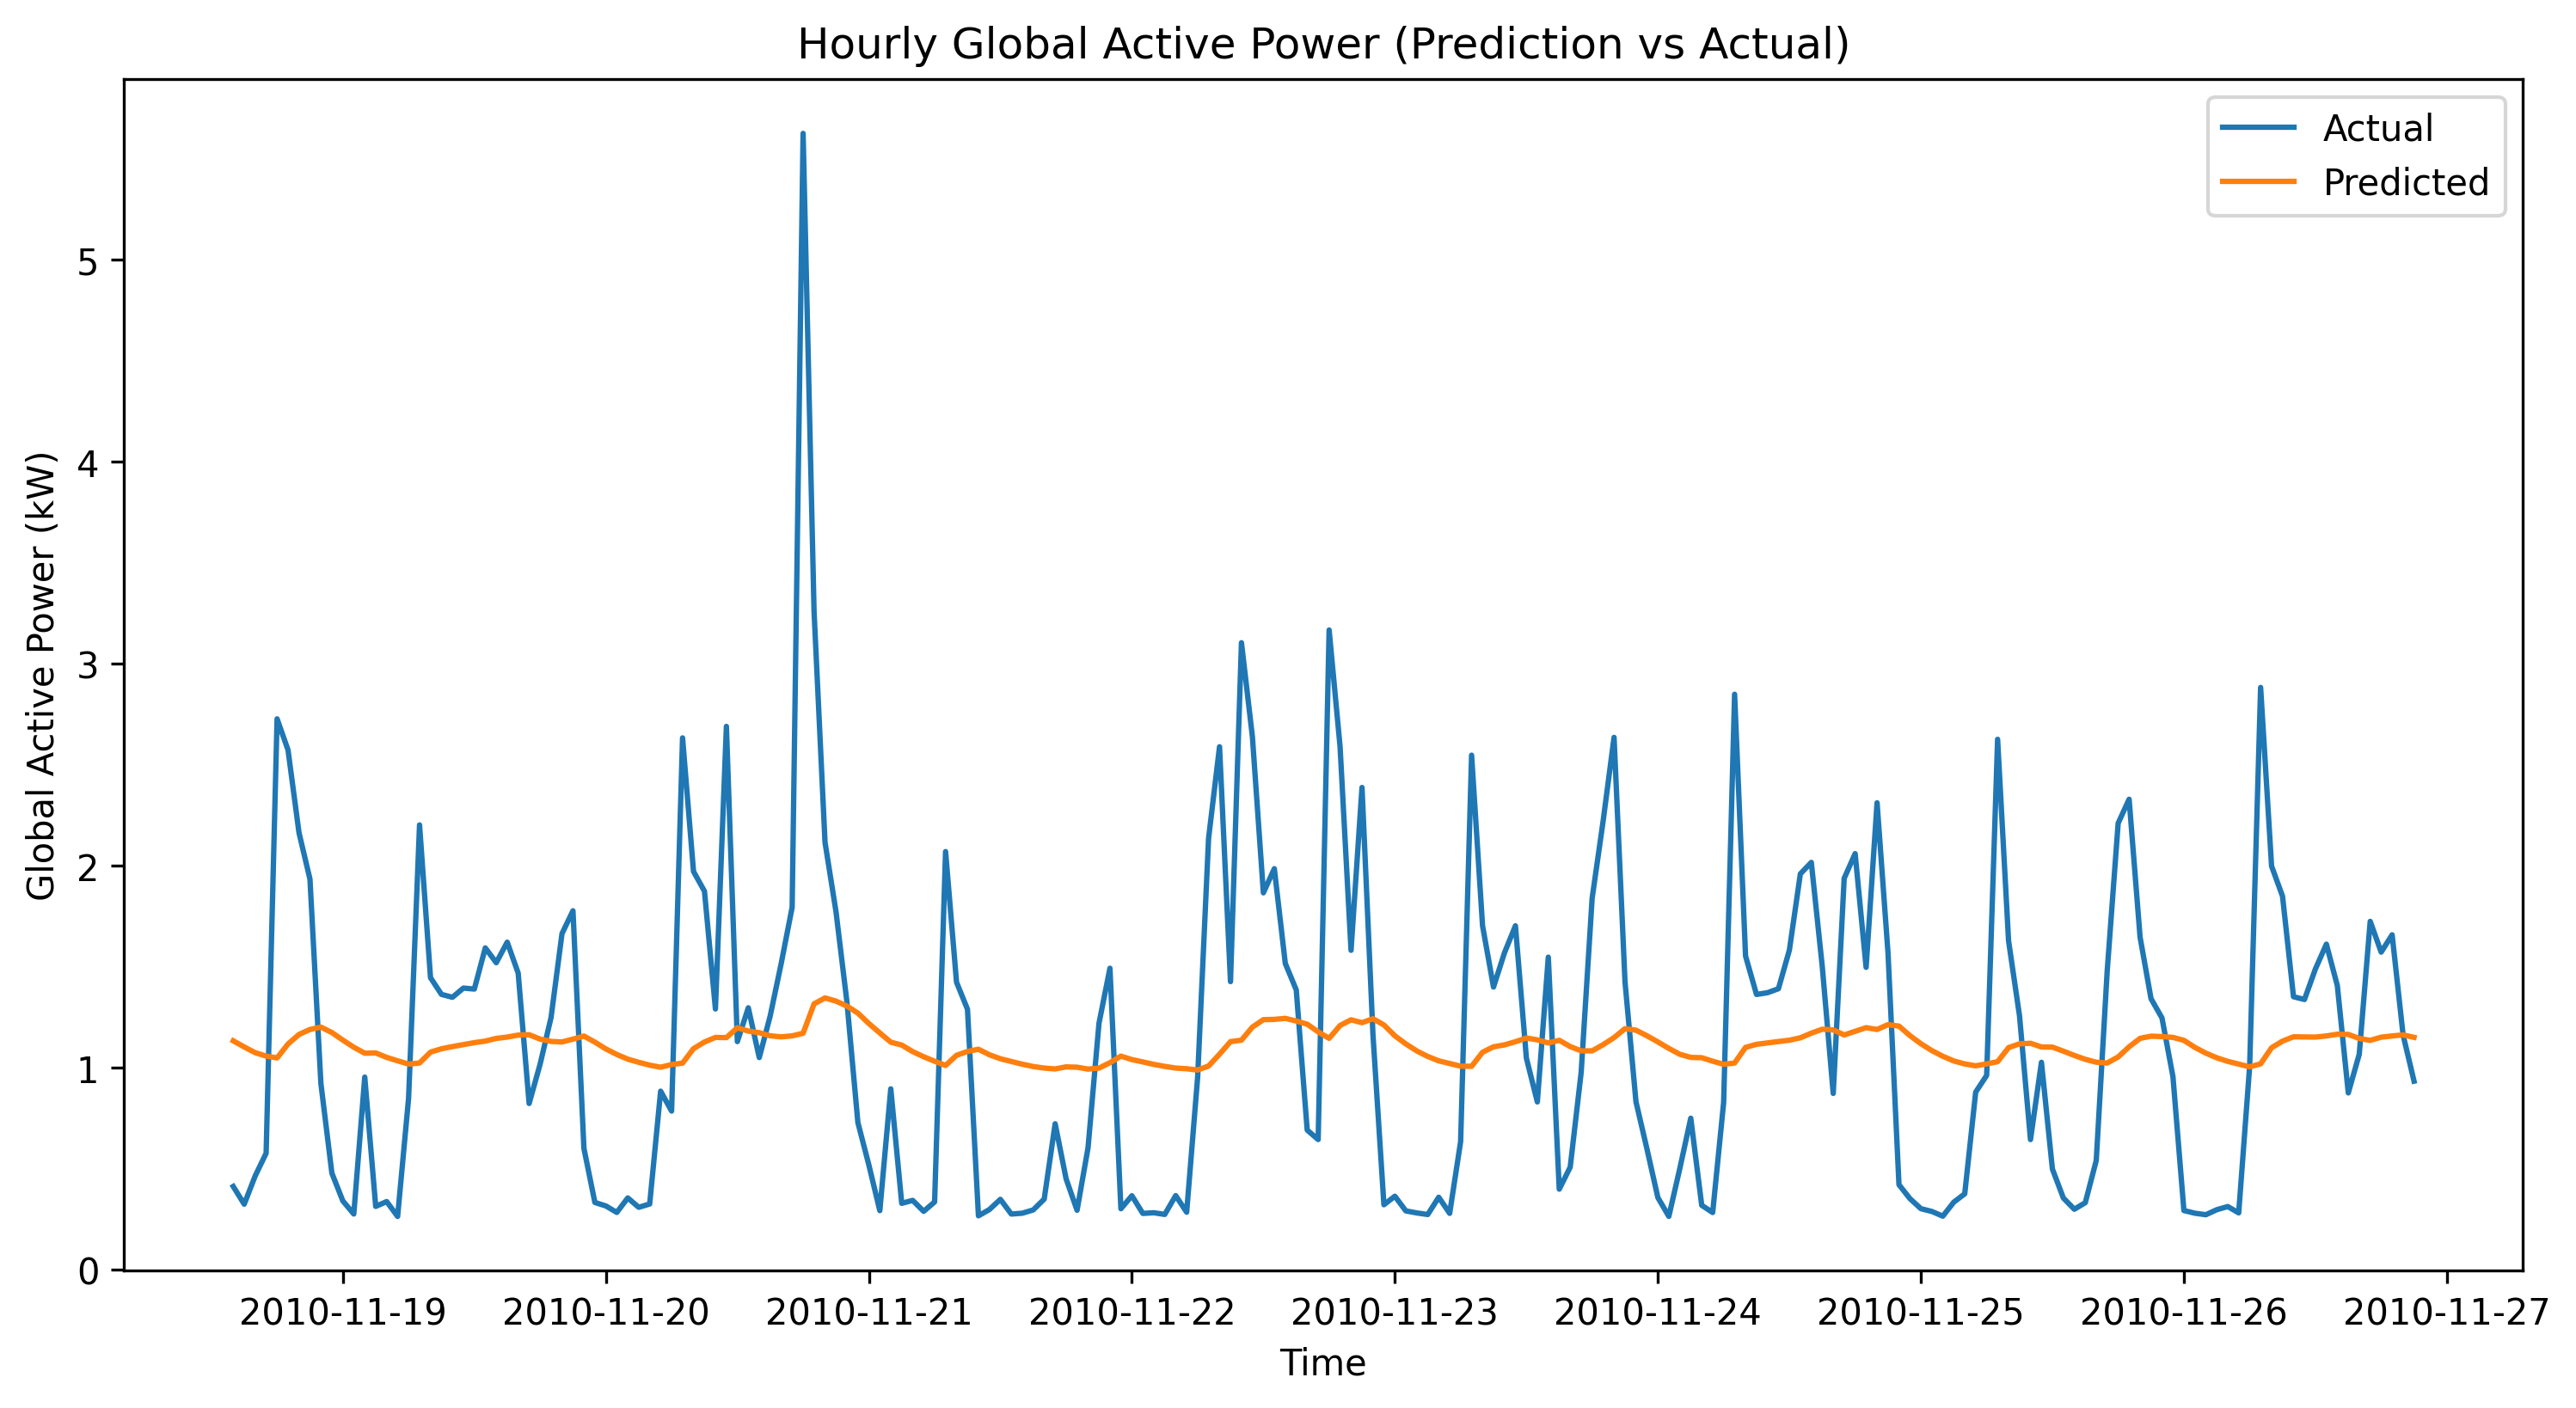

In [57]:
# Define sequence length and features
sequence_length = 12             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df) - sequence_length):
    seq = scaled_df[i:i+sequence_length]
    label = scaled_df[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=SGD(learning_rate=0.0001), loss='mean_squared_error')

# Fit the model
history = model.fit(X_train, y_train, epochs=100, batch_size=256, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# Plot the training and validation loss (MSE)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
y_train_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_y_train = scaler.inverse_transform(y_train_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[1], axis=-1)
pred_y_train = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
y_test_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_y_test = scaler.inverse_transform(y_test_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[1], axis=-1)
pred_y_test = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_y_train, pred_y_train):.3f}')
print(f'Train MSE: {mean_squared_error(true_y_train, pred_y_train):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_y_train, pred_y_train)):.3f}')
print(f'Train R² score: {r2_score(true_y_train, pred_y_train):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_y_test, pred_y_test):.3f}')
print(f'Test MSE: {mean_squared_error(true_y_test, pred_y_test):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_y_test, pred_y_test)):.3f}')
print(f'Test R² score: {r2_score(true_y_test, pred_y_test):.3f}')

# Plotting Hourly Global Active Power (Prediction vs Actual)
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_y_test[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_y_test[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

# LSTM model-9 RMSProp(learning_rate=0.0001, epochs=20, batch_size=32)

Epoch 1/20
865/865 - 6s - 7ms/step - loss: 0.0196 - val_loss: 0.0116
Epoch 2/20
865/865 - 8s - 9ms/step - loss: 0.0151 - val_loss: 0.0106
Epoch 3/20
865/865 - 6s - 8ms/step - loss: 0.0136 - val_loss: 0.0098
Epoch 4/20
865/865 - 3s - 4ms/step - loss: 0.0125 - val_loss: 0.0092
Epoch 5/20
865/865 - 3s - 4ms/step - loss: 0.0116 - val_loss: 0.0085
Epoch 6/20
865/865 - 3s - 4ms/step - loss: 0.0111 - val_loss: 0.0082
Epoch 7/20
865/865 - 4s - 4ms/step - loss: 0.0108 - val_loss: 0.0079
Epoch 8/20
865/865 - 4s - 4ms/step - loss: 0.0106 - val_loss: 0.0079
Epoch 9/20
865/865 - 4s - 5ms/step - loss: 0.0106 - val_loss: 0.0077
Epoch 10/20
865/865 - 3s - 3ms/step - loss: 0.0104 - val_loss: 0.0077
Epoch 11/20
865/865 - 6s - 7ms/step - loss: 0.0104 - val_loss: 0.0077
Epoch 12/20
865/865 - 3s - 3ms/step - loss: 0.0103 - val_loss: 0.0077
Epoch 13/20
865/865 - 3s - 4ms/step - loss: 0.0103 - val_loss: 0.0076
Epoch 14/20
865/865 - 4s - 4ms/step - loss: 0.0103 - val_loss: 0.0077
Epoch 15/20
865/865 - 4s - 5m

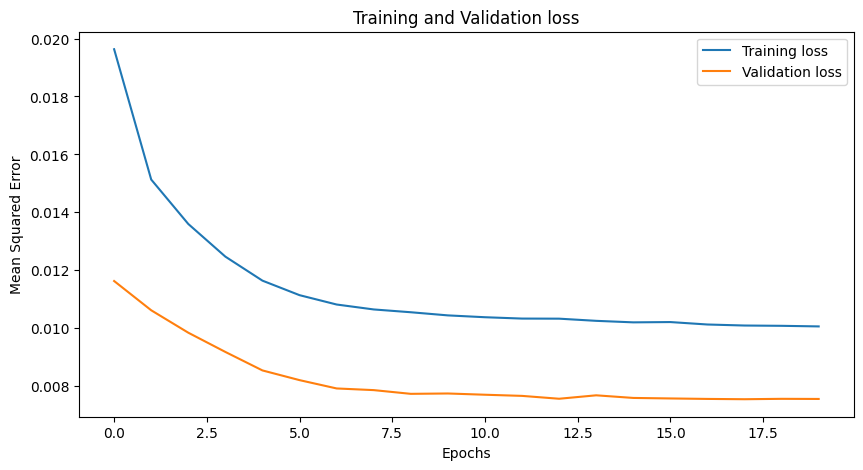

865/865 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Train MAE: 0.506
Train MSE: 0.429
Train RMSE: 0.655
Train R² score: 0.501

Test MAE: 0.440
Test MSE: 0.313
Test RMSE: 0.560
Test R² score: 0.402


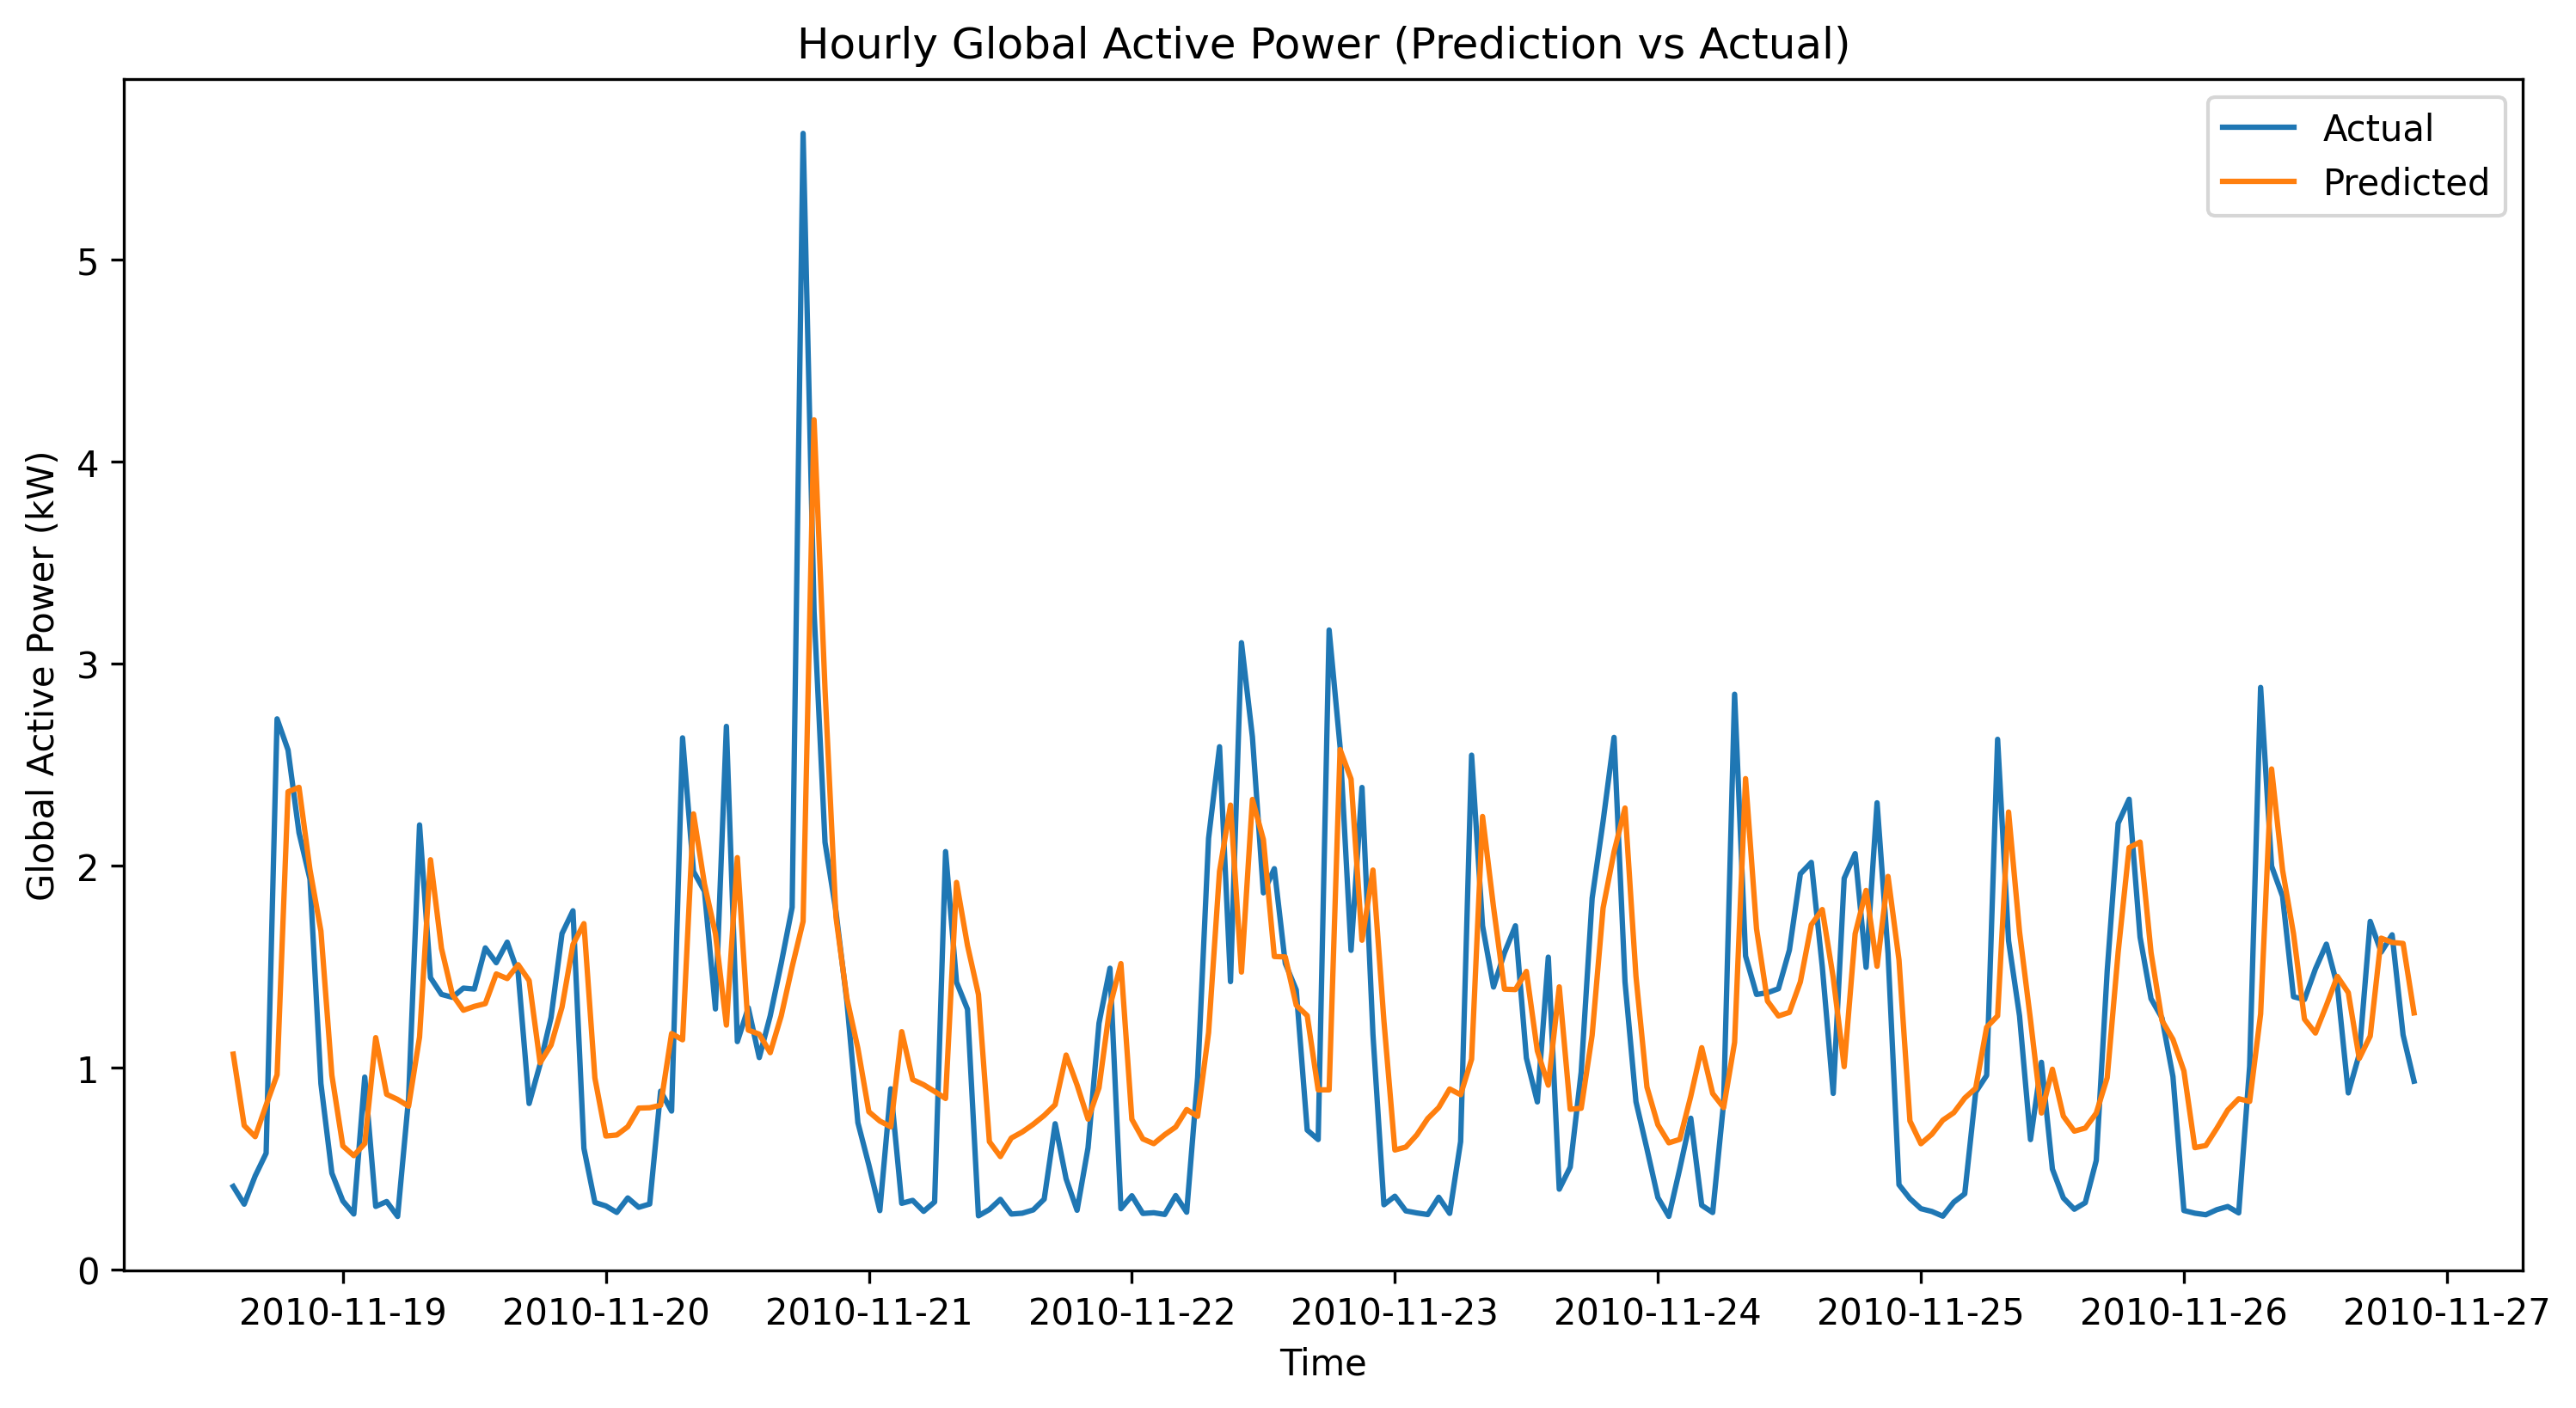

In [58]:
# Define sequence length and features
sequence_length = 12             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df) - sequence_length):
    seq = scaled_df[i:i+sequence_length]
    label = scaled_df[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='mean_squared_error')

# Fit the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# Plot the training and validation loss (MSE)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
y_train_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_y_train = scaler.inverse_transform(y_train_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[1], axis=-1)
pred_y_train = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
y_test_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_y_test = scaler.inverse_transform(y_test_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[1], axis=-1)
pred_y_test = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_y_train, pred_y_train):.3f}')
print(f'Train MSE: {mean_squared_error(true_y_train, pred_y_train):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_y_train, pred_y_train)):.3f}')
print(f'Train R² score: {r2_score(true_y_train, pred_y_train):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_y_test, pred_y_test):.3f}')
print(f'Test MSE: {mean_squared_error(true_y_test, pred_y_test):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_y_test, pred_y_test)):.3f}')
print(f'Test R² score: {r2_score(true_y_test, pred_y_test):.3f}')

# Plotting Hourly Global Active Power (Prediction vs Actual)
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_y_test[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_y_test[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

# LSTM model-10 RMSProp(learning_rate=0.0001, epochs=30, batch_size=64)

Epoch 1/30
433/433 - 3s - 6ms/step - loss: 0.0237 - val_loss: 0.0126
Epoch 2/30
433/433 - 2s - 6ms/step - loss: 0.0170 - val_loss: 0.0112
Epoch 3/30
433/433 - 3s - 6ms/step - loss: 0.0154 - val_loss: 0.0104
Epoch 4/30
433/433 - 3s - 7ms/step - loss: 0.0144 - val_loss: 0.0099
Epoch 5/30
433/433 - 3s - 7ms/step - loss: 0.0135 - val_loss: 0.0095
Epoch 6/30
433/433 - 2s - 4ms/step - loss: 0.0128 - val_loss: 0.0091
Epoch 7/30
433/433 - 2s - 4ms/step - loss: 0.0122 - val_loss: 0.0088
Epoch 8/30
433/433 - 3s - 6ms/step - loss: 0.0118 - val_loss: 0.0083
Epoch 9/30
433/433 - 2s - 4ms/step - loss: 0.0114 - val_loss: 0.0082
Epoch 10/30
433/433 - 3s - 6ms/step - loss: 0.0111 - val_loss: 0.0079
Epoch 11/30
433/433 - 2s - 5ms/step - loss: 0.0109 - val_loss: 0.0078
Epoch 12/30
433/433 - 2s - 6ms/step - loss: 0.0107 - val_loss: 0.0076
Epoch 13/30
433/433 - 2s - 4ms/step - loss: 0.0106 - val_loss: 0.0076
Epoch 14/30
433/433 - 2s - 3ms/step - loss: 0.0106 - val_loss: 0.0076
Epoch 15/30
433/433 - 3s - 6m

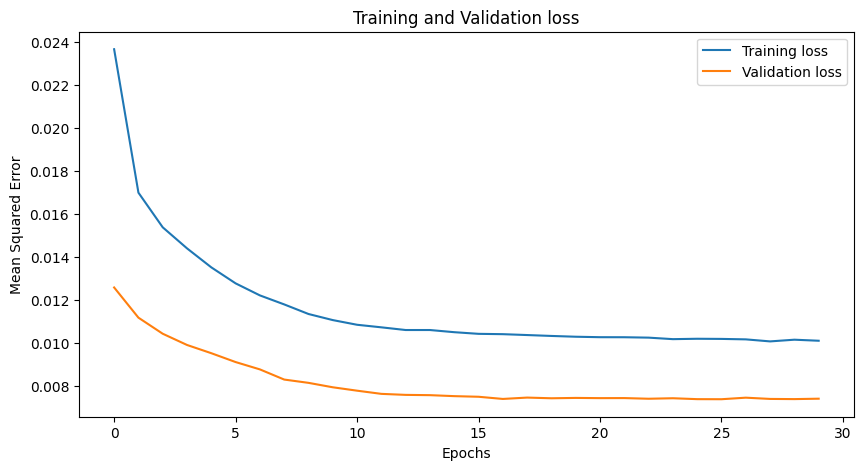

865/865 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Train MAE: 0.497
Train MSE: 0.424
Train RMSE: 0.651
Train R² score: 0.507

Test MAE: 0.431
Test MSE: 0.307
Test RMSE: 0.554
Test R² score: 0.413


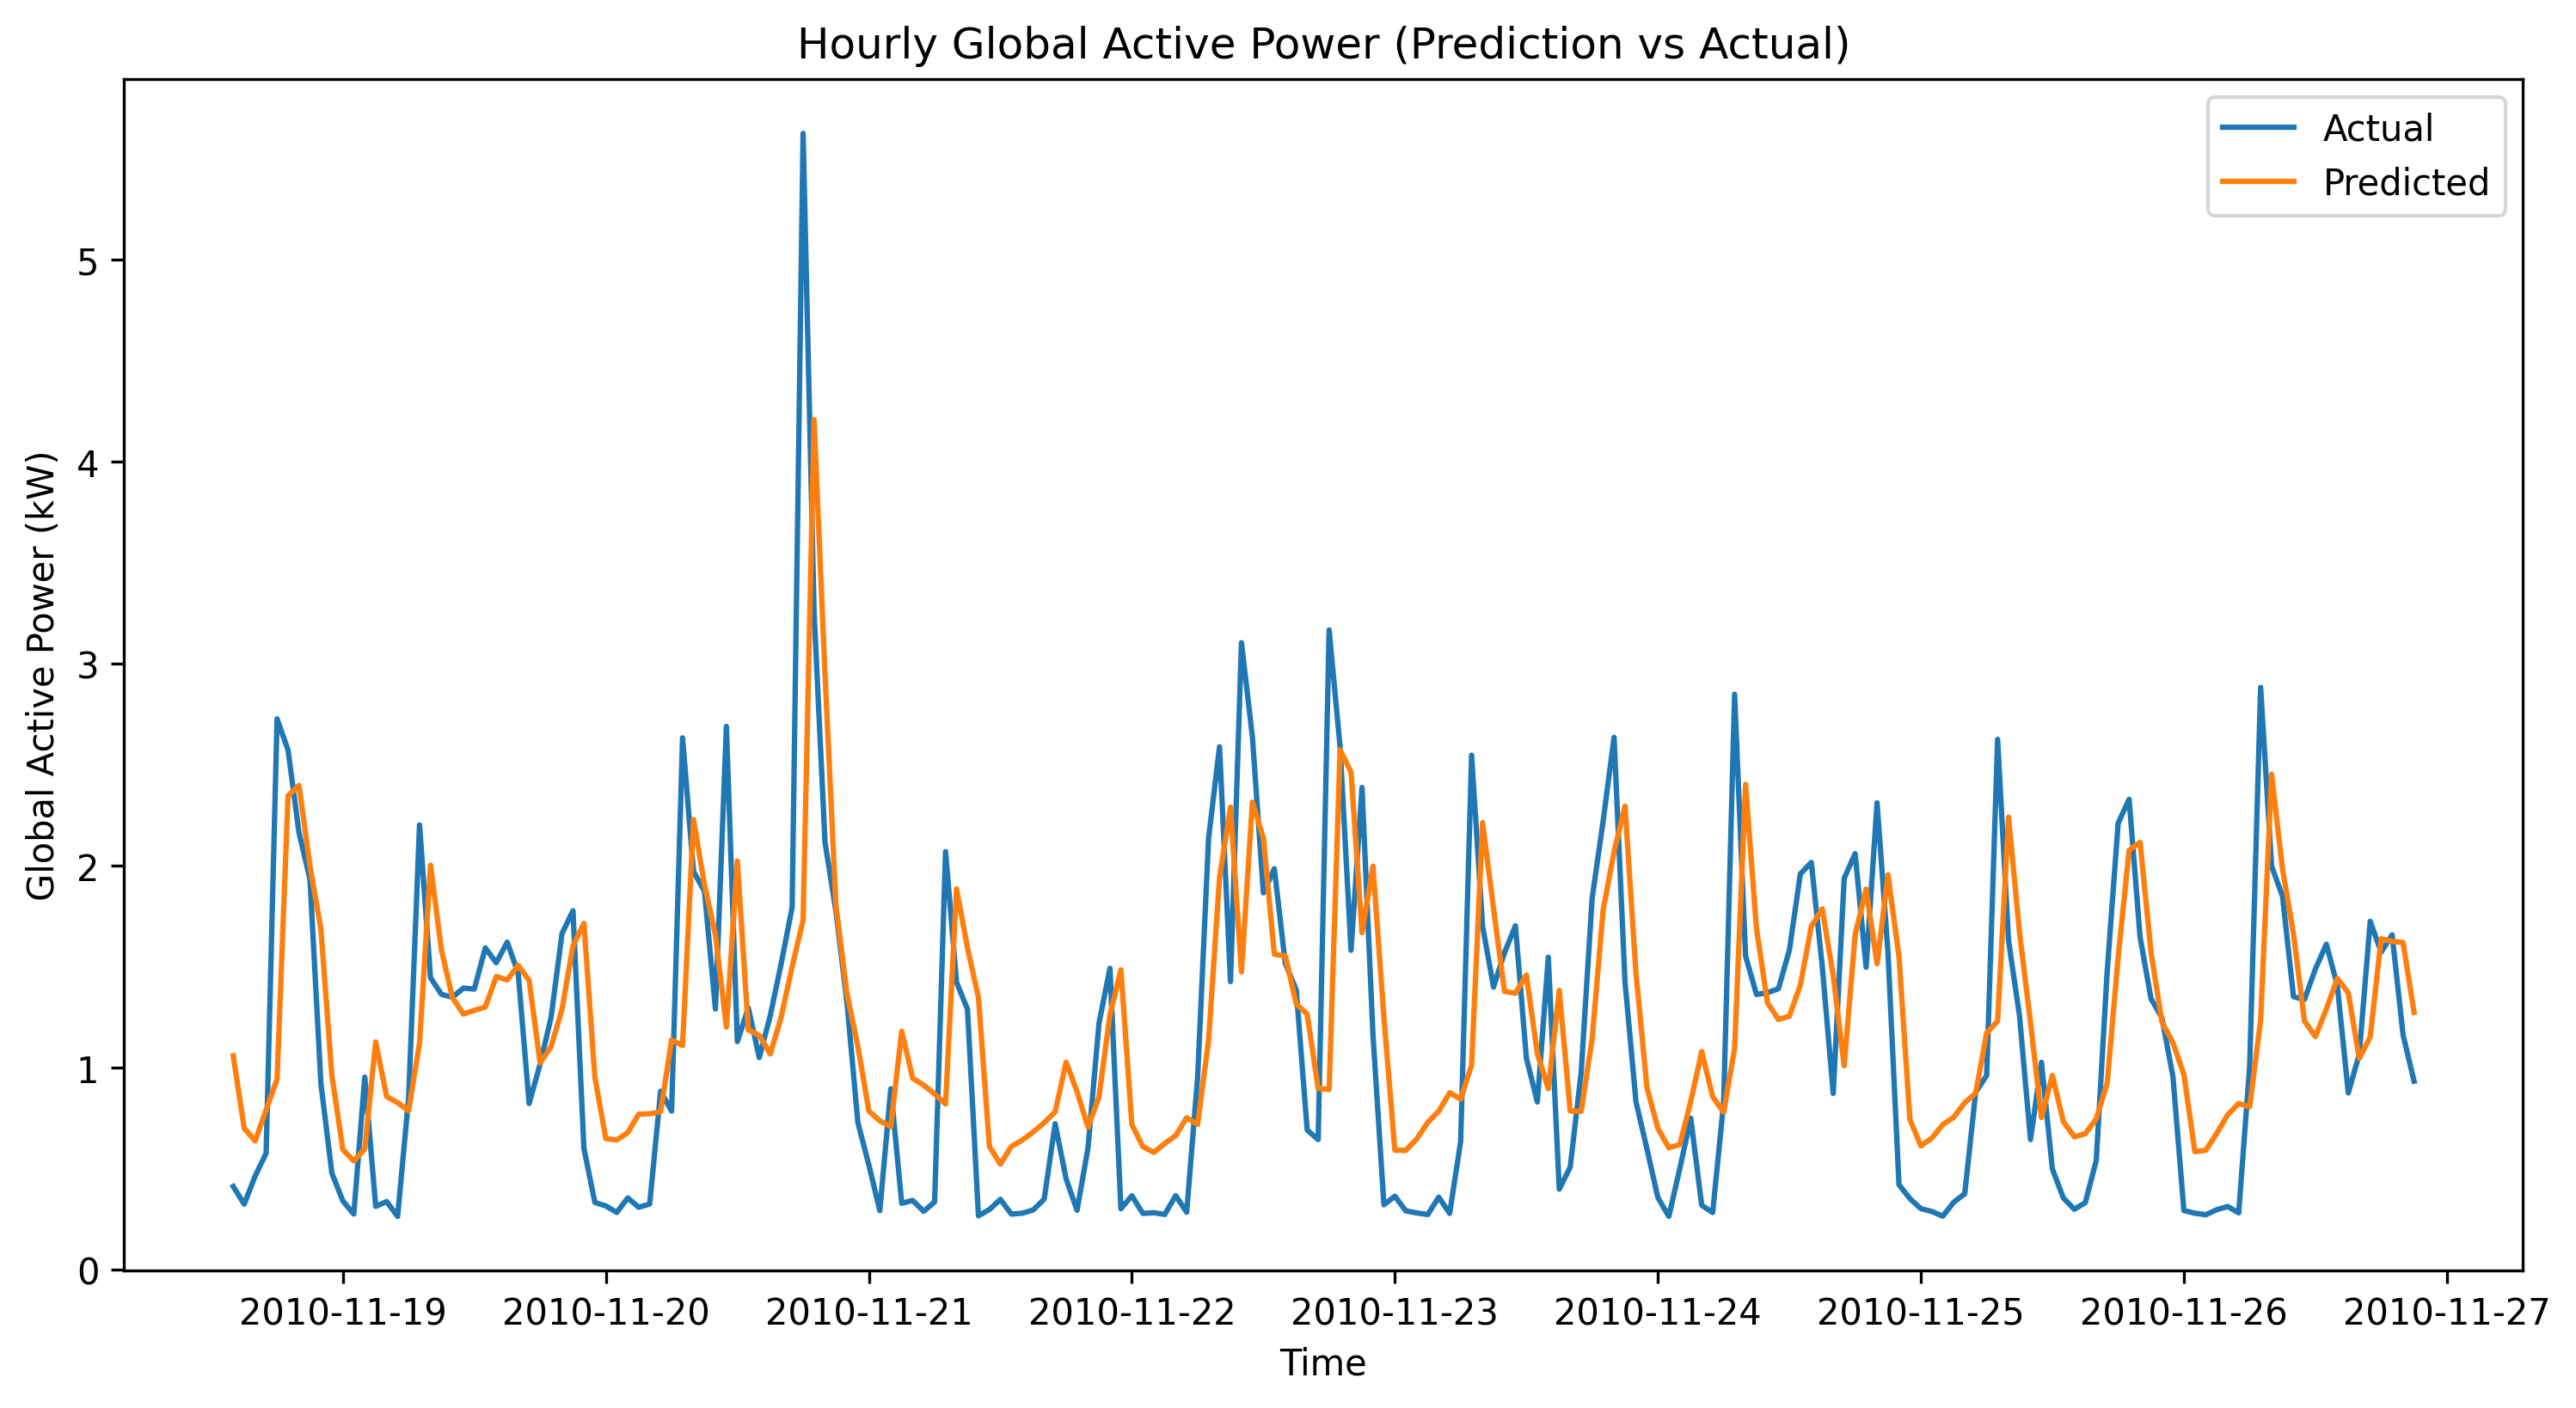

In [59]:
# Define sequence length and features
sequence_length = 12             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df) - sequence_length):
    seq = scaled_df[i:i+sequence_length]
    label = scaled_df[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='mean_squared_error')

# Fit the model
history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# Plot the training and validation loss (MSE)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
y_train_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_y_train = scaler.inverse_transform(y_train_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[1], axis=-1)
pred_y_train = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
y_test_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_y_test = scaler.inverse_transform(y_test_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[1], axis=-1)
pred_y_test = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_y_train, pred_y_train):.3f}')
print(f'Train MSE: {mean_squared_error(true_y_train, pred_y_train):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_y_train, pred_y_train)):.3f}')
print(f'Train R² score: {r2_score(true_y_train, pred_y_train):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_y_test, pred_y_test):.3f}')
print(f'Test MSE: {mean_squared_error(true_y_test, pred_y_test):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_y_test, pred_y_test)):.3f}')
print(f'Test R² score: {r2_score(true_y_test, pred_y_test):.3f}')

# Plotting Hourly Global Active Power (Prediction vs Actual)
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_y_test[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_y_test[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

# LSTM model-11 RMSProp(learning_rate=0.0001, epochs=50, batch_size=256)

Epoch 1/50
109/109 - 1s - 13ms/step - loss: 0.0251 - val_loss: 0.0122
Epoch 2/50
109/109 - 0s - 4ms/step - loss: 0.0193 - val_loss: 0.0117
Epoch 3/50
109/109 - 0s - 4ms/step - loss: 0.0183 - val_loss: 0.0113
Epoch 4/50
109/109 - 0s - 4ms/step - loss: 0.0177 - val_loss: 0.0109
Epoch 5/50
109/109 - 1s - 5ms/step - loss: 0.0169 - val_loss: 0.0106
Epoch 6/50
109/109 - 0s - 4ms/step - loss: 0.0165 - val_loss: 0.0103
Epoch 7/50
109/109 - 1s - 6ms/step - loss: 0.0160 - val_loss: 0.0101
Epoch 8/50
109/109 - 1s - 6ms/step - loss: 0.0156 - val_loss: 0.0098
Epoch 9/50
109/109 - 0s - 4ms/step - loss: 0.0152 - val_loss: 0.0097
Epoch 10/50
109/109 - 0s - 4ms/step - loss: 0.0148 - val_loss: 0.0095
Epoch 11/50
109/109 - 0s - 4ms/step - loss: 0.0145 - val_loss: 0.0093
Epoch 12/50
109/109 - 0s - 4ms/step - loss: 0.0142 - val_loss: 0.0091
Epoch 13/50
109/109 - 1s - 5ms/step - loss: 0.0139 - val_loss: 0.0090
Epoch 14/50
109/109 - 0s - 4ms/step - loss: 0.0138 - val_loss: 0.0089
Epoch 15/50
109/109 - 1s - 6

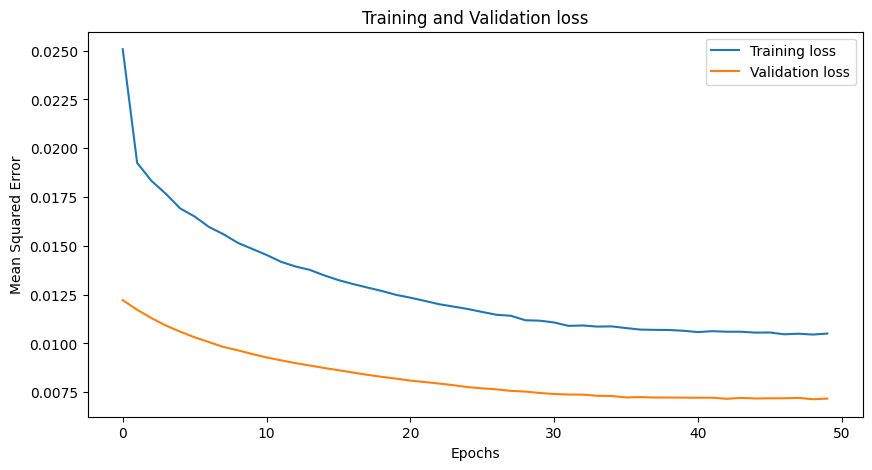

865/865 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Train MAE: 0.478
Train MSE: 0.420
Train RMSE: 0.648
Train R² score: 0.512

Test MAE: 0.410
Test MSE: 0.297
Test RMSE: 0.545
Test R² score: 0.432


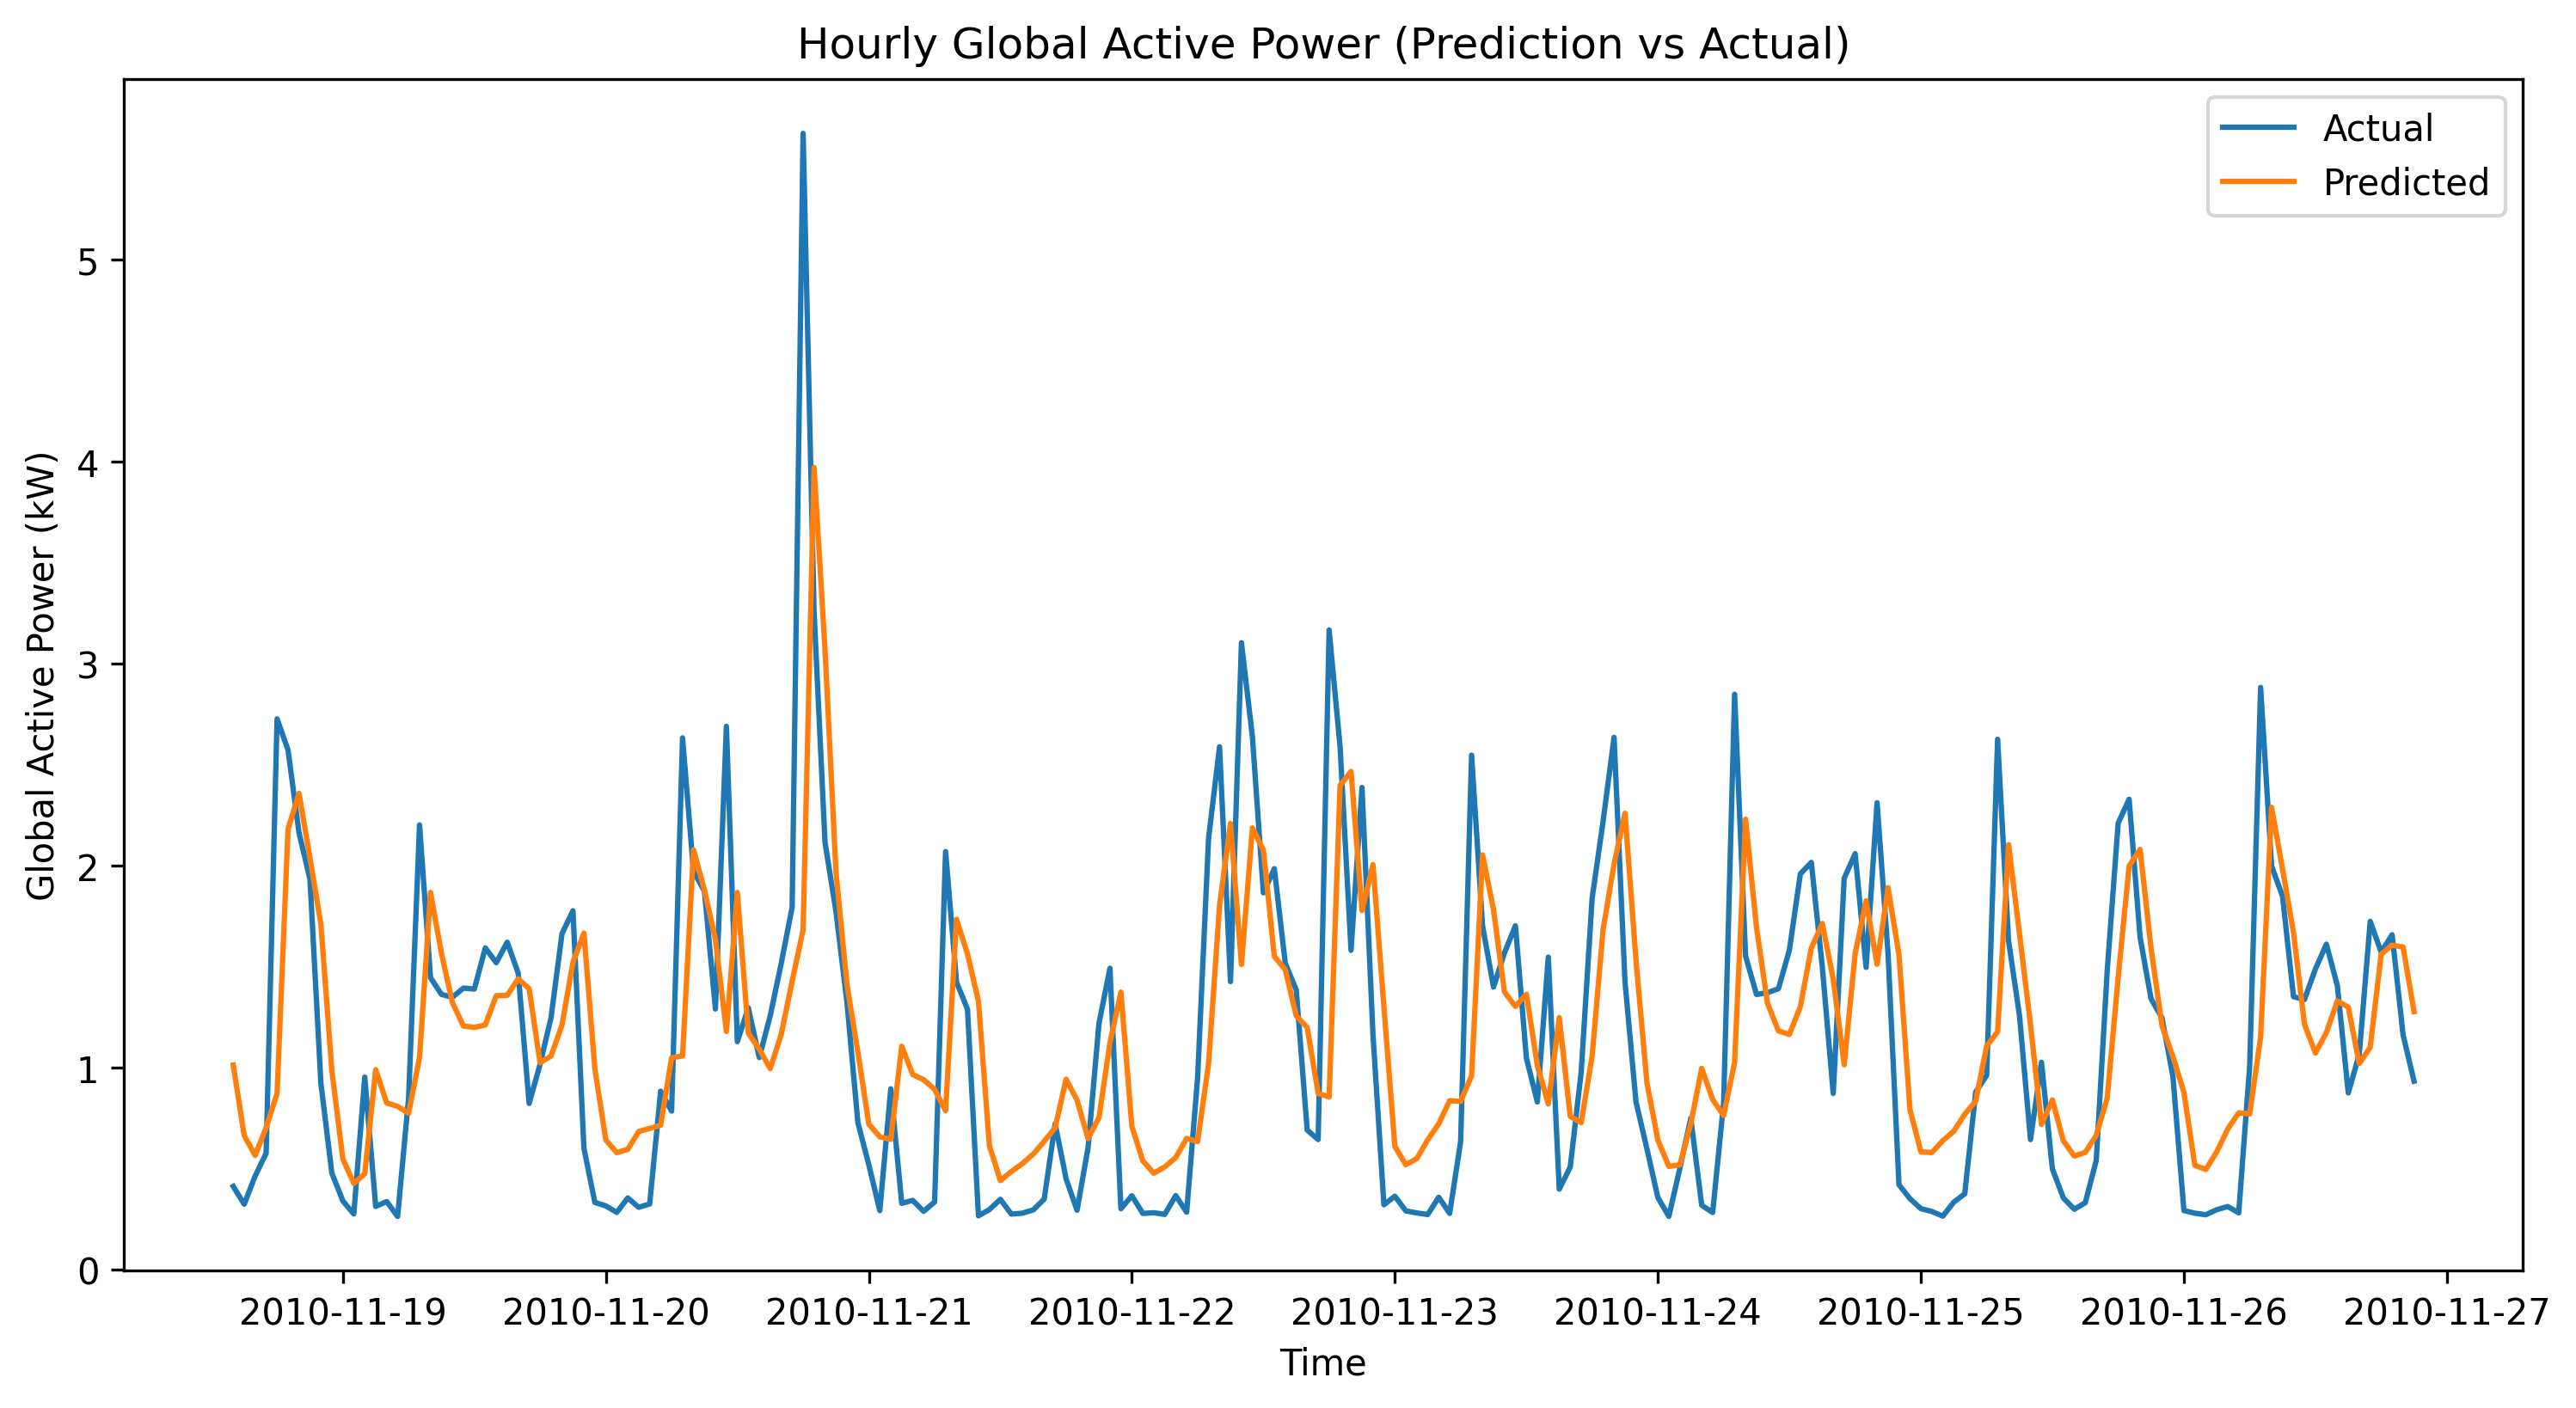

In [60]:
# Define sequence length and features
sequence_length = 12             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df) - sequence_length):
    seq = scaled_df[i:i+sequence_length]
    label = scaled_df[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='mean_squared_error')

# Fit the model
history = model.fit(X_train, y_train, epochs=50, batch_size=256, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# Plot the training and validation loss (MSE)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
y_train_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_y_train = scaler.inverse_transform(y_train_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[1], axis=-1)
pred_y_train = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
y_test_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_y_test = scaler.inverse_transform(y_test_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[1], axis=-1)
pred_y_test = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_y_train, pred_y_train):.3f}')
print(f'Train MSE: {mean_squared_error(true_y_train, pred_y_train):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_y_train, pred_y_train)):.3f}')
print(f'Train R² score: {r2_score(true_y_train, pred_y_train):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_y_test, pred_y_test):.3f}')
print(f'Test MSE: {mean_squared_error(true_y_test, pred_y_test):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_y_test, pred_y_test)):.3f}')
print(f'Test R² score: {r2_score(true_y_test, pred_y_test):.3f}')

# Plotting Hourly Global Active Power (Prediction vs Actual)
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_y_test[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_y_test[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

# LSTM model-12 RMSProp(learning_rate=0.0001, epochs=100, batch_size=256)

Epoch 1/100
109/109 - 1s - 14ms/step - loss: 0.0217 - val_loss: 0.0113
Epoch 2/100
109/109 - 1s - 9ms/step - loss: 0.0178 - val_loss: 0.0109
Epoch 3/100
109/109 - 0s - 4ms/step - loss: 0.0170 - val_loss: 0.0106
Epoch 4/100
109/109 - 0s - 4ms/step - loss: 0.0164 - val_loss: 0.0103
Epoch 5/100
109/109 - 1s - 7ms/step - loss: 0.0160 - val_loss: 0.0100
Epoch 6/100
109/109 - 1s - 12ms/step - loss: 0.0155 - val_loss: 0.0098
Epoch 7/100
109/109 - 1s - 7ms/step - loss: 0.0151 - val_loss: 0.0096
Epoch 8/100
109/109 - 1s - 10ms/step - loss: 0.0147 - val_loss: 0.0094
Epoch 9/100
109/109 - 0s - 5ms/step - loss: 0.0145 - val_loss: 0.0092
Epoch 10/100
109/109 - 1s - 5ms/step - loss: 0.0142 - val_loss: 0.0091
Epoch 11/100
109/109 - 0s - 4ms/step - loss: 0.0139 - val_loss: 0.0089
Epoch 12/100
109/109 - 1s - 6ms/step - loss: 0.0136 - val_loss: 0.0088
Epoch 13/100
109/109 - 1s - 6ms/step - loss: 0.0134 - val_loss: 0.0087
Epoch 14/100
109/109 - 0s - 4ms/step - loss: 0.0132 - val_loss: 0.0085
Epoch 15/100

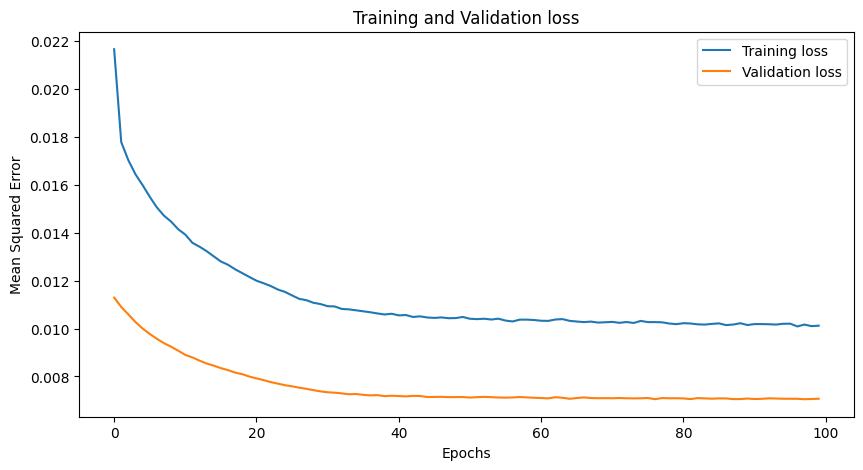

865/865 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Train MAE: 0.471
Train MSE: 0.411
Train RMSE: 0.641
Train R² score: 0.522

Test MAE: 0.403
Test MSE: 0.293
Test RMSE: 0.541
Test R² score: 0.440


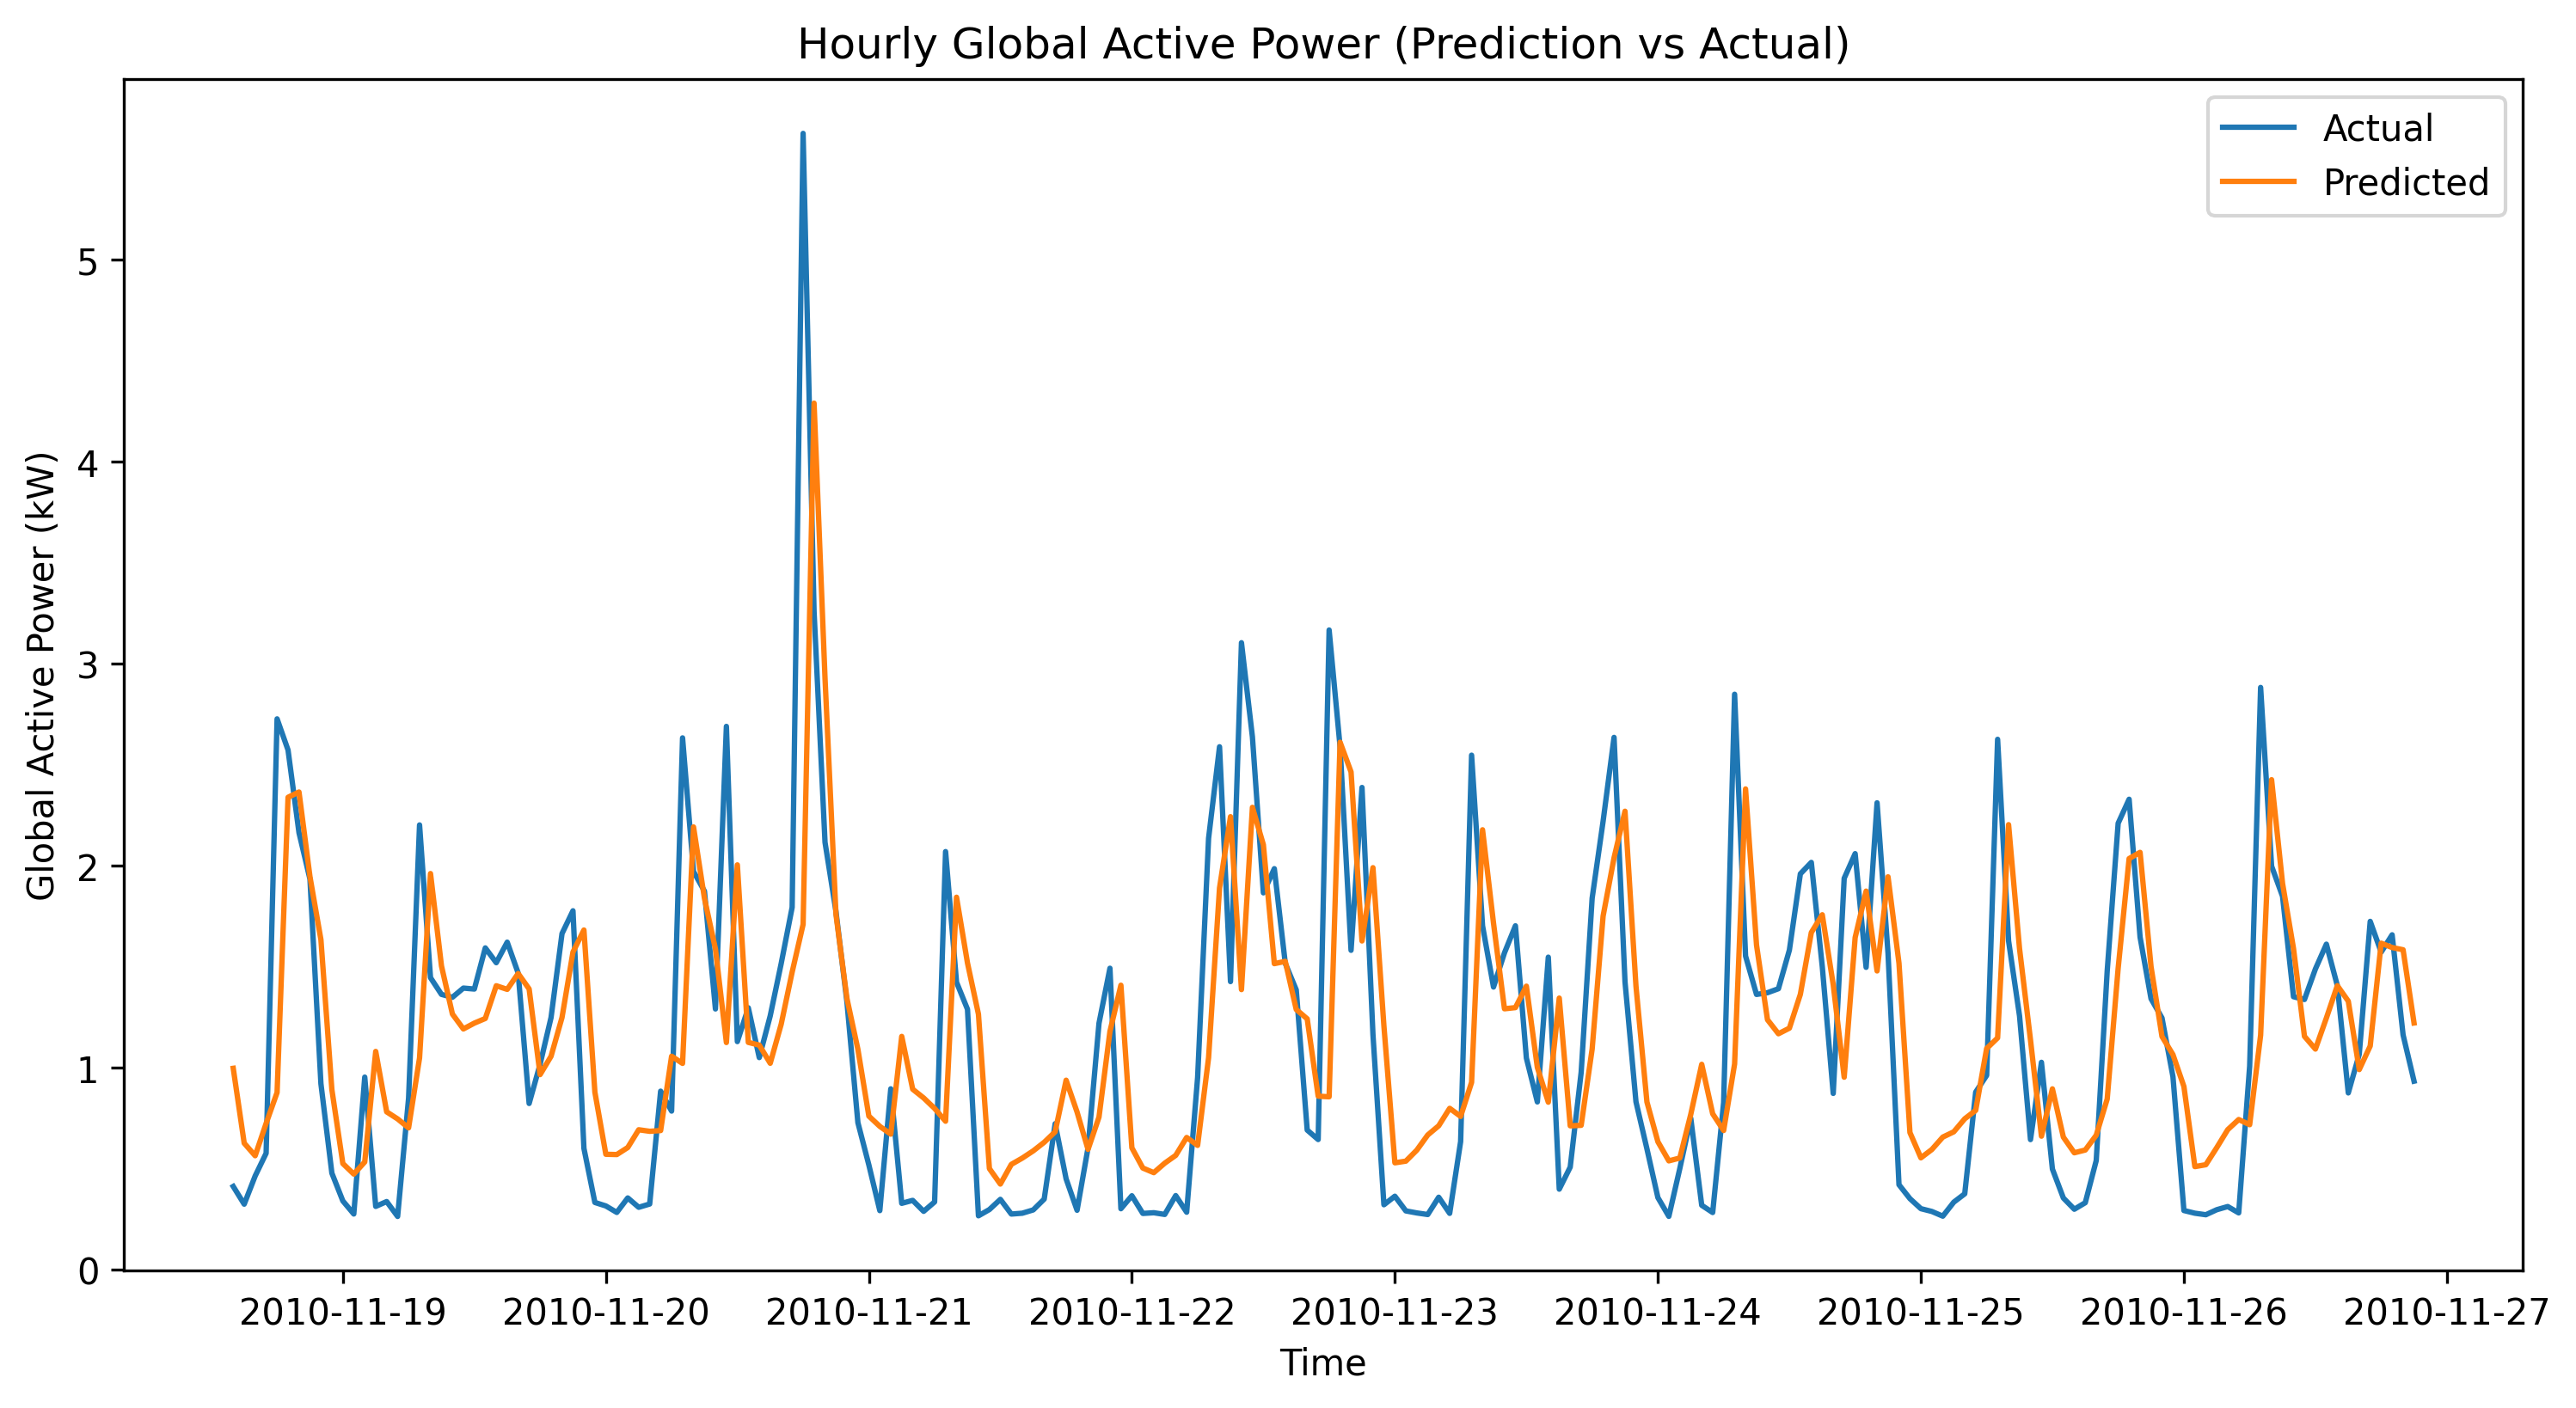

In [61]:
# Define sequence length and features
sequence_length = 12             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df) - sequence_length):
    seq = scaled_df[i:i+sequence_length]
    label = scaled_df[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='mean_squared_error')

# Fit the model
history = model.fit(X_train, y_train, epochs=100, batch_size=256, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# Plot the training and validation loss (MSE)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
y_train_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_y_train = scaler.inverse_transform(y_train_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[1], axis=-1)
pred_y_train = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
y_test_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_y_test = scaler.inverse_transform(y_test_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[1], axis=-1)
pred_y_test = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_y_train, pred_y_train):.3f}')
print(f'Train MSE: {mean_squared_error(true_y_train, pred_y_train):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_y_train, pred_y_train)):.3f}')
print(f'Train R² score: {r2_score(true_y_train, pred_y_train):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_y_test, pred_y_test):.3f}')
print(f'Test MSE: {mean_squared_error(true_y_test, pred_y_test):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_y_test, pred_y_test)):.3f}')
print(f'Test R² score: {r2_score(true_y_test, pred_y_test):.3f}')

# Plotting Hourly Global Active Power (Prediction vs Actual)
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_y_test[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_y_test[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()